# **Captcha Recognition**

## **Objective**

Develop an AI-based system that can accurately recognize and extract numerical strings from
CAPTCHA images.

## **Problem** **Statement**

In this challenge, you will be provided with a dataset of CAPTCHA images, each containing a
numerical string. Your task is to build a system that can process these images and output the
corresponding numerical string with high accuracy. CAPTCHA images often include distortions,
noise, and varying fonts to prevent automated recognition, so your solution should demonstrate
robustness against such challenges.

## Importing Required Libraries

Imports essential libraries like NumPy, PyTorch, OpenCV, and Albumentations.
These are used for dataset handling, deep learning model training, and image processing.

In [1]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import glob
import cv2
import csv
import tqdm
import albumentations as A
import matplotlib.pyplot as plt

## Mounting Google Drive

Connects to Google Drive to access the dataset and save model checkpoints.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Config Values
Defining Paths and Hyperparameters
Specifies paths for training/validation datasets and ground truth labels.
Sets batch size, learning rate, image dimensions, and device configuration.

In [3]:
train_path = "/content/drive/MyDrive/dataset/train-images/train-images/"
val_path = "/content/drive/MyDrive/dataset/validation-images/validation-images/"
gt_csv_path = "/content/drive/MyDrive/dataset/captcha_data.csv"

ckpt_path = "/content/drive/MyDrive/dataset/models/"

batch_size = 16
num_workers = 2
learning_rate = 5e-4
num_epochs = 10000

img_width = 256
img_height = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

### Transformations using Albumentations

Defines image augmentation techniques such as resizing, normalization, and flipping.

In [4]:
train_transforms = A.Compose([
        A.Compose([  # Rescale transform
            A.RandomScale(scale_limit=(-0.3, -0.1), always_apply=True),
            A.PadIfNeeded(min_height=64, min_width=30,
                          border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), always_apply=True),
            A.Rotate(limit=4, p=0.5, crop_border=True),
        ], p=0.4),
        A.GaussianBlur(blur_limit = (0, 1), p=0.5),
        A.OneOf([  # Geometric transforms
            A.GridDistortion(always_apply=True, num_steps=7, distort_limit=0.5,
                             border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), normalized=True),
            A.OpticalDistortion(always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
            A.Perspective(scale=0.1, always_apply=True, fit_output=True, pad_val=(255, 255, 255))
        ], p=0.5),
        A.ISONoise(p=0.1),
        A.ImageCompression(quality_lower=30, p=0.2),
        A.GaussNoise(std_range=(0.1, 0.2), p=0.1),
    ])

<ipython-input-4-be286e06538f>:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomScale
  A.RandomScale(scale_limit=(-0.3, -0.1), always_apply=True),
<ipython-input-4-be286e06538f>:4: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=64, min_width=30,
<ipython-input-4-be286e06538f>:10: UserWarning: Argument(s) 'always_apply, border_mode, value' are not valid for transform GridDistortion
  A.GridDistortion(always_apply=True, num_steps=7, distort_limit=0.5,
<ipython-input-4-be286e06538f>:12: UserWarning: Argument(s) 'always_apply, border_mode, value' are not valid for transform OpticalDistortion
  A.OpticalDistortion(always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
<ipython-input-4-be286e06538f>:13: UserWarning: Argument(s) 'always_apply, pad_val' are not valid for transform Perspective
  A.Perspective(scale=0.1, always_apply=True, fit_output=True, pad_val=(255, 255, 255))

### Custom Dataset Class

Defining a Custom Dataset Class

Implements a PyTorch Dataset class to load images and corresponding labels.
Applies image augmentations for better generalization.

In [5]:
class CaptchaDataset(Dataset):
  CHARS = '0123456789'
  CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
  LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}
  def __init__(self, is_train = True):
    self.images_gt_dict = {}
    with open(gt_csv_path, 'r') as file:
      lines = csv.DictReader(file)
      for line in lines:
        self.images_gt_dict[line["image_path"].strip()] = line["solution"].strip() #image_path -> numerical string(Ground Truth)
    if is_train == True:
      self.images_list = glob.glob(train_path + "*")
    else:
      self.images_list = glob.glob(val_path + "*")

  def preprocess(self, img):

    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = train_transforms(image=img)['image']
    img = cv2.resize(img, (img_height, img_width))
    img = img.reshape((3, img_height, img_width))
    img = (img  / 127.5) - 1.0

    img = torch.FloatTensor(img)
    # img = torch.permute(img, (2, 0, 1))
    return img

  def __getitem__(self, index):
    img_path = self.images_list[index]
    img = cv2.imread(img_path)
    img = self.preprocess(img)

    # if img is None:
    #   return self.__getitem__(self, index+1)
    gt = self.images_gt_dict[img_path.split('/')[-2] + '/' + img_path.split('/')[-1]]
    sample = {}
    target = [self.CHAR2LABEL[c] for c in gt]
    target_length = [len(target)]

    target = torch.LongTensor(target)
    target_length = torch.LongTensor(target_length)
    return img, target, target_length

  def __len__(self):
    return len(self.images_list)

def captcha_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

### Loading and Preprocessing Data

Uses DataLoader to create batches for efficient training.

In [6]:
train_dataset = CaptchaDataset(is_train=True)
val_dataset = CaptchaDataset(is_train=False)
print(len(train_dataset))
print(len(val_dataset))

6000
2000


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=captcha_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle= False, collate_fn=captcha_collate_fn)

TypeError: Invalid shape (3, 64, 256) for image data

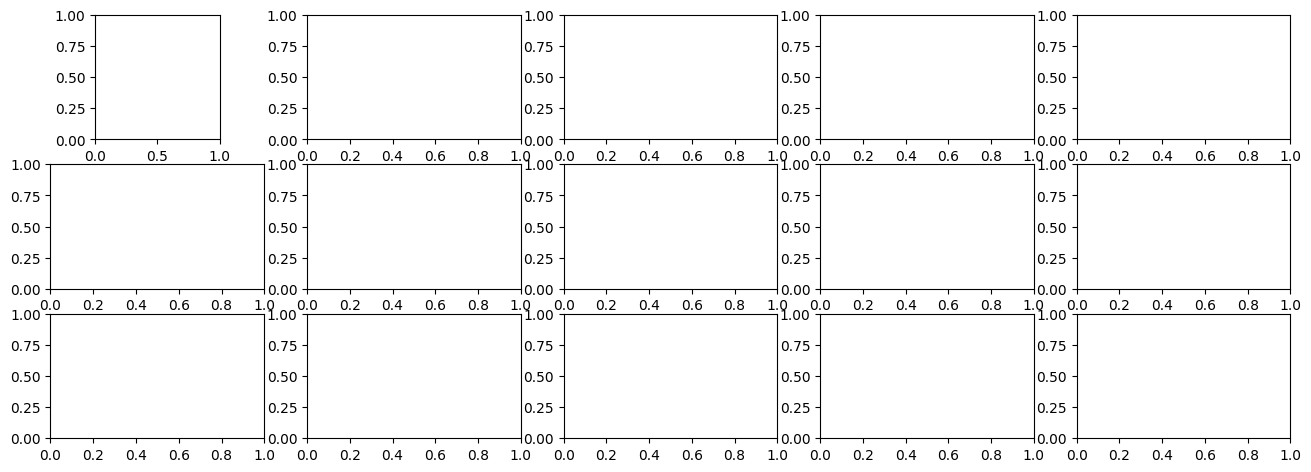

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(train_dataset))
    image, target, target_lengths = train_dataset.__getitem__(random_index)
    ax.imshow(image)
    ax.grid(False)
    ax.set_title(f'{random_index}', fontsize=10)
fig.suptitle('Test captcha examples')
plt.show()

## Defining the CAPTCHA Recognition Model

Implements a Convolutional Recurrent Neural Network (CRNN) with fully connected layers.
Uses a CTC (Connectionist Temporal Classification) loss for sequence-based recognition.

### Architecture 1

In [9]:
class ConvBlock(nn.Module):

    def __init__(self, in_ch, out_ch, ks, stride, padding, dilation=1, pool_ks=None):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_ch)
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ks,
                              stride=stride, padding=padding, dilation=dilation, bias=False)
        self.pooling = nn.MaxPool2d(kernel_size=pool_ks) if pool_ks is not None else None
        self.activation = nn.Hardswish()

    def forward(self, x):
        x = self.conv(self.bn(x))
        if self.pooling:
            x = self.pooling(x)
        x = self.activation(x)
        return x

class CNNImageEncoder(nn.Module):

    """
    This model accept images with size (64x256).
    It reduces the size of H component to 1, so we can use W component as sequence for RNN.
    """

    def __init__(self, out_dim=128, dropout=0.1):
        super().__init__()
        # self.pre_bath_norm = nn.BatchNorm2d(3)
        self.layers = nn.Sequential(
            ConvBlock(3, 32, 9, 1, 4, pool_ks=2),
            ConvBlock(32, 64, 7, 1, 3, pool_ks=2),
            ConvBlock(64, 128, 5, 1, 2, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
        )  # [b, 128, 1, 64]
        self.dropout = nn.Dropout(dropout)
        self.out_net = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        # x = self.pre_bath_norm(x)  # [b, 3, h, w]
        x = self.layers(x)  # [b, ch, 2, w]
        x = x.permute(0, 3, 1, 2)  # [b, w, ch, 2]
        x = x.flatten(-2)  # [b, w, 2*ch]
        x = self.dropout(x)
        x = self.out_net(x)  # [b, 64, out_dim]
        return x

class BiLSTMImageDecoder(nn.Module):

    def __init__(self, in_dim, hidden_dim, vocab_size, lstm_layers, dropout=0.1):
        super().__init__()
        self.norm = nn.BatchNorm1d(64)
        self.rnn = nn.LSTM(in_dim, hidden_dim, num_layers=lstm_layers, dropout=dropout, bidirectional=True,
                           batch_first=False)
        self.out_proj = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = self.norm(x)
        x = x.permute(1, 0, 2)  # [B, T, in_dim] to [T, B, in_dim]
        rnn_out, _ = self.rnn(x)
        x = self.out_proj(rnn_out)
        return x


class OCR_CRNN(nn.Module):

    def __init__(self, vocab_size, hidden_dim=128, lstm_layers=2, dropout=0.1):
        super().__init__()
        self.encoder = CNNImageEncoder(out_dim=hidden_dim, dropout=dropout)
        self.decoder = BiLSTMImageDecoder(in_dim=hidden_dim, hidden_dim=hidden_dim,
                                          vocab_size=vocab_size, lstm_layers=lstm_layers, dropout=dropout)
        self.softmax = nn.LogSoftmax(-1)  # for CTCLoss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.softmax(x)
        return x


### Architecture 2

In [10]:
class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()
        print(conv.shape)
        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        print(conv.shape)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

## Initializing the Model and Loss Function

Moves the model to the appropriate device (CPU/GPU).
Defines the loss function and optimizer.

In [11]:
num_classes = len(CaptchaDataset.LABEL2CHAR)+1
print(num_classes)
model = CRNN(1, img_height=img_height, img_width=img_width, num_class=num_classes).to(device)
model2 = OCR_CRNN(vocab_size=num_classes).to(device)
criterion = nn.CTCLoss(reduction='sum', zero_infinity=True).to(device)
optimizer = torch.optim.AdamW(model2.parameters(), lr = learning_rate)

11


In [12]:
x = torch.randn((1, 3, 64, 256)).to(device)
y = model2(x)
print(y.shape)

torch.Size([64, 1, 11])


## Decoding the Model Predictions
Converts raw model outputs into readable CAPTCHA text.

In [13]:
def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels


def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels

def ctc_decode(log_probs, label2char=None, blank=0):
    emission_log_probs = np.transpose(log_probs.detach().cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = greedy_decode(emission_log_prob, blank=blank)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list

In [14]:
def evaluate_model():
  tot_count = 0
  tot_loss = 0.0
  tot_correct = 0
  for i, sample in tqdm.tqdm(enumerate(val_loader)):
    with torch.no_grad():
      images, targets, target_lengths = [d.to(device) for d in sample]
      logits = model2(images)
      log_probs = nn.functional.log_softmax(logits, dim=2)
      # print(log_probs)
      bs = images.size(0)
      input_lengths = torch.LongTensor([logits.size(0)] * bs)

      loss = criterion(log_probs, targets, input_lengths, target_lengths)

      preds = ctc_decode(log_probs)
      reals = targets.cpu().numpy().tolist()
      # print(target_lengths.shape)
      target_lengths = torch.flatten(target_lengths).cpu().numpy().tolist()
      # print(target_lengths)

      tot_count += bs
      tot_loss += loss.item()
      target_length_counter = 0
      for pred, target_length in zip(preds, target_lengths):
          real = reals[target_length_counter:target_length_counter + target_length]
          target_length_counter += target_length
          # print(pred, real)
          if pred == real:
              tot_correct += 1
  acc = tot_correct/tot_count
  val_loss = tot_loss/ tot_count
  return acc, val_loss


## Training Loop Implementation

Iterates over epochs, processing batches of images.
Computes loss and updates model parameters.
Computes Validation Loss and accuracy at each epoch

In [ ]:
loss_values = []
for epoch in range(num_epochs):
  for i, sample in tqdm.tqdm(enumerate(train_loader)):
    images, targets, target_lengths = [d.to(device) for d in sample]
    # print(images.shape)
    logits = model2(images)
    # log_probs = nn.functional.log_softmax(logits, dim=2)

    bs = images.shape[0]
    input_lengths = torch.full(size=(images.shape[0],), fill_value=logits.shape[0], dtype=torch.long)
    # print(input_lengths)
    target_lengths = torch.flatten(target_lengths)
    # print(target_lengths)

    loss = criterion(logits, targets, input_lengths, target_lengths)
    loss_values.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    if((i+1) % 50 == 0):
      print(f"Epoch = {epoch+1}/{num_epochs}, step = {(i+1)} / {(len(train_dataset) / batch_size)}, loss = {loss.item() / batch_size:.8f}")

  acc, val_loss = evaluate_model()
  print(f"Epoch = {epoch+1}/{num_epochs}, Accuracy = {acc}, Val_loss = {val_loss}")
  torch.save(model, ckpt_path + f"model_{epoch}.pth")



3it [00:10,  3.32s/it]

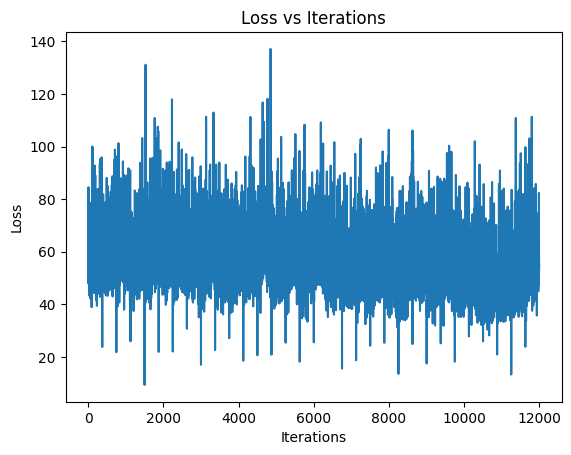

In [ ]:


plt.plot(loss_values)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.show()

In [ ]:
acc = evaluate_model()
print(acc)

16it [00:00, 77.28it/s]

torch.Size([1])
[6]
[6, 2, 9, 6, 9, 5] [6, 1, 1, 6, 9, 5]
torch.Size([1])
[6]
[6, 1, 4, 3, 3, 4] [6, 1, 6, 4, 2, 2]
torch.Size([1])
[6]
[6, 1, 10, 1, 5, 1] [6, 2, 10, 1, 8, 8]
torch.Size([1])
[6]
[7, 1, 8, 4, 2, 10] [6, 1, 8, 5, 1, 7]
torch.Size([1])
[6]
[7, 3, 4, 4, 4, 3] [6, 3, 4, 4, 4, 2]
torch.Size([1])
[6]
[1, 7, 8, 5, 6, 5] [1, 6, 8, 5, 7, 5]
torch.Size([1])
[6]
[6, 3, 4, 9, 3, 7] [6, 3, 3, 10, 3, 7]
torch.Size([1])
[6]
[6, 2, 10, 9, 6, 10] [6, 2, 10, 10, 8, 10]
torch.Size([1])
[6]
[5, 3, 4, 3, 4, 3] [6, 3, 4, 2, 4, 3]
torch.Size([1])
[6]
[6, 2, 7, 5, 10, 10] [6, 2, 7, 6, 9, 10]
torch.Size([1])
[6]
[6, 1, 9, 9, 8, 4] [6, 1, 9, 8, 9, 3]
torch.Size([1])
[6]
[7, 3, 4, 9, 4, 8] [6, 3, 4, 9, 3, 8]
torch.Size([1])
[6]
[6, 1, 10, 9, 5, 9] [6, 1, 10, 9, 6, 8]
torch.Size([1])
[6]
[6, 1, 9, 4, 5, 9] [6, 1, 10, 4, 6, 10]
torch.Size([1])
[6]
[6, 1, 10, 4, 3, 4] [6, 1, 10, 4, 3, 2]
torch.Size([1])
[6]
[6, 2, 5, 2, 2, 7] [6, 2, 5, 1, 2, 6]
torch.Size([1])
[6]
[7, 3, 4, 9, 10, 1] [6, 3, 4, 9, 9

26it [00:00, 84.91it/s]

torch.Size([1])
[6]
[6, 2, 7, 9, 5, 2] [6, 2, 7, 8, 6, 3]
torch.Size([1])
[6]
[6, 2, 3, 6, 4, 7] [6, 2, 3, 7, 4, 8]
torch.Size([1])
[6]
[6, 2, 8, 5, 6, 9] [6, 2, 8, 4, 7, 8]
torch.Size([1])
[6]
[4, 1, 10, 5, 2, 1] [6, 1, 10, 5, 1, 8]
torch.Size([1])
[6]
[7, 2, 5, 3, 7, 10] [6, 2, 4, 2, 8, 10]
torch.Size([1])
[6]
[7, 1, 10, 5, 4, 4] [6, 1, 10, 9, 3, 2]
torch.Size([1])
[6]
[6, 5, 9, 4, 9, 5] [6, 5, 9, 4, 9, 6]
torch.Size([1])
[6]
[6, 4, 7, 5, 7, 6] [6, 4, 7, 5, 8, 6]
torch.Size([1])
[6]
[6, 3, 10, 3, 8, 4] [6, 3, 10, 2, 8, 3]
torch.Size([1])
[6]
[7, 4, 8, 7, 5, 8] [6, 4, 8, 7, 6, 7]
torch.Size([1])
[6]
[6, 5, 5, 3, 7, 4] [6, 5, 5, 2, 7, 4]
torch.Size([1])
[6]
[7, 3, 7, 5, 5, 1] [6, 3, 9, 4, 6, 1]
torch.Size([1])
[6]
[7, 1, 8, 4, 3, 10] [6, 3, 8, 4, 4, 10]
torch.Size([1])
[6]
[6, 5, 10, 2, 6, 8] [6, 5, 9, 1, 8, 9]
torch.Size([1])
[6]
[6, 5, 1, 9, 10, 7] [6, 5, 1, 9, 9, 8]
torch.Size([1])
[6]
[6, 5, 3, 8, 1, 8] [6, 5, 3, 7, 1, 6]
torch.Size([1])
[6]
[6, 5, 3, 6, 2, 7] [6, 5, 1, 6, 4, 6]
to

36it [00:01, 21.66it/s]

torch.Size([1])
[6]
[7, 3, 8, 6, 4, 4] [6, 3, 8, 6, 6, 3]
torch.Size([1])
[6]
[6, 4, 5, 2, 7, 6] [6, 4, 2, 1, 7, 6]
torch.Size([1])
[6]
[7, 3, 8, 10, 9, 10] [6, 3, 8, 10, 10, 10]
torch.Size([1])
[6]
[6, 3, 5, 4, 6, 9] [6, 3, 5, 3, 6, 10]
torch.Size([1])
[6]
[7, 3, 7, 9, 10, 7] [6, 3, 7, 9, 10, 8]
torch.Size([1])
[6]
[6, 5, 2, 6, 3, 6] [6, 5, 2, 7, 3, 5]


42it [00:04,  6.28it/s]

torch.Size([1])
[6]
[6, 5, 4, 8, 2, 4] [6, 5, 6, 9, 2, 3]
torch.Size([1])
[6]
[7, 4, 7, 9, 10, 7] [6, 4, 9, 10, 9, 7]
torch.Size([1])
[6]
[7, 6, 8, 3, 2, 10] [6, 4, 8, 3, 3, 8]
torch.Size([1])
[6]
[1, 6, 9, 4, 7, 2] [1, 6, 9, 3, 8, 3]


46it [00:05,  4.77it/s]

torch.Size([1])
[6]
[6, 6, 5, 9, 8, 6] [6, 6, 5, 10, 7, 5]
torch.Size([1])
[6]
[7, 6, 3, 3, 5, 5] [6, 6, 3, 3, 5, 4]
torch.Size([1])
[6]
[6, 4, 4, 9, 8, 7] [6, 6, 5, 10, 8, 6]


49it [00:08,  3.14it/s]

torch.Size([1])
[6]
[6, 6, 3, 9, 5, 3] [6, 6, 4, 10, 4, 2]
torch.Size([1])
[6]
[1, 7, 1, 3, 2, 7] [1, 7, 2, 2, 1, 8]


51it [00:09,  3.01it/s]

torch.Size([1])
[6]
[6, 6, 2, 4, 1, 3] [6, 6, 2, 6, 2, 2]
torch.Size([1])
[6]
[6, 5, 10, 9, 2, 10] [6, 5, 10, 7, 2, 9]


53it [00:10,  2.52it/s]

torch.Size([1])
[6]
[6, 6, 7, 9, 5, 5] [6, 6, 7, 8, 5, 5]
torch.Size([1])
[6]
[6, 6, 7, 5, 6, 6] [6, 6, 7, 5, 7, 7]


55it [00:11,  2.42it/s]

torch.Size([1])
[6]
[7, 6, 10, 9, 5, 8] [6, 6, 1, 10, 5, 8]
torch.Size([1])
[6]
[6, 6, 8, 3, 3, 1] [6, 6, 8, 3, 2, 1]


57it [00:12,  2.21it/s]

torch.Size([1])
[6]
[6, 6, 10, 1, 1, 6] [6, 6, 8, 1, 1, 6]
torch.Size([1])
[6]
[7, 5, 9, 9, 7, 7] [6, 5, 10, 10, 7, 5]


59it [00:13,  2.28it/s]

torch.Size([1])
[6]
[6, 6, 6, 3, 4, 7] [6, 6, 1, 3, 4, 7]
torch.Size([1])
[6]
[6, 6, 9, 2, 6, 6] [6, 6, 8, 2, 7, 7]


61it [00:14,  2.13it/s]

torch.Size([1])
[6]
[1, 1, 7, 9, 1, 5] [1, 1, 7, 10, 1, 1]
torch.Size([1])
[6]
[6, 6, 6, 6, 5, 6] [6, 6, 6, 6, 6, 6]


63it [00:15,  2.09it/s]

torch.Size([1])
[6]
[6, 6, 3, 3, 3, 7] [6, 7, 1, 2, 3, 7]
torch.Size([1])
[6]
[6, 5, 10, 4, 3, 7] [6, 5, 10, 4, 3, 2]


65it [00:16,  1.97it/s]

torch.Size([1])
[6]
[6, 6, 7, 1, 7, 4] [6, 6, 7, 1, 7, 3]
torch.Size([1])
[6]
[6, 7, 3, 6, 6, 7] [6, 7, 3, 7, 5, 6]


67it [00:17,  1.91it/s]

torch.Size([1])
[6]
[6, 8, 7, 5, 9, 6] [6, 8, 7, 7, 9, 5]
torch.Size([1])
[6]
[6, 7, 10, 5, 3, 6] [6, 7, 9, 5, 2, 6]


69it [00:19,  1.72it/s]

torch.Size([1])
[6]
[6, 8, 3, 3, 6, 5] [6, 8, 3, 2, 6, 5]
torch.Size([1])
[6]
[6, 7, 5, 4, 8, 7] [6, 7, 5, 3, 7, 7]


71it [00:20,  1.61it/s]

torch.Size([1])
[6]
[6, 7, 5, 9, 4, 8] [6, 7, 5, 9, 4, 7]
torch.Size([1])
[6]
[6, 8, 3, 3, 5, 4] [6, 8, 3, 2, 5, 2]


73it [00:21,  1.63it/s]

torch.Size([1])
[6]
[7, 8, 7, 7, 8, 3] [6, 8, 5, 7, 8, 2]
torch.Size([1])
[6]
[6, 8, 7, 5, 8, 2] [6, 8, 7, 6, 8, 1]


75it [00:23,  1.54it/s]

torch.Size([1])
[6]
[6, 8, 3, 5, 4, 6] [6, 8, 3, 5, 4, 5]
torch.Size([1])
[6]
[6, 8, 3, 7, 5, 9] [6, 8, 3, 9, 5, 9]


77it [00:24,  1.47it/s]

torch.Size([1])
[6]
[6, 8, 7, 9, 3, 1] [6, 8, 1, 9, 3, 3]
torch.Size([1])
[6]
[1, 8, 2, 8, 5, 1] [1, 7, 2, 8, 7, 1]


79it [00:25,  1.66it/s]

torch.Size([1])
[6]
[6, 8, 2, 6, 3, 2] [6, 8, 2, 6, 3, 1]
torch.Size([1])
[6]
[3, 7, 3, 9, 1, 8] [1, 7, 3, 10, 1, 6]


81it [00:26,  1.77it/s]

torch.Size([1])
[6]
[6, 7, 8, 1, 3, 7] [6, 7, 4, 1, 3, 6]
torch.Size([1])
[6]
[6, 8, 5, 5, 4, 5] [6, 8, 5, 5, 4, 5]


83it [00:27,  1.73it/s]

torch.Size([1])
[6]
[4, 7, 7, 1, 2, 4] [6, 8, 7, 2, 2, 9]
torch.Size([1])
[6]
[6, 8, 5, 9, 5, 8] [6, 8, 5, 10, 5, 8]


85it [00:28,  1.90it/s]

torch.Size([1])
[6]
[6, 7, 4, 6, 10, 5] [6, 7, 4, 6, 10, 3]
torch.Size([1])
[6]
[6, 6, 7, 6, 3, 5] [6, 7, 7, 6, 3, 4]


87it [00:29,  2.06it/s]

torch.Size([1])
[6]
[6, 8, 7, 8, 5, 7] [6, 8, 7, 8, 6, 7]
torch.Size([1])
[6]
[6, 9, 4, 9, 8, 8] [6, 9, 4, 9, 8, 8]


89it [00:30,  1.84it/s]

torch.Size([1])
[6]
[1, 7, 9, 2, 3, 6] [1, 7, 7, 2, 3, 4]
torch.Size([1])
[6]
[6, 7, 8, 2, 7, 6] [6, 9, 8, 3, 8, 5]


91it [00:31,  1.81it/s]

torch.Size([1])
[6]
[6, 7, 10, 5, 3, 4] [6, 9, 9, 7, 3, 3]
torch.Size([1])
[6]
[2, 7, 4, 8, 10, 9] [1, 7, 6, 8, 10, 10]


93it [00:32,  2.00it/s]

torch.Size([1])
[6]
[6, 8, 10, 4, 7, 7] [6, 8, 10, 4, 8, 8]
torch.Size([1])
[6]
[4, 10, 2, 5, 5, 2] [6, 10, 2, 5, 4, 2]


95it [00:33,  2.16it/s]

torch.Size([1])
[6]
[6, 9, 3, 9, 6, 5] [6, 9, 3, 10, 5, 5]
torch.Size([1])
[6]
[6, 10, 3, 3, 9, 4] [6, 10, 3, 3, 10, 4]


97it [00:34,  1.83it/s]

torch.Size([1])
[6]
[6, 9, 4, 5, 3, 7] [6, 9, 4, 7, 3, 6]
torch.Size([1])
[6]
[6, 9, 4, 2, 5, 9] [6, 9, 3, 3, 6, 10]


99it [00:36,  1.82it/s]

torch.Size([1])
[6]
[6, 9, 1, 8, 3, 6] [6, 9, 1, 8, 4, 7]
torch.Size([1])
[6]
[6, 9, 10, 2, 7, 5] [6, 9, 10, 3, 7, 4]


101it [00:36,  1.99it/s]

torch.Size([1])
[6]
[6, 8, 10, 4, 9, 7] [6, 8, 10, 3, 9, 7]
torch.Size([1])
[6]
[6, 9, 10, 9, 8, 7] [6, 9, 10, 9, 8, 6]


103it [00:37,  2.09it/s]

torch.Size([1])
[6]
[6, 9, 4, 5, 7, 9] [6, 9, 4, 5, 8, 9]
torch.Size([1])
[6]
[6, 10, 3, 3, 7, 6] [6, 10, 3, 3, 8, 8]


105it [00:38,  2.19it/s]

torch.Size([1])
[6]
[6, 7, 10, 6, 9, 10] [6, 8, 9, 6, 10, 10]
torch.Size([1])
[6]
[3, 10, 1, 6, 9, 4] [6, 10, 1, 4, 10, 3]


107it [00:39,  2.28it/s]

torch.Size([1])
[6]
[6, 8, 10, 2, 3, 4] [6, 8, 10, 1, 4, 3]
torch.Size([1])
[6]
[6, 9, 8, 3, 4, 7] [6, 9, 8, 3, 4, 6]


109it [00:40,  2.27it/s]

torch.Size([1])
[6]
[6, 10, 4, 8, 4, 5] [6, 10, 4, 7, 1, 5]
torch.Size([1])
[6]
[7, 1, 2, 3, 6, 5] [7, 1, 2, 3, 7, 5]


112it [00:41,  2.62it/s]

torch.Size([1])
[6]
[7, 2, 9, 3, 2, 8] [7, 2, 1, 2, 1, 8]
torch.Size([1])
[6]
[6, 10, 5, 4, 7, 3] [6, 10, 5, 3, 7, 3]


113it [00:42,  1.74it/s]

torch.Size([1])
[6]
[7, 1, 7, 2, 9, 3] [7, 1, 7, 2, 9, 3]
torch.Size([1])
[6]
[6, 10, 6, 4, 5, 4] [6, 10, 6, 4, 4, 3]


115it [00:43,  1.95it/s]

torch.Size([1])
[6]
[7, 1, 8, 9, 5, 7] [7, 1, 10, 10, 3, 3]


116it [00:43,  2.23it/s]

torch.Size([1])
[6]
[7, 5, 8, 7, 7, 1] [7, 2, 2, 7, 8, 1]


117it [00:44,  2.10it/s]

torch.Size([1])
[6]
[3, 10, 10, 5, 5, 9] [6, 10, 8, 5, 3, 10]


118it [00:44,  2.41it/s]

torch.Size([1])
[6]
[9, 1, 6, 5, 7, 6] [7, 1, 6, 5, 7, 6]


119it [00:45,  1.60it/s]

torch.Size([1])
[6]
[2, 7, 9, 3, 4, 7] [1, 7, 7, 2, 5, 10]


120it [00:45,  1.80it/s]

torch.Size([1])
[6]
[1, 7, 7, 9, 4, 2] [1, 7, 7, 8, 5, 5]


121it [00:46,  1.85it/s]

torch.Size([1])
[6]
[7, 1, 10, 2, 5, 10] [7, 1, 4, 1, 5, 8]


122it [00:46,  2.16it/s]

torch.Size([1])
[6]
[7, 1, 10, 4, 4, 7] [7, 1, 9, 5, 4, 7]


123it [00:47,  2.08it/s]

torch.Size([1])
[6]
[6, 1, 4, 4, 2, 6] [7, 1, 1, 4, 2, 6]


124it [00:47,  2.37it/s]

torch.Size([1])
[6]
[7, 1, 8, 8, 3, 7] [7, 1, 6, 8, 1, 7]


125it [00:48,  1.82it/s]

torch.Size([1])
[6]
[6, 10, 9, 5, 2, 5] [6, 10, 9, 5, 2, 3]
torch.Size([1])
[6]
[6, 10, 4, 8, 7, 7] [6, 10, 4, 8, 8, 8]


128it [00:49,  2.61it/s]

torch.Size([1])
[6]
[7, 2, 1, 4, 5, 2] [7, 2, 1, 4, 5, 1]
torch.Size([1])
[6]
[3, 10, 10, 6, 6, 9] [6, 10, 10, 6, 8, 10]


129it [00:49,  2.20it/s]

torch.Size([1])
[6]
[1, 7, 9, 4, 6, 3] [1, 7, 7, 3, 6, 4]


130it [00:50,  2.57it/s]

torch.Size([1])
[6]
[7, 1, 8, 6, 2, 10] [7, 1, 8, 7, 1, 10]


131it [00:50,  2.19it/s]

torch.Size([1])
[6]
[7, 10, 4, 9, 7, 6] [6, 10, 4, 9, 7, 8]


132it [00:51,  1.81it/s]

torch.Size([1])
[6]
[7, 2, 8, 3, 3, 1] [7, 2, 8, 3, 4, 2]


134it [00:52,  2.22it/s]

torch.Size([1])
[6]
[7, 3, 2, 9, 4, 7] [7, 3, 2, 9, 4, 6]
torch.Size([1])
[6]
[7, 3, 4, 8, 4, 3] [7, 3, 3, 7, 4, 2]


135it [00:53,  1.60it/s]

torch.Size([1])
[6]
[7, 3, 2, 9, 9, 7] [7, 3, 2, 9, 9, 9]
torch.Size([1])
[6]
[9, 4, 2, 1, 10, 3] [7, 4, 2, 1, 10, 3]


137it [00:54,  1.46it/s]

torch.Size([1])
[6]
[7, 2, 9, 6, 10, 10] [7, 2, 8, 6, 10, 10]
torch.Size([1])
[6]
[1, 4, 10, 5, 1, 9] [1, 7, 10, 5, 1, 9]


139it [00:55,  1.72it/s]

torch.Size([1])
[6]
[7, 3, 10, 4, 2, 7] [7, 3, 10, 4, 1, 5]
torch.Size([1])
[6]
[7, 3, 4, 4, 7, 10] [7, 3, 4, 4, 7, 10]


141it [00:56,  1.94it/s]

torch.Size([1])
[6]
[1, 6, 9, 3, 3, 7] [1, 7, 9, 5, 3, 6]
torch.Size([1])
[6]
[7, 3, 8, 4, 3, 7] [7, 3, 8, 6, 2, 4]


143it [00:57,  1.74it/s]

torch.Size([1])
[6]
[7, 3, 7, 6, 3, 8] [7, 2, 7, 8, 9, 8]
torch.Size([1])
[6]
[7, 3, 7, 4, 8, 6] [7, 3, 7, 4, 9, 6]


145it [00:58,  1.96it/s]

torch.Size([1])
[6]
[7, 3, 4, 8, 5, 9] [7, 3, 3, 8, 4, 10]
torch.Size([1])
[6]
[7, 3, 7, 3, 6, 4] [7, 3, 7, 2, 7, 5]


147it [01:00,  1.72it/s]

torch.Size([1])
[6]
[7, 3, 4, 8, 4, 6] [7, 3, 4, 8, 4, 7]
torch.Size([1])
[6]
[9, 4, 2, 8, 8, 4] [7, 4, 2, 8, 8, 4]


149it [01:00,  1.90it/s]

torch.Size([1])
[6]
[1, 8, 10, 3, 3, 5] [1, 7, 10, 1, 3, 4]
torch.Size([1])
[6]
[9, 4, 4, 9, 9, 6] [7, 2, 4, 9, 9, 8]


151it [01:01,  2.05it/s]

torch.Size([1])
[6]
[7, 3, 8, 1, 3, 2] [7, 3, 8, 1, 4, 9]
torch.Size([1])
[6]
[7, 3, 7, 4, 10, 6] [7, 3, 5, 4, 10, 6]


153it [01:02,  1.88it/s]

torch.Size([1])
[6]
[6, 2, 9, 7, 8, 4] [7, 2, 9, 7, 7, 3]
torch.Size([1])
[6]
[7, 4, 9, 8, 7, 6] [7, 4, 9, 8, 7, 7]


155it [01:04,  1.85it/s]

torch.Size([1])
[6]
[7, 4, 5, 4, 10, 7] [7, 4, 5, 3, 10, 9]
torch.Size([1])
[6]
[7, 2, 6, 9, 1, 2] [7, 4, 6, 10, 1, 1]


157it [01:04,  2.02it/s]

torch.Size([1])
[6]
[6, 5, 3, 6, 2, 6] [7, 5, 2, 6, 2, 7]
torch.Size([1])
[6]
[7, 4, 10, 3, 6, 7] [7, 4, 8, 3, 7, 9]


159it [01:05,  2.14it/s]

torch.Size([1])
[6]
[7, 4, 6, 3, 7, 4] [7, 4, 6, 2, 7, 4]
torch.Size([1])
[6]
[1, 8, 10, 4, 3, 1] [1, 8, 1, 3, 3, 3]


161it [01:07,  1.85it/s]

torch.Size([1])
[6]
[7, 4, 8, 5, 7, 4] [7, 4, 8, 7, 8, 2]
torch.Size([1])
[6]
[7, 5, 3, 9, 10, 7] [7, 5, 3, 9, 9, 9]


163it [01:07,  2.02it/s]

torch.Size([1])
[6]
[7, 4, 10, 8, 3, 7] [7, 4, 10, 8, 3, 5]
torch.Size([1])
[6]
[7, 4, 9, 6, 9, 4] [7, 4, 9, 6, 9, 2]


165it [01:08,  2.11it/s]

torch.Size([1])
[6]
[7, 5, 2, 4, 1, 6] [7, 5, 2, 5, 1, 5]
torch.Size([1])
[6]
[7, 5, 4, 6, 6, 9] [7, 5, 4, 7, 5, 10]


167it [01:10,  1.89it/s]

torch.Size([1])
[6]
[7, 5, 6, 10, 4, 7] [7, 5, 6, 10, 4, 7]
torch.Size([1])
[6]
[7, 4, 9, 9, 3, 7] [7, 4, 9, 9, 5, 8]


169it [01:11,  1.67it/s]

torch.Size([1])
[6]
[7, 4, 5, 10, 3, 7] [7, 4, 5, 10, 3, 7]
torch.Size([1])
[6]
[7, 4, 1, 3, 3, 5] [7, 4, 3, 3, 2, 9]


171it [01:12,  1.85it/s]

torch.Size([1])
[6]
[7, 1, 6, 3, 9, 4] [7, 5, 6, 2, 10, 3]
torch.Size([1])
[6]
[7, 4, 10, 5, 5, 6] [7, 4, 10, 5, 5, 6]


173it [01:13,  1.96it/s]

torch.Size([1])
[6]
[1, 8, 5, 5, 3, 7] [1, 8, 2, 2, 4, 5]
torch.Size([1])
[6]
[7, 4, 8, 5, 7, 6] [7, 4, 8, 5, 7, 6]


175it [01:14,  1.73it/s]

torch.Size([1])
[6]
[7, 6, 6, 3, 7, 4] [7, 6, 6, 3, 7, 5]
torch.Size([1])
[6]
[7, 5, 7, 2, 3, 5] [7, 5, 7, 2, 4, 8]


177it [01:15,  1.85it/s]

torch.Size([1])
[6]
[7, 5, 10, 1, 8, 6] [7, 5, 10, 1, 9, 6]
torch.Size([1])
[6]
[7, 6, 5, 8, 9, 8] [7, 6, 5, 8, 9, 9]


179it [01:17,  1.70it/s]

torch.Size([1])
[6]
[7, 1, 10, 7, 7, 2] [7, 5, 10, 7, 8, 1]
torch.Size([1])
[6]
[7, 6, 4, 7, 5, 10] [7, 6, 4, 7, 4, 9]


181it [01:17,  1.91it/s]

torch.Size([1])
[6]
[7, 6, 10, 7, 4, 5] [7, 6, 10, 7, 4, 4]
torch.Size([1])
[6]
[1, 1, 10, 5, 8, 10] [1, 1, 10, 5, 8, 10]


183it [01:18,  1.83it/s]

torch.Size([1])
[6]
[7, 6, 9, 4, 3, 10] [7, 6, 9, 4, 4, 10]
torch.Size([1])
[6]
[7, 6, 3, 7, 6, 6] [7, 6, 3, 7, 7, 6]


185it [01:19,  1.98it/s]

torch.Size([1])
[6]
[7, 5, 7, 7, 10, 10] [7, 5, 7, 8, 10, 10]
torch.Size([1])
[6]
[7, 6, 2, 8, 5, 4] [7, 6, 2, 6, 6, 4]


187it [01:21,  1.76it/s]

torch.Size([1])
[6]
[1, 8, 5, 2, 4, 10] [1, 8, 4, 1, 5, 10]
torch.Size([1])
[6]
[7, 6, 9, 4, 3, 5] [7, 6, 9, 3, 3, 5]


189it [01:22,  1.92it/s]

torch.Size([1])
[6]
[7, 6, 10, 9, 8, 5] [7, 6, 10, 9, 9, 9]
torch.Size([1])
[6]
[7, 6, 4, 9, 4, 7] [7, 6, 3, 10, 4, 7]


191it [01:22,  2.05it/s]

torch.Size([1])
[6]
[1, 8, 5, 8, 10, 1] [1, 8, 3, 7, 8, 1]
torch.Size([1])
[6]
[7, 6, 5, 9, 6, 1] [7, 6, 1, 9, 7, 2]


193it [01:23,  2.28it/s]

torch.Size([1])
[6]
[7, 5, 8, 8, 3, 3] [7, 5, 8, 8, 3, 1]
torch.Size([1])
[6]
[7, 6, 9, 6, 7, 6] [7, 6, 9, 6, 7, 7]


195it [01:24,  1.92it/s]

torch.Size([1])
[6]
[7, 7, 4, 6, 2, 6] [7, 7, 3, 7, 1, 5]
torch.Size([1])
[6]
[7, 6, 5, 3, 8, 1] [7, 6, 5, 2, 9, 1]


197it [01:25,  2.02it/s]

torch.Size([1])
[6]
[7, 6, 5, 3, 4, 1] [7, 6, 5, 2, 3, 1]
torch.Size([1])
[6]
[7, 8, 1, 3, 4, 3] [7, 8, 1, 2, 4, 1]


199it [01:26,  2.14it/s]

torch.Size([1])
[6]
[7, 7, 10, 9, 10, 7] [7, 7, 10, 9, 10, 6]
torch.Size([1])
[6]
[7, 2, 10, 4, 2, 7] [7, 8, 5, 3, 1, 7]


201it [01:27,  2.21it/s]

torch.Size([1])
[6]
[9, 9, 1, 3, 10, 5] [7, 9, 1, 3, 10, 5]
torch.Size([1])
[6]
[7, 7, 8, 3, 8, 6] [7, 7, 8, 3, 8, 6]


204it [01:28,  2.57it/s]

torch.Size([1])
[6]
[7, 8, 8, 10, 4, 4] [7, 8, 8, 10, 3, 6]
torch.Size([1])
[6]
[7, 7, 8, 2, 9, 1] [7, 7, 8, 1, 10, 2]


205it [01:29,  2.16it/s]

torch.Size([1])
[6]
[7, 7, 4, 3, 9, 8] [7, 7, 4, 2, 9, 8]
torch.Size([1])
[6]
[7, 9, 6, 3, 8, 3] [7, 7, 6, 3, 8, 3]


207it [01:29,  2.27it/s]

torch.Size([1])
[6]
[7, 8, 4, 9, 8, 5] [7, 8, 4, 8, 9, 6]


209it [01:30,  2.46it/s]

torch.Size([1])
[6]
[7, 8, 9, 2, 2, 7] [7, 8, 7, 2, 3, 6]
torch.Size([1])
[6]
[7, 8, 8, 4, 3, 4] [7, 8, 8, 3, 4, 4]


210it [01:31,  2.13it/s]

torch.Size([1])
[6]
[7, 8, 1, 4, 7, 4] [7, 8, 1, 3, 8, 5]
torch.Size([1])
[6]
[7, 7, 5, 8, 1, 4] [7, 7, 5, 9, 1, 3]


212it [01:32,  2.30it/s]

torch.Size([1])
[6]
[7, 7, 7, 1, 4, 10] [7, 7, 7, 1, 4, 10]


214it [01:33,  2.42it/s]

torch.Size([1])
[6]
[7, 7, 10, 9, 3, 7] [7, 7, 8, 9, 4, 7]
torch.Size([1])
[6]
[7, 8, 8, 8, 5, 8] [7, 8, 8, 8, 6, 7]


215it [01:33,  2.16it/s]

torch.Size([1])
[6]
[7, 8, 7, 1, 6, 8] [7, 7, 7, 1, 7, 10]


216it [01:34,  1.84it/s]

torch.Size([1])
[6]
[7, 8, 6, 5, 5, 5] [7, 8, 6, 5, 6, 4]
torch.Size([1])
[6]
[7, 6, 9, 8, 6, 8] [7, 7, 9, 8, 6, 8]


218it [01:35,  2.05it/s]

torch.Size([1])
[6]
[1, 8, 6, 8, 1, 5] [1, 8, 4, 8, 1, 6]


219it [01:35,  2.18it/s]

torch.Size([1])
[6]
[7, 8, 6, 5, 6, 7] [7, 8, 6, 4, 7, 8]


220it [01:36,  1.92it/s]

torch.Size([1])
[6]
[7, 9, 4, 4, 7, 9] [7, 9, 2, 4, 10, 9]
torch.Size([1])
[6]
[7, 8, 2, 10, 7, 7] [7, 8, 2, 10, 7, 8]


222it [01:37,  2.10it/s]

torch.Size([1])
[6]
[9, 1, 5, 1, 1, 7] [8, 1, 2, 1, 1, 6]


223it [01:37,  1.95it/s]

torch.Size([1])
[6]
[7, 9, 8, 8, 1, 4] [7, 9, 8, 8, 2, 3]


224it [01:38,  1.70it/s]

torch.Size([1])
[6]
[6, 9, 7, 6, 2, 10] [7, 9, 7, 7, 3, 10]
torch.Size([1])
[6]
[8, 1, 4, 2, 9, 9] [8, 1, 4, 1, 10, 8]


226it [01:39,  1.99it/s]

torch.Size([1])
[6]
[9, 9, 2, 8, 9, 7] [7, 9, 2, 9, 10, 6]
torch.Size([1])
[6]
[7, 10, 7, 3, 7, 2] [7, 10, 7, 1, 7, 2]


228it [01:40,  2.16it/s]

torch.Size([1])
[6]
[7, 7, 8, 9, 6, 5] [7, 9, 8, 10, 7, 3]


229it [01:40,  2.45it/s]

torch.Size([1])
[6]
[7, 9, 4, 8, 8, 3] [7, 9, 3, 6, 9, 2]


230it [01:41,  1.93it/s]

torch.Size([1])
[6]
[7, 10, 3, 2, 9, 9] [7, 10, 3, 1, 9, 10]
torch.Size([1])
[6]
[7, 10, 7, 7, 9, 4] [7, 10, 7, 7, 9, 3]


232it [01:42,  2.07it/s]

torch.Size([1])
[6]
[7, 1, 4, 9, 2, 6] [8, 1, 4, 10, 2, 6]
torch.Size([1])
[6]
[6, 9, 5, 2, 1, 6] [7, 9, 5, 1, 1, 4]


234it [01:42,  2.23it/s]

torch.Size([1])
[6]
[1, 8, 9, 1, 1, 5] [1, 8, 8, 1, 1, 4]
torch.Size([1])
[6]
[8, 1, 7, 1, 3, 7] [8, 1, 5, 1, 3, 7]


236it [01:43,  2.26it/s]

torch.Size([1])
[6]
[7, 9, 4, 5, 8, 6] [7, 9, 3, 5, 9, 5]


237it [01:44,  2.11it/s]

torch.Size([1])
[6]
[10, 1, 4, 5, 9, 4] [8, 1, 4, 6, 9, 2]


238it [01:44,  2.37it/s]

torch.Size([1])
[6]
[1, 8, 7, 9, 7, 1] [1, 8, 7, 9, 8, 1]


239it [01:44,  2.38it/s]

torch.Size([1])
[6]
[7, 10, 1, 8, 5, 4] [7, 10, 1, 8, 5, 5]


240it [01:45,  2.55it/s]

torch.Size([1])
[6]
[7, 7, 7, 9, 7, 2] [7, 9, 10, 10, 7, 10]


241it [01:46,  2.03it/s]

torch.Size([1])
[6]
[7, 9, 6, 1, 8, 6] [7, 9, 6, 1, 9, 7]


242it [01:46,  2.24it/s]

torch.Size([1])
[6]
[8, 3, 6, 9, 9, 4] [8, 3, 4, 9, 8, 4]


243it [01:47,  1.57it/s]

torch.Size([1])
[6]
[8, 2, 9, 9, 5, 5] [8, 2, 9, 9, 8, 9]
torch.Size([1])
[6]
[8, 2, 3, 4, 10, 4] [8, 2, 3, 4, 9, 2]


245it [01:48,  1.91it/s]

torch.Size([1])
[6]
[9, 2, 3, 2, 5, 4] [8, 2, 2, 2, 6, 3]
torch.Size([1])
[6]
[8, 1, 10, 4, 2, 4] [8, 1, 8, 5, 3, 5]


247it [01:48,  2.28it/s]

torch.Size([1])
[6]
[8, 1, 6, 9, 7, 5] [8, 1, 10, 10, 8, 5]


248it [01:49,  2.54it/s]

torch.Size([1])
[6]
[8, 2, 3, 9, 8, 5] [8, 2, 3, 9, 7, 4]


249it [01:49,  2.34it/s]

torch.Size([1])
[6]
[8, 2, 3, 5, 8, 6] [8, 2, 3, 6, 8, 7]


250it [01:49,  2.64it/s]

torch.Size([1])
[6]
[8, 2, 10, 4, 5, 7] [8, 1, 10, 5, 5, 6]


251it [01:50,  1.93it/s]

torch.Size([1])
[6]
[8, 3, 4, 2, 9, 5] [8, 3, 4, 1, 9, 5]
torch.Size([1])
[6]
[8, 2, 1, 4, 3, 9] [8, 2, 2, 6, 2, 7]


253it [01:51,  2.07it/s]

torch.Size([1])
[6]
[9, 2, 3, 5, 6, 9] [8, 2, 3, 3, 7, 8]
torch.Size([1])
[6]
[9, 3, 10, 3, 6, 7] [8, 3, 1, 2, 6, 8]


255it [01:53,  1.74it/s]

torch.Size([1])
[6]
[8, 2, 7, 9, 3, 7] [8, 2, 9, 10, 2, 6]
torch.Size([1])
[6]
[1, 8, 9, 3, 3, 3] [1, 8, 10, 3, 2, 2]


257it [01:54,  1.61it/s]

torch.Size([1])
[6]
[8, 6, 5, 5, 6, 4] [8, 3, 2, 2, 7, 5]
torch.Size([1])
[6]
[8, 2, 7, 5, 7, 5] [8, 2, 7, 5, 8, 5]


259it [01:55,  1.65it/s]

torch.Size([1])
[6]
[9, 4, 1, 8, 6, 5] [8, 3, 1, 8, 6, 7]
torch.Size([1])
[6]
[1, 10, 3, 8, 3, 6] [8, 3, 1, 4, 2, 7]


261it [01:56,  1.78it/s]

torch.Size([1])
[6]
[1, 9, 2, 5, 5, 4] [1, 9, 1, 5, 5, 6]
torch.Size([1])
[6]
[8, 4, 1, 3, 5, 4] [8, 4, 1, 1, 5, 5]


263it [01:57,  1.95it/s]

torch.Size([1])
[6]
[8, 4, 1, 6, 5, 4] [8, 5, 1, 6, 5, 4]
torch.Size([1])
[6]
[10, 3, 8, 9, 9, 9] [8, 4, 8, 10, 8, 8]


265it [01:58,  1.86it/s]

torch.Size([1])
[6]
[8, 1, 10, 4, 5, 5] [8, 4, 10, 4, 5, 4]
torch.Size([1])
[6]
[8, 4, 6, 3, 5, 3] [8, 4, 6, 2, 4, 2]


267it [01:59,  2.02it/s]

torch.Size([1])
[6]
[9, 4, 8, 2, 3, 6] [8, 4, 8, 2, 4, 6]
torch.Size([1])
[6]
[8, 6, 3, 4, 5, 3] [8, 4, 3, 3, 4, 3]


269it [02:00,  2.14it/s]

torch.Size([1])
[6]
[8, 5, 3, 3, 7, 6] [8, 5, 3, 2, 7, 6]
torch.Size([1])
[6]
[9, 4, 7, 8, 10, 10] [8, 4, 8, 8, 9, 10]


271it [02:01,  2.22it/s]

torch.Size([1])
[6]
[8, 4, 10, 3, 1, 4] [8, 4, 10, 4, 1, 5]
torch.Size([1])
[6]
[8, 7, 4, 5, 9, 4] [8, 5, 3, 5, 9, 7]


273it [02:02,  1.87it/s]

torch.Size([1])
[6]
[8, 4, 5, 3, 3, 1] [8, 4, 4, 1, 3, 1]
torch.Size([1])
[6]
[8, 6, 6, 3, 10, 7] [8, 4, 4, 1, 10, 7]


275it [02:03,  2.05it/s]

torch.Size([1])
[6]
[8, 4, 5, 10, 9, 4] [8, 4, 5, 10, 10, 4]
torch.Size([1])
[6]
[8, 5, 3, 5, 10, 1] [8, 5, 1, 1, 10, 3]


277it [02:04,  2.17it/s]

torch.Size([1])
[6]
[8, 4, 4, 9, 8, 6] [8, 4, 4, 7, 7, 5]
torch.Size([1])
[6]
[8, 3, 7, 5, 5, 2] [8, 3, 5, 5, 6, 2]


280it [02:05,  2.55it/s]

torch.Size([1])
[6]
[8, 4, 5, 8, 4, 4] [8, 4, 5, 8, 3, 3]
torch.Size([1])
[6]
[8, 5, 4, 4, 9, 4] [8, 5, 4, 4, 8, 6]


282it [02:05,  2.61it/s]

torch.Size([1])
[6]
[8, 7, 7, 9, 8, 6] [8, 7, 4, 9, 9, 10]
torch.Size([1])
[6]
[8, 7, 7, 3, 5, 9] [8, 7, 7, 4, 6, 6]


283it [02:06,  2.24it/s]

torch.Size([1])
[6]
[8, 7, 1, 6, 3, 10] [8, 7, 1, 6, 2, 9]


284it [02:07,  1.79it/s]

torch.Size([1])
[6]
[1, 9, 2, 8, 7, 9] [1, 9, 2, 9, 8, 10]
torch.Size([1])
[6]
[8, 6, 1, 4, 8, 5] [8, 6, 1, 2, 7, 2]


286it [02:08,  2.04it/s]

torch.Size([1])
[6]
[8, 6, 7, 4, 2, 7] [8, 6, 1, 4, 4, 7]


287it [02:08,  1.92it/s]

torch.Size([1])
[6]
[7, 6, 4, 7, 2, 6] [8, 6, 4, 10, 1, 5]


289it [02:09,  2.24it/s]

torch.Size([1])
[6]
[8, 1, 6, 4, 2, 3] [8, 7, 6, 4, 1, 1]
torch.Size([1])
[6]
[8, 6, 5, 7, 6, 4] [8, 6, 4, 7, 6, 3]


290it [02:10,  2.05it/s]

torch.Size([1])
[6]
[8, 5, 6, 3, 1, 6] [8, 5, 6, 2, 3, 5]


291it [02:10,  2.42it/s]

torch.Size([1])
[6]
[8, 6, 5, 7, 7, 7] [8, 6, 4, 6, 8, 7]


292it [02:10,  2.13it/s]

torch.Size([1])
[6]
[8, 7, 6, 7, 7, 4] [8, 7, 6, 7, 7, 4]


293it [02:11,  2.17it/s]

torch.Size([1])
[6]
[8, 6, 3, 5, 2, 1] [8, 6, 3, 5, 1, 1]


294it [02:11,  2.29it/s]

torch.Size([1])
[6]
[8, 6, 9, 8, 6, 4] [8, 6, 9, 8, 5, 10]


295it [02:12,  1.93it/s]

torch.Size([1])
[6]
[8, 5, 6, 9, 1, 6] [8, 5, 6, 10, 1, 6]


296it [02:13,  1.74it/s]

torch.Size([1])
[6]
[8, 6, 1, 3, 6, 5] [8, 6, 1, 3, 6, 5]
torch.Size([1])
[6]
[1, 9, 2, 4, 5, 1] [1, 9, 4, 10, 9, 2]


298it [02:13,  2.07it/s]

torch.Size([1])
[6]
[1, 9, 10, 3, 6, 5] [1, 9, 2, 9, 7, 5]


299it [02:14,  1.86it/s]

torch.Size([1])
[6]
[8, 6, 7, 9, 5, 4] [8, 6, 7, 9, 5, 3]


300it [02:15,  1.67it/s]

torch.Size([1])
[6]
[8, 7, 9, 4, 2, 10] [8, 5, 9, 5, 1, 10]


302it [02:16,  2.05it/s]

torch.Size([1])
[6]
[8, 9, 3, 9, 10, 9] [8, 9, 3, 8, 10, 9]
torch.Size([1])
[6]
[8, 8, 6, 3, 4, 7] [8, 8, 4, 3, 4, 6]


303it [02:17,  1.67it/s]

torch.Size([1])
[6]
[9, 8, 6, 7, 3, 6] [8, 8, 4, 8, 3, 6]


304it [02:17,  1.94it/s]

torch.Size([1])
[6]
[8, 8, 10, 9, 3, 7] [8, 8, 10, 10, 9, 7]


305it [02:18,  1.43it/s]

torch.Size([1])
[6]
[9, 7, 3, 2, 3, 4] [8, 9, 2, 2, 2, 3]


306it [02:18,  1.69it/s]

torch.Size([1])
[6]
[8, 8, 10, 7, 3, 4] [8, 8, 5, 5, 2, 2]


307it [02:19,  1.84it/s]

torch.Size([1])
[6]
[8, 8, 7, 4, 7, 8] [8, 8, 1, 4, 6, 8]


308it [02:20,  1.47it/s]

torch.Size([1])
[6]
[7, 10, 5, 10, 1, 6] [8, 9, 4, 10, 2, 8]


309it [02:20,  1.61it/s]

torch.Size([1])
[6]
[8, 7, 6, 9, 9, 6] [8, 7, 8, 10, 9, 6]


310it [02:21,  1.60it/s]

torch.Size([1])
[6]
[8, 8, 5, 5, 6, 5] [8, 8, 5, 7, 8, 8]


311it [02:21,  1.95it/s]

torch.Size([1])
[6]
[8, 8, 5, 9, 2, 7] [8, 8, 4, 9, 2, 8]


312it [02:22,  1.95it/s]

torch.Size([1])
[6]
[6, 9, 8, 2, 7, 7] [8, 9, 6, 1, 2, 6]


313it [02:22,  2.19it/s]

torch.Size([1])
[6]
[8, 7, 9, 1, 2, 5] [8, 7, 9, 1, 3, 5]


314it [02:23,  1.77it/s]

torch.Size([1])
[6]
[8, 9, 4, 4, 8, 1] [8, 9, 4, 3, 8, 2]
torch.Size([1])
[6]
[8, 7, 3, 8, 1, 7] [8, 9, 2, 8, 2, 9]


316it [02:26,  1.09s/it]

torch.Size([1])
[6]
[8, 6, 9, 7, 6, 5] [8, 7, 9, 7, 6, 2]
torch.Size([1])
[6]
[8, 9, 4, 5, 10, 7] [8, 9, 3, 1, 9, 7]


318it [02:27,  1.24it/s]

torch.Size([1])
[6]
[8, 8, 5, 6, 3, 7] [8, 9, 5, 7, 3, 7]
torch.Size([1])
[6]
[9, 8, 6, 8, 9, 4] [8, 8, 10, 8, 10, 3]


320it [02:28,  1.59it/s]

torch.Size([1])
[6]
[8, 10, 1, 8, 4, 4] [8, 10, 1, 8, 4, 4]
torch.Size([1])
[6]
[8, 9, 10, 3, 10, 6] [8, 9, 10, 1, 10, 6]


322it [02:29,  1.53it/s]

torch.Size([1])
[6]
[7, 10, 8, 10, 2, 4] [8, 10, 8, 10, 1, 4]
torch.Size([1])
[6]
[8, 10, 9, 2, 3, 7] [8, 10, 8, 2, 8, 6]


324it [02:30,  1.74it/s]

torch.Size([1])
[6]
[8, 10, 1, 8, 5, 6] [8, 10, 1, 8, 4, 5]
torch.Size([1])
[6]
[8, 10, 2, 4, 10, 7] [8, 10, 2, 2, 10, 4]


326it [02:31,  1.61it/s]

torch.Size([1])
[6]
[7, 9, 10, 4, 5, 2] [8, 9, 10, 3, 1, 2]
torch.Size([1])
[6]
[8, 9, 10, 9, 4, 1] [8, 9, 10, 9, 3, 7]


328it [02:33,  1.55it/s]

torch.Size([1])
[6]
[7, 10, 9, 1, 4, 7] [8, 10, 8, 1, 4, 8]
torch.Size([1])
[6]
[8, 10, 2, 8, 6, 3] [8, 10, 2, 9, 5, 1]


330it [02:34,  1.62it/s]

torch.Size([1])
[6]
[8, 8, 6, 2, 5, 6] [8, 10, 6, 1, 5, 5]
torch.Size([1])
[6]
[8, 10, 5, 9, 10, 4] [8, 10, 5, 10, 10, 1]


332it [02:35,  1.56it/s]

torch.Size([1])
[6]
[4, 10, 3, 9, 9, 4] [8, 10, 3, 9, 9, 5]


333it [02:36,  1.59it/s]

torch.Size([1])
[6]
[8, 9, 7, 9, 5, 5] [8, 9, 7, 8, 6, 4]


334it [02:37,  1.48it/s]

torch.Size([1])
[6]
[1, 9, 8, 5, 4, 4] [1, 9, 8, 6, 5, 3]
torch.Size([1])
[6]
[7, 10, 2, 4, 9, 7] [8, 10, 2, 5, 10, 8]


336it [02:38,  1.69it/s]

torch.Size([1])
[6]
[8, 9, 6, 7, 9, 7] [8, 9, 6, 7, 10, 8]


337it [02:38,  1.69it/s]

torch.Size([1])
[6]
[8, 9, 10, 3, 9, 7] [8, 9, 10, 4, 9, 8]


338it [02:39,  1.48it/s]

torch.Size([1])
[6]
[9, 10, 4, 5, 7, 6] [8, 10, 4, 5, 7, 3]
torch.Size([1])
[6]
[9, 1, 8, 3, 4, 2] [9, 1, 8, 3, 4, 1]


340it [02:40,  1.75it/s]

torch.Size([1])
[6]
[9, 1, 10, 5, 2, 9] [9, 1, 10, 5, 2, 8]


341it [02:40,  1.86it/s]

torch.Size([1])
[6]
[9, 1, 10, 1, 2, 9] [9, 1, 10, 1, 1, 4]


342it [02:41,  2.19it/s]

torch.Size([1])
[6]
[9, 2, 1, 7, 5, 2] [9, 2, 1, 7, 4, 2]


343it [02:41,  2.06it/s]

torch.Size([1])
[6]
[9, 2, 4, 5, 9, 5] [9, 2, 8, 5, 9, 3]


344it [02:42,  2.04it/s]

torch.Size([1])
[6]
[9, 1, 6, 3, 3, 2] [9, 1, 1, 3, 3, 3]


345it [02:43,  1.58it/s]

torch.Size([1])
[6]
[9, 2, 4, 8, 4, 9] [9, 2, 4, 8, 4, 10]
torch.Size([1])
[6]
[9, 1, 5, 6, 5, 9] [9, 1, 5, 7, 5, 10]


347it [02:44,  1.50it/s]

torch.Size([1])
[6]
[7, 5, 10, 7, 10, 10] [8, 10, 10, 8, 1, 8]
torch.Size([1])
[6]
[9, 1, 10, 3, 3, 3] [9, 1, 9, 3, 3, 2]


349it [02:45,  1.78it/s]

torch.Size([1])
[6]
[9, 2, 5, 5, 3, 10] [9, 2, 5, 6, 2, 8]
torch.Size([1])
[6]
[1, 9, 9, 3, 5, 7] [1, 9, 9, 2, 7, 9]


351it [02:45,  2.13it/s]

torch.Size([1])
[6]
[9, 1, 8, 3, 2, 2] [9, 1, 8, 2, 2, 2]


352it [02:46,  2.30it/s]

torch.Size([1])
[6]
[9, 2, 1, 7, 7, 9] [9, 2, 1, 7, 7, 9]


353it [02:46,  2.24it/s]

torch.Size([1])
[6]
[9, 3, 1, 1, 8, 4] [9, 3, 1, 1, 9, 3]


354it [02:47,  1.75it/s]

torch.Size([1])
[6]
[9, 3, 5, 1, 2, 9] [9, 1, 5, 1, 3, 9]
torch.Size([1])
[6]
[1, 7, 8, 6, 5, 2] [1, 9, 8, 6, 6, 1]


356it [02:48,  1.99it/s]

torch.Size([1])
[6]
[9, 2, 1, 3, 3, 10] [9, 2, 1, 2, 2, 10]
torch.Size([1])
[6]
[1, 2, 6, 6, 4, 6] [1, 2, 1, 7, 4, 8]


358it [02:49,  1.93it/s]

torch.Size([1])
[6]
[9, 2, 10, 4, 7, 5] [9, 2, 10, 4, 8, 4]
torch.Size([1])
[6]
[9, 2, 1, 9, 5, 6] [9, 2, 5, 9, 4, 6]


360it [02:50,  2.08it/s]

torch.Size([1])
[6]
[9, 6, 8, 5, 3, 4] [9, 4, 8, 7, 3, 2]
torch.Size([1])
[6]
[9, 3, 6, 3, 2, 5] [9, 3, 6, 4, 2, 6]


362it [02:51,  1.99it/s]

torch.Size([1])
[6]
[9, 4, 4, 8, 5, 5] [9, 4, 4, 8, 5, 6]
torch.Size([1])
[6]
[9, 4, 2, 9, 10, 9] [9, 4, 2, 9, 10, 10]


364it [02:52,  2.15it/s]

torch.Size([1])
[6]
[9, 4, 3, 4, 9, 1] [9, 4, 3, 4, 9, 1]


365it [02:52,  2.04it/s]

torch.Size([1])
[6]
[1, 8, 10, 6, 1, 7] [1, 9, 10, 6, 1, 6]


366it [02:53,  2.30it/s]

torch.Size([1])
[6]
[9, 4, 6, 6, 4, 3] [9, 4, 4, 6, 4, 4]


367it [02:54,  1.83it/s]

torch.Size([1])
[6]
[9, 1, 8, 1, 5, 6] [9, 3, 8, 1, 4, 4]


368it [02:54,  2.10it/s]

torch.Size([1])
[6]
[9, 4, 9, 9, 7, 4] [9, 4, 9, 10, 7, 2]


369it [02:54,  2.01it/s]

torch.Size([1])
[6]
[5, 4, 2, 5, 5, 2] [9, 4, 2, 10, 4, 2]


370it [02:55,  2.22it/s]

torch.Size([1])
[6]
[9, 3, 3, 5, 10, 3] [9, 3, 3, 5, 10, 1]


371it [02:55,  2.19it/s]

torch.Size([1])
[6]
[9, 4, 3, 8, 10, 4] [9, 4, 3, 7, 10, 5]


372it [02:55,  2.43it/s]

torch.Size([1])
[6]
[9, 4, 5, 3, 10, 6] [9, 4, 5, 3, 10, 5]


373it [02:56,  2.14it/s]

torch.Size([1])
[6]
[9, 2, 1, 3, 9, 4] [9, 4, 1, 1, 8, 4]


374it [02:57,  1.72it/s]

torch.Size([1])
[6]
[9, 4, 7, 7, 8, 7] [9, 4, 7, 7, 9, 7]
torch.Size([1])
[6]
[9, 3, 2, 4, 2, 3] [9, 3, 2, 4, 2, 2]


376it [02:58,  2.04it/s]

torch.Size([1])
[6]
[9, 3, 10, 4, 4, 5] [9, 3, 10, 4, 4, 5]


378it [02:59,  2.25it/s]

torch.Size([1])
[6]
[1, 10, 2, 10, 4, 6] [1, 10, 2, 9, 4, 6]
torch.Size([1])
[6]
[9, 3, 10, 9, 9, 7] [9, 3, 9, 9, 9, 6]


380it [02:59,  2.53it/s]

torch.Size([1])
[6]
[9, 4, 5, 7, 9, 7] [9, 4, 5, 6, 9, 8]
torch.Size([1])
[6]
[9, 3, 4, 1, 10, 9] [9, 3, 4, 1, 10, 10]


381it [03:00,  2.12it/s]

torch.Size([1])
[6]
[9, 3, 5, 9, 10, 7] [9, 3, 5, 9, 10, 8]


382it [03:01,  1.77it/s]

torch.Size([1])
[6]
[9, 6, 2, 4, 2, 10] [9, 6, 2, 4, 2, 10]
torch.Size([1])
[6]
[9, 6, 4, 8, 5, 3] [9, 6, 3, 10, 5, 2]


384it [03:02,  2.01it/s]

torch.Size([1])
[6]
[9, 5, 4, 3, 2, 4] [9, 5, 4, 1, 2, 4]


385it [03:02,  2.31it/s]

torch.Size([1])
[6]
[1, 10, 8, 3, 3, 3] [1, 10, 3, 3, 2, 2]


386it [03:03,  1.60it/s]

torch.Size([1])
[6]
[9, 5, 4, 9, 5, 5] [9, 5, 9, 10, 8, 9]
torch.Size([1])
[6]
[9, 6, 2, 8, 5, 6] [9, 6, 1, 7, 6, 6]


388it [03:04,  1.51it/s]

torch.Size([1])
[6]
[9, 5, 3, 4, 2, 5] [9, 5, 3, 4, 10, 6]
torch.Size([1])
[6]
[9, 5, 4, 6, 7, 10] [9, 5, 4, 6, 8, 10]


390it [03:05,  1.76it/s]

torch.Size([1])
[6]
[9, 5, 10, 1, 5, 6] [9, 5, 10, 2, 5, 7]
torch.Size([1])
[6]
[9, 7, 3, 5, 9, 1] [9, 5, 3, 6, 9, 1]


392it [03:06,  1.94it/s]

torch.Size([1])
[6]
[9, 5, 4, 9, 8, 7] [9, 5, 5, 10, 8, 8]
torch.Size([1])
[6]
[9, 5, 6, 4, 5, 9] [9, 5, 6, 4, 5, 10]


394it [03:07,  1.86it/s]

torch.Size([1])
[6]
[9, 6, 9, 1, 6, 4] [9, 6, 9, 2, 8, 8]
torch.Size([1])
[6]
[9, 5, 7, 5, 5, 10] [9, 5, 7, 5, 6, 9]


396it [03:09,  1.69it/s]

torch.Size([1])
[6]
[9, 6, 7, 6, 2, 3] [9, 6, 7, 7, 1, 1]
torch.Size([1])
[6]
[9, 5, 8, 6, 9, 9] [9, 5, 8, 6, 10, 8]


398it [03:10,  1.55it/s]

torch.Size([1])
[6]
[9, 6, 10, 3, 4, 4] [9, 6, 9, 3, 4, 5]
torch.Size([1])
[6]
[9, 7, 2, 3, 6, 5] [9, 5, 2, 2, 6, 5]


400it [03:11,  1.83it/s]

torch.Size([1])
[6]
[9, 5, 8, 3, 5, 6] [9, 5, 8, 3, 5, 5]
torch.Size([1])
[6]
[9, 6, 10, 3, 6, 7] [9, 6, 9, 4, 7, 10]


402it [03:12,  1.99it/s]

torch.Size([1])
[6]
[9, 7, 8, 10, 9, 4] [9, 7, 8, 10, 9, 3]
torch.Size([1])
[6]
[9, 6, 10, 7, 9, 9] [9, 6, 10, 9, 10, 9]


404it [03:12,  2.13it/s]

torch.Size([1])
[6]
[7, 7, 5, 9, 4, 9] [9, 7, 5, 10, 4, 10]
torch.Size([1])
[6]
[1, 10, 4, 9, 7, 6] [1, 10, 4, 9, 7, 8]


406it [03:14,  2.02it/s]

torch.Size([1])
[6]
[1, 10, 7, 3, 4, 7] [1, 10, 6, 4, 5, 6]
torch.Size([1])
[6]
[9, 7, 5, 9, 4, 4] [9, 7, 5, 9, 3, 3]


408it [03:15,  1.78it/s]

torch.Size([1])
[6]
[9, 7, 5, 4, 10, 3] [9, 7, 5, 4, 10, 1]
torch.Size([1])
[6]
[9, 7, 4, 3, 9, 5] [9, 7, 4, 3, 9, 5]


410it [03:16,  1.90it/s]

torch.Size([1])
[6]
[9, 7, 3, 9, 10, 8] [9, 7, 3, 9, 10, 9]
torch.Size([1])
[6]
[9, 7, 6, 3, 10, 3] [9, 7, 6, 2, 10, 4]


412it [03:17,  2.08it/s]

torch.Size([1])
[6]
[9, 7, 6, 3, 4, 7] [9, 7, 6, 3, 4, 9]
torch.Size([1])
[6]
[2, 9, 4, 10, 4, 1] [1, 10, 4, 9, 8, 1]


414it [03:17,  2.21it/s]

torch.Size([1])
[6]
[9, 7, 8, 9, 5, 5] [9, 7, 8, 10, 6, 7]
torch.Size([1])
[6]
[9, 7, 4, 5, 9, 9] [9, 7, 2, 5, 9, 10]


416it [03:18,  2.28it/s]

torch.Size([1])
[6]
[9, 7, 7, 9, 6, 7] [9, 7, 7, 9, 7, 9]
torch.Size([1])
[6]
[7, 7, 10, 2, 2, 7] [9, 7, 10, 3, 1, 7]


418it [03:19,  2.08it/s]

torch.Size([1])
[6]
[9, 7, 1, 8, 6, 7] [9, 7, 1, 8, 7, 9]
torch.Size([1])
[6]
[9, 7, 10, 4, 6, 7] [9, 7, 10, 6, 6, 6]


420it [03:21,  1.80it/s]

torch.Size([1])
[6]
[8, 9, 4, 9, 5, 4] [9, 9, 4, 9, 5, 3]
torch.Size([1])
[6]
[9, 8, 4, 10, 7, 4] [9, 8, 8, 10, 8, 4]


422it [03:22,  1.79it/s]

torch.Size([1])
[6]
[7, 8, 10, 2, 3, 9] [9, 8, 10, 1, 3, 9]
torch.Size([1])
[6]
[9, 8, 7, 9, 3, 3] [9, 8, 9, 9, 3, 2]


424it [03:23,  1.80it/s]

torch.Size([1])
[6]
[1, 10, 9, 5, 1, 1] [1, 10, 10, 5, 1, 2]
torch.Size([1])
[6]
[10, 9, 4, 4, 2, 3] [9, 9, 3, 3, 2, 2]


426it [03:24,  1.93it/s]

torch.Size([1])
[6]
[5, 8, 6, 4, 5, 5] [9, 8, 4, 3, 5, 3]
torch.Size([1])
[6]
[9, 8, 4, 7, 9, 7] [9, 8, 4, 7, 10, 7]


428it [03:25,  1.89it/s]

torch.Size([1])
[6]
[9, 8, 6, 1, 10, 3] [9, 8, 6, 1, 10, 1]
torch.Size([1])
[6]
[9, 8, 5, 4, 5, 5] [9, 8, 5, 6, 5, 6]


430it [03:26,  2.05it/s]

torch.Size([1])
[6]
[9, 8, 6, 5, 1, 5] [9, 8, 4, 5, 1, 1]
torch.Size([1])
[6]
[9, 8, 6, 5, 3, 9] [9, 8, 4, 5, 4, 9]


432it [03:27,  2.15it/s]

torch.Size([1])
[6]
[9, 9, 6, 3, 7, 8] [9, 9, 6, 4, 7, 8]
torch.Size([1])
[6]
[7, 8, 7, 1, 1, 8] [9, 8, 6, 1, 1, 7]


434it [03:27,  2.40it/s]

torch.Size([1])
[6]
[9, 8, 8, 4, 6, 2] [9, 8, 8, 3, 6, 2]
torch.Size([1])
[6]
[9, 7, 9, 2, 7, 9] [9, 9, 7, 1, 7, 10]


436it [03:28,  2.21it/s]

torch.Size([1])
[6]
[1, 9, 10, 2, 6, 9] [1, 10, 9, 3, 4, 9]
torch.Size([1])
[6]
[10, 9, 3, 9, 5, 1] [9, 9, 3, 10, 4, 1]


438it [03:29,  2.31it/s]

torch.Size([1])
[6]
[9, 8, 6, 9, 8, 5] [9, 8, 10, 10, 7, 3]
torch.Size([1])
[6]
[9, 9, 2, 5, 3, 7] [9, 9, 2, 5, 1, 7]


440it [03:30,  1.94it/s]

torch.Size([1])
[6]
[9, 10, 5, 5, 5, 1] [9, 10, 4, 5, 6, 8]
torch.Size([1])
[6]
[7, 10, 1, 9, 1, 7] [9, 10, 1, 9, 2, 6]


442it [03:31,  2.05it/s]

torch.Size([1])
[6]
[9, 10, 8, 8, 6, 4] [9, 10, 8, 8, 7, 4]
torch.Size([1])
[6]
[9, 10, 2, 4, 9, 1] [9, 10, 2, 2, 9, 1]


444it [03:32,  2.15it/s]

torch.Size([1])
[6]
[7, 10, 3, 4, 4, 9] [9, 10, 2, 4, 3, 9]
torch.Size([1])
[6]
[9, 9, 10, 3, 5, 5] [9, 9, 10, 5, 4, 5]


446it [03:33,  2.26it/s]

torch.Size([1])
[6]
[10, 1, 7, 4, 6, 4] [10, 1, 7, 6, 6, 6]


447it [03:33,  2.29it/s]

torch.Size([1])
[6]
[9, 10, 7, 6, 3, 7] [9, 10, 7, 8, 2, 7]


448it [03:34,  1.83it/s]

torch.Size([1])
[6]
[1, 10, 10, 8, 6, 7] [1, 10, 10, 8, 10, 8]


449it [03:35,  1.88it/s]

torch.Size([1])
[6]
[9, 10, 8, 3, 6, 7] [9, 10, 8, 4, 6, 7]


450it [03:35,  2.12it/s]

torch.Size([1])
[6]
[9, 10, 2, 7, 9, 5] [9, 10, 1, 7, 9, 6]


451it [03:36,  2.06it/s]

torch.Size([1])
[6]
[10, 1, 3, 1, 6, 1] [10, 1, 3, 1, 6, 1]


452it [03:36,  2.15it/s]

torch.Size([1])
[6]
[9, 1, 4, 3, 3, 9] [10, 1, 4, 2, 2, 9]


453it [03:36,  2.25it/s]

torch.Size([1])
[6]
[10, 1, 3, 4, 3, 5] [10, 1, 3, 6, 2, 6]


454it [03:37,  2.33it/s]

torch.Size([1])
[6]
[9, 9, 8, 3, 8, 2] [9, 9, 8, 3, 8, 1]


455it [03:37,  2.38it/s]

torch.Size([1])
[6]
[9, 10, 2, 4, 5, 3] [9, 10, 3, 5, 5, 1]


456it [03:38,  2.39it/s]

torch.Size([1])
[6]
[9, 1, 3, 4, 7, 9] [10, 1, 1, 4, 8, 9]


457it [03:38,  2.47it/s]

torch.Size([1])
[6]
[10, 1, 2, 4, 4, 6] [10, 1, 2, 4, 4, 6]


458it [03:39,  1.69it/s]

torch.Size([1])
[6]
[10, 1, 5, 7, 9, 10] [10, 1, 5, 7, 10, 10]
torch.Size([1])
[6]
[9, 9, 8, 4, 7, 4] [9, 9, 8, 3, 8, 2]


460it [03:40,  1.97it/s]

torch.Size([1])
[6]
[9, 2, 4, 6, 8, 5] [10, 2, 8, 7, 7, 5]


461it [03:41,  1.71it/s]

torch.Size([1])
[6]
[10, 3, 7, 5, 5, 4] [10, 3, 1, 4, 5, 4]
torch.Size([1])
[6]
[9, 2, 7, 5, 7, 10] [10, 2, 5, 6, 8, 9]


463it [03:42,  1.58it/s]

torch.Size([1])
[6]
[10, 2, 6, 4, 10, 7] [10, 2, 6, 3, 10, 7]
torch.Size([1])
[6]
[2, 1, 4, 3, 5, 10] [2, 1, 4, 2, 7, 10]


465it [03:43,  1.65it/s]

torch.Size([1])
[6]
[9, 1, 8, 9, 3, 9] [10, 1, 8, 9, 1, 7]
torch.Size([1])
[6]
[8, 1, 3, 2, 9, 10] [2, 1, 3, 1, 10, 10]


467it [03:44,  1.87it/s]

torch.Size([1])
[6]
[9, 2, 1, 7, 4, 2] [10, 2, 1, 8, 3, 1]
torch.Size([1])
[6]
[9, 4, 7, 9, 9, 7] [10, 2, 7, 10, 8, 3]


469it [03:45,  1.86it/s]

torch.Size([1])
[6]
[10, 3, 2, 7, 6, 4] [10, 3, 2, 7, 4, 3]
torch.Size([1])
[6]
[9, 2, 7, 6, 3, 10] [10, 2, 6, 7, 2, 10]


471it [03:46,  2.01it/s]

torch.Size([1])
[6]
[9, 1, 10, 3, 3, 2] [10, 2, 10, 4, 3, 5]
torch.Size([1])
[6]
[10, 2, 7, 4, 4, 9] [10, 2, 7, 3, 4, 7]


473it [03:47,  1.92it/s]

torch.Size([1])
[6]
[9, 1, 8, 4, 4, 3] [10, 1, 8, 5, 4, 2]
torch.Size([1])
[6]
[10, 2, 1, 4, 8, 5] [10, 2, 1, 4, 8, 6]


475it [03:49,  1.71it/s]

torch.Size([1])
[6]
[9, 2, 6, 6, 3, 3] [10, 2, 8, 6, 2, 2]
torch.Size([1])
[6]
[9, 2, 1, 1, 2, 9] [10, 2, 1, 1, 1, 9]


477it [03:49,  1.88it/s]

torch.Size([1])
[6]
[9, 2, 8, 5, 4, 7] [10, 2, 8, 5, 5, 10]
torch.Size([1])
[6]
[9, 2, 1, 4, 6, 6] [10, 2, 1, 3, 6, 5]


479it [03:50,  2.06it/s]

torch.Size([1])
[6]
[10, 5, 1, 6, 8, 3] [10, 5, 1, 6, 7, 3]
torch.Size([1])
[6]
[9, 4, 5, 4, 3, 4] [10, 4, 4, 3, 3, 6]


481it [03:51,  1.83it/s]

torch.Size([1])
[6]
[10, 3, 4, 6, 4, 6] [10, 3, 3, 6, 4, 7]
torch.Size([1])
[6]
[9, 4, 1, 8, 6, 5] [10, 4, 1, 10, 5, 5]


483it [03:52,  2.00it/s]

torch.Size([1])
[6]
[9, 3, 8, 4, 6, 9] [10, 3, 8, 6, 5, 7]
torch.Size([1])
[6]
[9, 3, 6, 8, 8, 7] [10, 3, 6, 8, 8, 7]


485it [03:54,  1.78it/s]

torch.Size([1])
[6]
[10, 4, 9, 5, 10, 4] [10, 4, 9, 5, 10, 1]
torch.Size([1])
[6]
[4, 1, 4, 8, 5, 9] [2, 1, 4, 8, 3, 8]


487it [03:55,  1.91it/s]

torch.Size([1])
[6]
[10, 3, 4, 9, 8, 4] [10, 3, 4, 10, 8, 4]
torch.Size([1])
[6]
[9, 8, 7, 1, 5, 1] [10, 4, 7, 1, 4, 1]


489it [03:55,  2.02it/s]

torch.Size([1])
[6]
[9, 3, 9, 4, 3, 5] [10, 3, 9, 4, 2, 5]
torch.Size([1])
[6]
[9, 4, 5, 2, 8, 6] [10, 4, 5, 2, 8, 4]


491it [03:56,  2.10it/s]

torch.Size([1])
[6]
[10, 5, 2, 8, 3, 7] [10, 5, 2, 8, 2, 8]
torch.Size([1])
[6]
[10, 1, 6, 3, 10, 1] [10, 3, 10, 1, 10, 2]


493it [03:58,  1.83it/s]

torch.Size([1])
[6]
[10, 7, 4, 4, 6, 2] [10, 5, 4, 3, 6, 1]
torch.Size([1])
[6]
[9, 4, 4, 9, 5, 7] [10, 4, 4, 10, 4, 8]


495it [03:58,  2.01it/s]

torch.Size([1])
[6]
[9, 3, 2, 6, 3, 9] [10, 3, 2, 8, 2, 10]
torch.Size([1])
[6]
[2, 1, 4, 9, 5, 4] [2, 1, 4, 9, 6, 1]


497it [03:59,  2.11it/s]

torch.Size([1])
[6]
[10, 6, 5, 4, 10, 10] [10, 6, 5, 4, 10, 10]
torch.Size([1])
[6]
[10, 5, 7, 5, 6, 7] [10, 5, 7, 5, 8, 8]


499it [04:01,  1.76it/s]

torch.Size([1])
[6]
[9, 5, 4, 6, 6, 5] [10, 5, 4, 6, 7, 7]
torch.Size([1])
[6]
[9, 4, 7, 4, 4, 3] [10, 5, 5, 6, 2, 5]


501it [04:02,  1.93it/s]

torch.Size([1])
[6]
[9, 1, 10, 4, 7, 9] [10, 5, 10, 4, 9, 8]
torch.Size([1])
[6]
[9, 4, 9, 5, 5, 9] [10, 5, 8, 5, 6, 10]


503it [04:03,  2.04it/s]

torch.Size([1])
[6]
[4, 1, 8, 3, 9, 9] [2, 1, 8, 2, 9, 8]
torch.Size([1])
[6]
[10, 7, 9, 3, 3, 2] [10, 5, 9, 3, 3, 1]


505it [04:04,  1.77it/s]

torch.Size([1])
[6]
[10, 4, 6, 5, 3, 7] [10, 5, 6, 5, 10, 8]
torch.Size([1])
[6]
[10, 5, 7, 2, 3, 6] [10, 5, 7, 2, 3, 5]


507it [04:05,  1.73it/s]

torch.Size([1])
[6]
[9, 7, 6, 8, 8, 3] [10, 5, 6, 9, 6, 1]
torch.Size([1])
[6]
[10, 6, 2, 3, 8, 1] [10, 6, 2, 1, 7, 1]


509it [04:07,  1.61it/s]

torch.Size([1])
[6]
[9, 6, 6, 9, 5, 4] [10, 6, 6, 10, 4, 3]
torch.Size([1])
[6]
[10, 5, 6, 2, 6, 5] [10, 5, 6, 2, 6, 6]


511it [04:07,  1.80it/s]

torch.Size([1])
[6]
[9, 6, 8, 3, 3, 2] [10, 6, 6, 2, 1, 2]
torch.Size([1])
[6]
[10, 6, 3, 4, 5, 9] [10, 6, 3, 6, 5, 8]


513it [04:09,  1.80it/s]

torch.Size([1])
[6]
[2, 1, 10, 3, 5, 4] [2, 1, 10, 3, 6, 1]
torch.Size([1])
[6]
[10, 7, 8, 2, 5, 6] [10, 5, 6, 2, 5, 5]


515it [04:10,  1.67it/s]

torch.Size([1])
[6]
[8, 7, 10, 9, 9, 10] [10, 7, 10, 8, 9, 10]
torch.Size([1])
[6]
[10, 8, 1, 5, 6, 3] [10, 8, 1, 6, 6, 4]


517it [04:11,  1.82it/s]

torch.Size([1])
[6]
[10, 7, 4, 6, 10, 9] [10, 7, 4, 6, 10, 9]
torch.Size([1])
[6]
[7, 8, 5, 3, 5, 7] [10, 6, 9, 10, 7, 5]


519it [04:11,  2.09it/s]

torch.Size([1])
[6]
[10, 7, 3, 8, 8, 5] [10, 7, 3, 8, 8, 5]
torch.Size([1])
[6]
[10, 7, 8, 5, 5, 7] [10, 7, 8, 6, 6, 8]


521it [04:13,  1.75it/s]

torch.Size([1])
[6]
[9, 7, 4, 3, 3, 10] [10, 7, 4, 3, 1, 10]
torch.Size([1])
[6]
[10, 7, 6, 4, 3, 3] [10, 7, 6, 4, 1, 2]


524it [04:14,  2.19it/s]

torch.Size([1])
[6]
[10, 7, 4, 9, 6, 7] [10, 7, 4, 10, 6, 7]
torch.Size([1])
[6]
[10, 7, 2, 6, 5, 4] [10, 7, 2, 7, 2, 3]


526it [04:15,  2.35it/s]

torch.Size([1])
[6]
[9, 8, 6, 9, 10, 4] [10, 8, 1, 7, 1, 2]
torch.Size([1])
[6]
[10, 7, 3, 2, 5, 4] [10, 7, 3, 2, 5, 3]


527it [04:15,  2.15it/s]

torch.Size([1])
[6]
[9, 6, 8, 1, 4, 4] [10, 6, 8, 1, 2, 8]


528it [04:16,  2.47it/s]

torch.Size([1])
[6]
[5, 8, 1, 5, 3, 3] [10, 8, 1, 5, 2, 1]


529it [04:16,  2.24it/s]

torch.Size([1])
[6]
[10, 7, 4, 10, 3, 6] [10, 7, 4, 10, 2, 5]


530it [04:16,  2.50it/s]

torch.Size([1])
[6]
[6, 2, 1, 8, 8, 7] [2, 2, 1, 8, 7, 7]


531it [04:17,  2.32it/s]

torch.Size([1])
[6]
[10, 8, 1, 6, 5, 2] [10, 8, 1, 6, 5, 2]


532it [04:17,  2.58it/s]

torch.Size([1])
[6]
[10, 7, 10, 5, 6, 7] [10, 7, 10, 6, 6, 6]


533it [04:18,  2.31it/s]

torch.Size([1])
[6]
[10, 8, 1, 3, 4, 5] [10, 9, 1, 2, 2, 3]


534it [04:18,  2.50it/s]

torch.Size([1])
[6]
[9, 8, 9, 3, 3, 7] [10, 8, 9, 2, 3, 4]


535it [04:19,  2.18it/s]

torch.Size([1])
[6]
[10, 8, 6, 3, 7, 5] [10, 8, 5, 3, 6, 4]


536it [04:20,  1.77it/s]

torch.Size([1])
[6]
[9, 8, 3, 9, 3, 8] [10, 8, 3, 10, 2, 8]


537it [04:20,  1.77it/s]

torch.Size([1])
[6]
[10, 8, 7, 9, 9, 9] [10, 8, 7, 9, 9, 9]


538it [04:21,  1.55it/s]

torch.Size([1])
[6]
[10, 7, 2, 4, 7, 2] [10, 9, 2, 4, 6, 2]
torch.Size([1])
[6]
[10, 8, 3, 5, 9, 4] [10, 8, 3, 5, 9, 3]


540it [04:22,  1.66it/s]

torch.Size([1])
[6]
[9, 8, 10, 5, 2, 10] [10, 8, 10, 5, 4, 10]


541it [04:22,  1.91it/s]

torch.Size([1])
[6]
[8, 3, 5, 3, 3, 6] [2, 2, 3, 2, 2, 5]


542it [04:23,  1.91it/s]

torch.Size([1])
[6]
[9, 8, 7, 7, 5, 4] [10, 8, 10, 7, 4, 1]


543it [04:23,  2.22it/s]

torch.Size([1])
[6]
[9, 9, 2, 8, 7, 8] [10, 9, 3, 8, 1, 10]


544it [04:24,  2.11it/s]

torch.Size([1])
[6]
[2, 2, 9, 9, 3, 4] [2, 2, 1, 10, 1, 5]


545it [04:24,  2.33it/s]

torch.Size([1])
[6]
[9, 9, 3, 4, 9, 3] [10, 9, 3, 2, 10, 3]


546it [04:24,  2.28it/s]

torch.Size([1])
[6]
[10, 7, 4, 5, 2, 3] [10, 9, 4, 5, 1, 2]


547it [04:25,  2.42it/s]

torch.Size([1])
[6]
[4, 2, 1, 6, 5, 6] [2, 2, 2, 7, 5, 5]


548it [04:25,  2.32it/s]

torch.Size([1])
[6]
[10, 7, 2, 3, 6, 4] [10, 9, 2, 2, 6, 4]


549it [04:26,  2.49it/s]

torch.Size([1])
[6]
[9, 9, 5, 4, 1, 5] [10, 9, 5, 3, 2, 7]


550it [04:26,  2.39it/s]

torch.Size([1])
[6]
[10, 9, 7, 6, 10, 5] [10, 9, 7, 6, 10, 5]


551it [04:26,  2.55it/s]

torch.Size([1])
[6]
[10, 7, 5, 9, 6, 7] [10, 9, 5, 9, 5, 9]


553it [04:27,  3.00it/s]

torch.Size([1])
[6]
[10, 9, 4, 2, 7, 5] [10, 9, 1, 1, 6, 5]
torch.Size([1])
[6]
[10, 10, 2, 7, 9, 6] [10, 10, 2, 7, 8, 6]


555it [04:28,  2.84it/s]

torch.Size([1])
[6]
[9, 10, 3, 9, 9, 7] [10, 10, 3, 9, 7, 10]
torch.Size([1])
[6]
[9, 10, 7, 5, 8, 7] [10, 10, 7, 3, 9, 9]


557it [04:29,  2.77it/s]

torch.Size([1])
[6]
[10, 9, 5, 7, 3, 4] [10, 10, 5, 5, 2, 1]
torch.Size([1])
[6]
[10, 10, 1, 6, 5, 5] [10, 10, 1, 5, 1, 1]


558it [04:29,  2.29it/s]

torch.Size([1])
[6]
[9, 8, 1, 1, 4, 9] [10, 10, 1, 1, 3, 9]


559it [04:30,  2.23it/s]

torch.Size([1])
[6]
[10, 10, 7, 5, 5, 4] [10, 10, 7, 5, 4, 3]


560it [04:30,  2.26it/s]

torch.Size([1])
[6]
[9, 10, 4, 5, 4, 6] [10, 10, 4, 7, 10, 6]


561it [04:31,  1.58it/s]

torch.Size([1])
[6]
[10, 9, 9, 5, 8, 8] [10, 10, 8, 5, 8, 10]
torch.Size([1])
[6]
[9, 3, 8, 6, 10, 4] [10, 10, 8, 6, 10, 4]


563it [04:32,  1.72it/s]

torch.Size([1])
[6]
[10, 10, 9, 4, 5, 5] [10, 10, 9, 4, 6, 5]
torch.Size([1])
[6]
[9, 10, 5, 4, 7, 9] [10, 10, 1, 3, 2, 10]


565it [04:33,  1.98it/s]

torch.Size([1])
[6]
[10, 10, 7, 3, 6, 5] [10, 10, 7, 4, 7, 6]
torch.Size([1])
[6]
[9, 9, 8, 7, 2, 6] [10, 9, 8, 8, 2, 6]


567it [04:34,  1.90it/s]

torch.Size([1])
[6]
[1, 1, 3, 4, 8, 4] [1, 1, 3, 2, 9, 6]
torch.Size([1])
[6]
[9, 10, 7, 7, 4, 9] [10, 10, 7, 7, 3, 8]


569it [04:35,  1.87it/s]

torch.Size([1])
[6]
[10, 10, 7, 5, 8, 8] [10, 10, 5, 4, 9, 8]
torch.Size([1])
[6]
[4, 8, 3, 7, 3, 4] [2, 2, 3, 9, 2, 1]


571it [04:36,  2.01it/s]

torch.Size([1])
[6]
[10, 10, 3, 8, 3, 5] [10, 10, 3, 6, 2, 4]
torch.Size([1])
[6]
[4, 2, 4, 4, 9, 8] [2, 2, 4, 4, 9, 6]


573it [04:37,  1.79it/s]

torch.Size([1])
[6]
[4, 3, 6, 6, 7, 5] [2, 3, 6, 4, 8, 5]
torch.Size([1])
[6]
[1, 2, 10, 5, 5, 4] [2, 2, 10, 7, 5, 2]


575it [04:38,  1.96it/s]

torch.Size([1])
[6]
[1, 2, 6, 3, 1, 6] [1, 2, 6, 2, 1, 6]
torch.Size([1])
[6]
[2, 2, 5, 9, 5, 8] [2, 2, 5, 9, 5, 10]


577it [04:39,  2.10it/s]

torch.Size([1])
[6]
[2, 3, 9, 3, 3, 8] [2, 3, 7, 2, 5, 9]
torch.Size([1])
[6]
[5, 3, 6, 5, 5, 9] [2, 3, 4, 5, 6, 9]


579it [04:40,  2.19it/s]

torch.Size([1])
[6]
[2, 3, 9, 1, 1, 2] [2, 3, 7, 1, 1, 10]
torch.Size([1])
[6]
[2, 3, 8, 5, 9, 2] [2, 3, 8, 7, 10, 1]


581it [04:41,  2.26it/s]

torch.Size([1])
[6]
[3, 2, 9, 8, 5, 10] [2, 2, 10, 8, 5, 10]
torch.Size([1])
[6]
[2, 2, 9, 5, 5, 8] [2, 2, 7, 5, 7, 9]


583it [04:42,  2.09it/s]

torch.Size([1])
[6]
[2, 4, 7, 9, 5, 8] [2, 3, 7, 9, 5, 8]
torch.Size([1])
[6]
[2, 5, 9, 8, 8, 7] [2, 3, 9, 8, 8, 6]


585it [04:43,  2.22it/s]

torch.Size([1])
[6]
[3, 3, 9, 4, 7, 2] [2, 3, 9, 3, 7, 2]
torch.Size([1])
[6]
[3, 5, 8, 9, 8, 5] [2, 2, 8, 10, 6, 2]


588it [04:44,  2.54it/s]

torch.Size([1])
[6]
[2, 2, 9, 10, 4, 8] [2, 2, 9, 10, 3, 6]
torch.Size([1])
[6]
[4, 2, 6, 9, 8, 8] [2, 2, 6, 9, 9, 8]


589it [04:44,  2.35it/s]

torch.Size([1])
[6]
[2, 3, 9, 3, 5, 7] [2, 3, 1, 1, 5, 8]


590it [04:44,  2.63it/s]

torch.Size([1])
[6]
[2, 2, 7, 8, 2, 5] [2, 2, 4, 9, 1, 9]


592it [04:45,  2.71it/s]

torch.Size([1])
[6]
[1, 4, 2, 5, 5, 8] [2, 4, 2, 2, 5, 9]
torch.Size([1])
[6]
[4, 4, 3, 7, 7, 5] [2, 4, 3, 5, 8, 6]


593it [04:46,  2.13it/s]

torch.Size([1])
[6]
[2, 3, 1, 1, 5, 6] [2, 4, 4, 1, 6, 7]


594it [04:47,  1.90it/s]

torch.Size([1])
[6]
[5, 6, 8, 10, 10, 1] [2, 4, 8, 9, 9, 1]


595it [04:47,  1.67it/s]

torch.Size([1])
[6]
[2, 10, 5, 6, 5, 10] [2, 5, 1, 5, 6, 10]
torch.Size([1])
[6]
[2, 7, 9, 1, 6, 3] [2, 3, 9, 10, 7, 3]


597it [04:49,  1.52it/s]

torch.Size([1])
[6]
[2, 4, 5, 9, 10, 5] [2, 4, 5, 10, 10, 4]
torch.Size([1])
[6]
[2, 5, 10, 3, 4, 7] [2, 4, 10, 2, 6, 9]


599it [04:50,  1.76it/s]

torch.Size([1])
[6]
[1, 4, 3, 2, 5, 9] [2, 4, 3, 2, 6, 9]
torch.Size([1])
[6]
[1, 4, 10, 9, 5, 10] [2, 4, 10, 10, 5, 10]


601it [04:51,  1.70it/s]

torch.Size([1])
[6]
[4, 5, 5, 4, 5, 1] [2, 5, 5, 4, 5, 2]
torch.Size([1])
[6]
[3, 2, 7, 7, 8, 2] [1, 2, 7, 6, 9, 1]


603it [04:52,  1.57it/s]

torch.Size([1])
[6]
[4, 4, 3, 10, 7, 6] [2, 4, 3, 10, 7, 6]
torch.Size([1])
[6]
[2, 1, 10, 5, 9, 6] [2, 3, 10, 5, 10, 6]


605it [04:53,  1.78it/s]

torch.Size([1])
[6]
[2, 4, 3, 5, 5, 8] [2, 4, 3, 5, 5, 9]
torch.Size([1])
[6]
[2, 6, 8, 3, 1, 5] [2, 4, 8, 3, 3, 4]


607it [04:54,  2.06it/s]

torch.Size([1])
[6]
[2, 6, 3, 5, 4, 9] [2, 4, 3, 5, 5, 9]
torch.Size([1])
[6]
[1, 2, 6, 5, 2, 10] [1, 2, 7, 6, 2, 10]


609it [04:55,  2.19it/s]

torch.Size([1])
[6]
[2, 5, 3, 8, 6, 8] [2, 5, 1, 8, 8, 8]
torch.Size([1])
[6]
[1, 2, 6, 8, 5, 5] [1, 2, 6, 7, 7, 5]


611it [04:56,  2.19it/s]

torch.Size([1])
[6]
[1, 4, 8, 3, 4, 8] [2, 4, 6, 2, 3, 9]
torch.Size([1])
[6]
[5, 8, 4, 9, 4, 8] [1, 2, 6, 7, 7, 8]


613it [04:57,  1.87it/s]

torch.Size([1])
[6]
[2, 7, 5, 4, 2, 6] [2, 7, 5, 4, 3, 5]
torch.Size([1])
[6]
[4, 6, 7, 9, 3, 4] [2, 6, 5, 9, 2, 2]


615it [04:58,  1.96it/s]

torch.Size([1])
[6]
[4, 6, 7, 9, 5, 3] [2, 6, 7, 10, 3, 1]
torch.Size([1])
[6]
[4, 6, 5, 9, 7, 1] [2, 6, 4, 9, 8, 1]


617it [04:59,  2.04it/s]

torch.Size([1])
[6]
[2, 5, 8, 9, 3, 4] [2, 5, 8, 10, 1, 2]
torch.Size([1])
[6]
[1, 3, 2, 2, 3, 7] [1, 3, 2, 2, 3, 8]


619it [05:00,  1.98it/s]

torch.Size([1])
[6]
[2, 6, 7, 4, 7, 7] [2, 6, 7, 4, 7, 7]
torch.Size([1])
[6]
[2, 7, 1, 4, 10, 4] [2, 7, 1, 1, 10, 3]


621it [05:01,  1.91it/s]

torch.Size([1])
[6]
[4, 6, 2, 3, 8, 9] [2, 6, 2, 3, 9, 8]
torch.Size([1])
[6]
[2, 6, 1, 2, 5, 5] [2, 7, 1, 1, 5, 5]


623it [05:02,  2.06it/s]

torch.Size([1])
[6]
[2, 6, 5, 5, 5, 3] [2, 7, 5, 7, 4, 3]
torch.Size([1])
[6]
[4, 7, 5, 1, 9, 8] [2, 7, 5, 1, 9, 7]


625it [05:03,  2.17it/s]

torch.Size([1])
[6]
[5, 7, 4, 9, 7, 3] [2, 7, 2, 10, 6, 2]
torch.Size([1])
[6]
[1, 2, 8, 8, 4, 4] [1, 2, 8, 9, 5, 3]


627it [05:04,  1.88it/s]

torch.Size([1])
[6]
[2, 5, 7, 6, 7, 9] [2, 5, 7, 6, 8, 8]
torch.Size([1])
[6]
[4, 5, 7, 9, 7, 7] [2, 5, 7, 9, 7, 6]


629it [05:05,  2.03it/s]

torch.Size([1])
[6]
[4, 6, 1, 6, 7, 6] [2, 6, 1, 4, 7, 3]
torch.Size([1])
[6]
[4, 7, 6, 2, 5, 4] [2, 7, 6, 2, 6, 4]


631it [05:06,  1.96it/s]

torch.Size([1])
[6]
[5, 6, 7, 9, 4, 5] [2, 6, 1, 10, 3, 5]
torch.Size([1])
[6]
[2, 7, 9, 6, 1, 8] [2, 5, 7, 7, 1, 9]


633it [05:07,  2.08it/s]

torch.Size([1])
[6]
[2, 6, 6, 9, 3, 1] [2, 6, 6, 10, 2, 2]
torch.Size([1])
[6]
[2, 8, 9, 2, 7, 4] [2, 8, 9, 2, 7, 4]


635it [05:08,  2.12it/s]

torch.Size([1])
[6]
[1, 8, 7, 9, 6, 6] [2, 8, 8, 7, 6, 5]
torch.Size([1])
[6]
[2, 8, 6, 7, 2, 5] [2, 8, 6, 5, 2, 2]


637it [05:09,  1.84it/s]

torch.Size([1])
[6]
[2, 8, 9, 5, 9, 10] [2, 7, 7, 5, 9, 10]
torch.Size([1])
[6]
[3, 4, 2, 5, 9, 6] [1, 3, 2, 4, 9, 7]


639it [05:10,  2.00it/s]

torch.Size([1])
[6]
[2, 9, 4, 8, 5, 4] [2, 9, 4, 8, 6, 5]
torch.Size([1])
[6]
[4, 6, 7, 7, 6, 7] [2, 7, 7, 7, 8, 4]


641it [05:11,  2.14it/s]

torch.Size([1])
[6]
[5, 8, 4, 10, 8, 6] [2, 8, 4, 10, 7, 5]
torch.Size([1])
[6]
[4, 9, 3, 2, 6, 4] [2, 9, 3, 1, 6, 4]


643it [05:11,  2.32it/s]

torch.Size([1])
[6]
[1, 8, 1, 8, 5, 6] [2, 8, 2, 8, 6, 8]


644it [05:12,  2.54it/s]

torch.Size([1])
[6]
[1, 9, 4, 3, 4, 5] [2, 9, 4, 2, 3, 5]


645it [05:12,  2.30it/s]

torch.Size([1])
[6]
[6, 8, 1, 9, 6, 3] [2, 8, 1, 7, 7, 3]


646it [05:13,  1.87it/s]

torch.Size([1])
[6]
[2, 7, 9, 3, 3, 7] [2, 7, 9, 3, 4, 6]


647it [05:14,  1.91it/s]

torch.Size([1])
[6]
[6, 8, 5, 5, 4, 4] [2, 8, 5, 7, 3, 1]


648it [05:14,  2.12it/s]

torch.Size([1])
[6]
[2, 6, 8, 3, 1, 4] [2, 7, 8, 2, 1, 4]


649it [05:15,  1.79it/s]

torch.Size([1])
[6]
[2, 8, 9, 1, 10, 4] [2, 8, 9, 2, 10, 1]
torch.Size([1])
[6]
[2, 7, 6, 9, 7, 7] [2, 7, 6, 9, 10, 7]


651it [05:15,  2.05it/s]

torch.Size([1])
[6]
[1, 7, 6, 4, 4, 9] [2, 7, 6, 4, 5, 10]
torch.Size([1])
[6]
[1, 4, 5, 4, 3, 5] [1, 3, 3, 2, 4, 7]


653it [05:17,  1.94it/s]

torch.Size([1])
[6]
[2, 7, 7, 8, 8, 10] [2, 7, 7, 8, 7, 10]


654it [05:17,  2.13it/s]

torch.Size([1])
[6]
[2, 8, 5, 6, 4, 5] [2, 8, 5, 7, 3, 4]


655it [05:17,  2.03it/s]

torch.Size([1])
[6]
[1, 8, 9, 1, 2, 9] [2, 9, 8, 2, 4, 10]


656it [05:18,  1.76it/s]

torch.Size([1])
[6]
[2, 9, 6, 10, 6, 1] [2, 9, 6, 9, 7, 1]
torch.Size([1])
[6]
[3, 1, 4, 6, 8, 5] [3, 1, 4, 7, 9, 3]


658it [05:20,  1.62it/s]

torch.Size([1])
[6]
[2, 9, 6, 4, 5, 3] [2, 9, 6, 4, 6, 4]
torch.Size([1])
[6]
[3, 1, 4, 7, 7, 1] [3, 1, 4, 7, 8, 1]


660it [05:21,  1.53it/s]

torch.Size([1])
[6]
[3, 1, 6, 5, 7, 9] [3, 1, 6, 5, 8, 9]
torch.Size([1])
[6]
[1, 4, 5, 4, 5, 8] [1, 3, 5, 3, 5, 8]


662it [05:22,  1.73it/s]

torch.Size([1])
[6]
[2, 9, 4, 8, 3, 7] [2, 10, 4, 8, 3, 8]
torch.Size([1])
[6]
[1, 7, 2, 7, 5, 4] [1, 3, 4, 9, 7, 4]


664it [05:23,  1.87it/s]

torch.Size([1])
[6]
[3, 2, 7, 6, 1, 10] [3, 2, 4, 6, 2, 7]
torch.Size([1])
[6]
[1, 3, 5, 8, 3, 5] [1, 3, 5, 8, 3, 5]


666it [05:24,  2.05it/s]

torch.Size([1])
[6]
[3, 2, 5, 4, 3, 1] [3, 1, 5, 6, 3, 1]
torch.Size([1])
[6]
[3, 2, 5, 7, 9, 7] [3, 2, 5, 7, 10, 8]


668it [05:24,  2.10it/s]

torch.Size([1])
[6]
[1, 7, 8, 3, 3, 7] [2, 9, 8, 2, 3, 8]
torch.Size([1])
[6]
[3, 2, 3, 3, 7, 4] [3, 2, 3, 3, 7, 5]


670it [05:25,  2.14it/s]

torch.Size([1])
[6]
[3, 4, 7, 3, 6, 7] [3, 1, 7, 3, 8, 7]
torch.Size([1])
[6]
[3, 2, 5, 5, 6, 4] [3, 2, 5, 6, 7, 6]


672it [05:26,  2.13it/s]

torch.Size([1])
[6]
[3, 1, 8, 3, 3, 5] [3, 1, 8, 2, 3, 4]


673it [05:27,  2.18it/s]

torch.Size([1])
[6]
[2, 9, 10, 4, 7, 4] [2, 9, 10, 5, 8, 1]


674it [05:27,  2.27it/s]

torch.Size([1])
[6]
[2, 9, 8, 9, 3, 1] [2, 9, 8, 9, 2, 3]


675it [05:28,  2.33it/s]

torch.Size([1])
[6]
[2, 10, 5, 3, 6, 8] [2, 10, 5, 3, 6, 9]


676it [05:28,  2.36it/s]

torch.Size([1])
[6]
[3, 2, 10, 5, 2, 7] [3, 2, 10, 5, 3, 9]


677it [05:28,  2.44it/s]

torch.Size([1])
[6]
[1, 5, 8, 1, 8, 6] [1, 3, 8, 2, 9, 6]


678it [05:29,  1.86it/s]

torch.Size([1])
[6]
[1, 3, 8, 2, 9, 6] [1, 3, 8, 1, 10, 8]
torch.Size([1])
[6]
[3, 4, 9, 6, 4, 2] [3, 4, 9, 7, 4, 2]


680it [05:30,  1.97it/s]

torch.Size([1])
[6]
[3, 2, 7, 4, 2, 4] [3, 3, 7, 3, 2, 2]


681it [05:31,  2.00it/s]

torch.Size([1])
[6]
[3, 2, 10, 1, 3, 6] [3, 4, 8, 1, 4, 7]


682it [05:31,  1.86it/s]

torch.Size([1])
[6]
[3, 4, 8, 8, 7, 4] [3, 2, 8, 8, 8, 2]


684it [05:32,  2.15it/s]

torch.Size([1])
[6]
[4, 3, 9, 3, 8, 1] [3, 3, 9, 3, 9, 2]
torch.Size([1])
[6]
[3, 8, 7, 2, 10, 1] [3, 4, 4, 2, 10, 2]


685it [05:34,  1.28it/s]

torch.Size([1])
[6]
[4, 3, 1, 9, 4, 6] [3, 3, 1, 10, 4, 6]
torch.Size([1])
[6]
[3, 4, 2, 3, 3, 10] [3, 4, 3, 2, 3, 10]


687it [05:34,  1.64it/s]

torch.Size([1])
[6]
[3, 3, 9, 1, 1, 2] [3, 3, 6, 1, 1, 2]
torch.Size([1])
[6]
[3, 4, 10, 9, 3, 7] [3, 2, 10, 10, 2, 7]


689it [05:35,  1.88it/s]

torch.Size([1])
[6]
[3, 4, 8, 9, 3, 8] [3, 2, 8, 10, 4, 7]
torch.Size([1])
[6]
[3, 3, 1, 7, 3, 7] [3, 3, 1, 5, 8, 7]


691it [05:36,  2.07it/s]

torch.Size([1])
[6]
[3, 3, 6, 3, 8, 4] [3, 3, 6, 1, 8, 4]
torch.Size([1])
[6]
[3, 4, 6, 4, 3, 7] [3, 4, 6, 4, 4, 7]


693it [05:38,  1.76it/s]

torch.Size([1])
[6]
[3, 3, 5, 6, 3, 4] [3, 3, 5, 7, 4, 8]
torch.Size([1])
[6]
[3, 4, 7, 1, 5, 4] [3, 4, 7, 2, 6, 1]


695it [05:39,  1.82it/s]

torch.Size([1])
[6]
[1, 4, 7, 9, 4, 3] [1, 3, 7, 10, 4, 2]
torch.Size([1])
[6]
[4, 3, 7, 6, 3, 7] [3, 3, 7, 7, 3, 6]


697it [05:40,  1.67it/s]

torch.Size([1])
[6]
[3, 6, 5, 9, 5, 3] [3, 6, 5, 9, 6, 4]
torch.Size([1])
[6]
[4, 5, 4, 3, 9, 6] [3, 5, 3, 1, 10, 6]


699it [05:41,  1.87it/s]

torch.Size([1])
[6]
[4, 8, 6, 2, 5, 7] [3, 7, 3, 1, 3, 10]
torch.Size([1])
[6]
[3, 5, 4, 4, 4, 7] [3, 5, 4, 4, 5, 7]


701it [05:42,  2.02it/s]

torch.Size([1])
[6]
[3, 4, 10, 6, 9, 7] [3, 4, 10, 6, 10, 7]
torch.Size([1])
[6]
[3, 5, 6, 1, 6, 7] [3, 5, 6, 1, 7, 8]


703it [05:43,  1.97it/s]

torch.Size([1])
[6]
[3, 5, 5, 9, 7, 6] [3, 5, 5, 10, 8, 8]
torch.Size([1])
[6]
[3, 5, 9, 8, 3, 4] [3, 5, 9, 8, 4, 4]


705it [05:44,  2.06it/s]

torch.Size([1])
[6]
[3, 5, 8, 2, 8, 6] [3, 5, 8, 2, 9, 7]
torch.Size([1])
[6]
[4, 7, 4, 6, 8, 2] [3, 7, 1, 6, 9, 3]


707it [05:44,  2.19it/s]

torch.Size([1])
[6]
[3, 5, 4, 4, 5, 4] [3, 5, 4, 3, 6, 5]
torch.Size([1])
[6]
[3, 6, 8, 8, 5, 6] [3, 6, 8, 8, 5, 8]


710it [05:45,  2.44it/s]

torch.Size([1])
[6]
[3, 5, 4, 1, 8, 5] [3, 5, 2, 1, 8, 7]
torch.Size([1])
[6]
[3, 6, 9, 6, 3, 7] [3, 6, 1, 7, 3, 8]


711it [05:46,  1.90it/s]

torch.Size([1])
[6]
[3, 6, 6, 3, 5, 7] [3, 6, 7, 3, 6, 7]
torch.Size([1])
[6]
[3, 7, 2, 9, 4, 7] [3, 7, 2, 9, 4, 7]


713it [05:47,  2.08it/s]

torch.Size([1])
[6]
[1, 7, 2, 5, 1, 7] [3, 7, 3, 5, 1, 7]


714it [05:48,  2.28it/s]

torch.Size([1])
[6]
[3, 7, 2, 8, 7, 8] [3, 7, 2, 8, 8, 9]


715it [05:48,  2.20it/s]

torch.Size([1])
[6]
[3, 10, 5, 3, 4, 9] [3, 5, 2, 1, 5, 9]


716it [05:49,  1.77it/s]

torch.Size([1])
[6]
[3, 5, 8, 7, 4, 7] [3, 5, 8, 9, 3, 5]
torch.Size([1])
[6]
[3, 7, 10, 5, 3, 1] [3, 7, 10, 5, 4, 1]


718it [05:50,  2.00it/s]

torch.Size([1])
[6]
[3, 7, 4, 6, 7, 7] [3, 7, 4, 6, 9, 9]


719it [05:50,  2.23it/s]

torch.Size([1])
[6]
[7, 1, 8, 1, 1, 10] [3, 7, 4, 7, 1, 9]


720it [05:51,  2.12it/s]

torch.Size([1])
[6]
[1, 3, 10, 1, 4, 3] [1, 3, 10, 1, 5, 1]


721it [05:51,  2.45it/s]

torch.Size([1])
[6]
[1, 3, 10, 4, 4, 4] [1, 3, 10, 5, 5, 2]


722it [05:52,  1.58it/s]

torch.Size([1])
[6]
[1, 8, 10, 9, 3, 4] [3, 8, 6, 10, 1, 7]
torch.Size([1])
[6]
[3, 8, 6, 1, 5, 4] [3, 8, 6, 1, 6, 4]


724it [05:53,  1.90it/s]

torch.Size([1])
[6]
[3, 7, 7, 1, 4, 8] [3, 7, 4, 1, 5, 9]
torch.Size([1])
[6]
[3, 8, 6, 6, 6, 3] [3, 8, 6, 6, 7, 6]


726it [05:54,  2.10it/s]

torch.Size([1])
[6]
[3, 8, 7, 6, 1, 4] [3, 8, 7, 6, 2, 4]
torch.Size([1])
[6]
[3, 8, 1, 4, 9, 6] [3, 8, 1, 4, 10, 6]


728it [05:55,  1.99it/s]

torch.Size([1])
[6]
[1, 1, 4, 4, 3, 7] [1, 1, 4, 4, 4, 7]
torch.Size([1])
[6]
[3, 6, 9, 6, 8, 2] [3, 7, 9, 5, 9, 3]


730it [05:56,  2.12it/s]

torch.Size([1])
[6]
[3, 7, 7, 8, 4, 5] [3, 7, 7, 8, 3, 4]
torch.Size([1])
[6]
[1, 8, 8, 9, 5, 7] [3, 8, 8, 10, 6, 7]


732it [05:56,  2.25it/s]

torch.Size([1])
[6]
[1, 8, 6, 9, 5, 4] [3, 8, 6, 9, 5, 5]
torch.Size([1])
[6]
[3, 6, 8, 8, 1, 5] [3, 7, 8, 8, 1, 3]


734it [05:57,  2.32it/s]

torch.Size([1])
[6]
[3, 7, 4, 2, 3, 5] [3, 7, 4, 1, 3, 5]
torch.Size([1])
[6]
[3, 8, 9, 9, 3, 5] [3, 8, 8, 9, 3, 7]


736it [05:58,  2.34it/s]

torch.Size([1])
[6]
[3, 10, 7, 4, 7, 1] [3, 9, 7, 3, 9, 1]


737it [05:58,  2.55it/s]

torch.Size([1])
[6]
[4, 8, 9, 5, 9, 1] [3, 8, 9, 5, 10, 1]


739it [05:59,  2.65it/s]

torch.Size([1])
[6]
[3, 9, 6, 10, 2, 4] [3, 9, 6, 10, 1, 2]
torch.Size([1])
[6]
[3, 9, 1, 10, 6, 9] [3, 9, 1, 10, 9, 10]


741it [06:00,  2.73it/s]

torch.Size([1])
[6]
[1, 9, 4, 4, 8, 7] [3, 9, 4, 5, 9, 8]
torch.Size([1])
[6]
[3, 9, 4, 4, 1, 4] [3, 9, 3, 3, 3, 5]


742it [06:00,  2.29it/s]

torch.Size([1])
[6]
[1, 4, 10, 9, 3, 4] [1, 3, 10, 8, 3, 4]


743it [06:01,  2.65it/s]

torch.Size([1])
[6]
[3, 9, 7, 6, 6, 2] [3, 9, 9, 7, 6, 2]


744it [06:02,  1.58it/s]

torch.Size([1])
[6]
[3, 9, 7, 9, 4, 9] [3, 9, 7, 9, 4, 8]
torch.Size([1])
[6]
[1, 9, 3, 4, 1, 7] [3, 9, 3, 5, 2, 7]


747it [06:03,  2.34it/s]

torch.Size([1])
[6]
[3, 10, 2, 9, 7, 9] [3, 9, 1, 9, 7, 9]
torch.Size([1])
[6]
[3, 8, 9, 9, 4, 9] [3, 8, 9, 10, 5, 10]


749it [06:04,  2.53it/s]

torch.Size([1])
[6]
[3, 9, 5, 9, 3, 8] [3, 9, 5, 9, 3, 7]
torch.Size([1])
[6]
[3, 10, 1, 8, 6, 1] [3, 10, 1, 6, 7, 3]


750it [06:04,  2.18it/s]

torch.Size([1])
[6]
[3, 10, 7, 9, 5, 3] [3, 9, 7, 10, 5, 3]


751it [06:05,  2.11it/s]

torch.Size([1])
[6]
[1, 7, 8, 4, 1, 7] [3, 9, 8, 4, 1, 8]


752it [06:05,  2.48it/s]

torch.Size([1])
[6]
[4, 7, 3, 9, 4, 8] [3, 9, 3, 10, 2, 8]


753it [06:06,  1.58it/s]

torch.Size([1])
[6]
[4, 9, 4, 3, 3, 5] [3, 9, 4, 3, 4, 4]
torch.Size([1])
[6]
[3, 9, 2, 8, 5, 1] [3, 9, 3, 8, 6, 3]


755it [06:07,  1.78it/s]

torch.Size([1])
[6]
[4, 10, 4, 4, 1, 4] [3, 10, 3, 6, 2, 5]
torch.Size([1])
[6]
[1, 4, 3, 8, 3, 1] [1, 4, 3, 8, 4, 3]


757it [06:08,  1.98it/s]

torch.Size([1])
[6]
[4, 1, 9, 8, 8, 9] [4, 1, 9, 8, 9, 7]


759it [06:09,  2.26it/s]

torch.Size([1])
[6]
[4, 1, 7, 7, 5, 5] [4, 1, 7, 8, 6, 4]
torch.Size([1])
[6]
[3, 10, 4, 2, 8, 7] [3, 10, 4, 1, 9, 8]


760it [06:09,  1.98it/s]

torch.Size([1])
[6]
[6, 1, 5, 4, 4, 7] [4, 1, 5, 4, 4, 7]


761it [06:10,  2.11it/s]

torch.Size([1])
[6]
[6, 2, 9, 3, 3, 7] [4, 2, 1, 3, 1, 3]


762it [06:10,  2.08it/s]

torch.Size([1])
[6]
[3, 10, 7, 2, 3, 3] [3, 10, 7, 2, 4, 3]


763it [06:11,  2.17it/s]

torch.Size([1])
[6]
[6, 1, 7, 4, 6, 9] [4, 1, 5, 4, 8, 9]


764it [06:11,  2.25it/s]

torch.Size([1])
[6]
[3, 10, 7, 9, 7, 8] [3, 10, 9, 9, 9, 9]


765it [06:12,  2.33it/s]

torch.Size([1])
[6]
[3, 10, 8, 7, 5, 4] [3, 10, 8, 7, 5, 2]


766it [06:12,  2.37it/s]

torch.Size([1])
[6]
[7, 8, 1, 1, 6, 4] [4, 2, 1, 1, 6, 4]


767it [06:13,  1.66it/s]

torch.Size([1])
[6]
[3, 10, 8, 8, 2, 5] [3, 10, 8, 7, 2, 5]
torch.Size([1])
[6]
[3, 10, 10, 5, 1, 7] [3, 10, 10, 6, 2, 7]


769it [06:14,  1.96it/s]

torch.Size([1])
[6]
[4, 1, 4, 9, 4, 3] [4, 1, 3, 9, 2, 1]
torch.Size([1])
[6]
[1, 4, 7, 3, 8, 4] [1, 4, 5, 2, 7, 3]


771it [06:15,  1.72it/s]

torch.Size([1])
[6]
[3, 9, 4, 4, 4, 9] [3, 10, 4, 3, 2, 10]
torch.Size([1])
[6]
[3, 10, 9, 6, 5, 9] [3, 10, 8, 7, 6, 9]


773it [06:16,  1.93it/s]

torch.Size([1])
[6]
[4, 1, 4, 4, 4, 7] [4, 1, 3, 5, 3, 8]
torch.Size([1])
[6]
[4, 1, 8, 3, 2, 5] [4, 1, 8, 2, 2, 3]


775it [06:17,  2.10it/s]

torch.Size([1])
[6]
[5, 1, 3, 6, 5, 8] [4, 1, 3, 8, 6, 10]
torch.Size([1])
[6]
[3, 10, 9, 1, 4, 7] [3, 10, 7, 1, 6, 9]


777it [06:18,  2.16it/s]

torch.Size([1])
[6]
[6, 3, 1, 8, 10, 1] [4, 1, 1, 9, 9, 1]
torch.Size([1])
[6]
[3, 10, 5, 6, 6, 6] [3, 10, 5, 7, 7, 7]


779it [06:18,  2.26it/s]

torch.Size([1])
[6]
[4, 3, 9, 4, 2, 2] [4, 3, 9, 5, 1, 9]
torch.Size([1])
[6]
[4, 3, 9, 8, 9, 9] [4, 3, 9, 8, 9, 7]


781it [06:20,  1.90it/s]

torch.Size([1])
[6]
[3, 2, 8, 8, 2, 10] [4, 2, 8, 8, 2, 10]
torch.Size([1])
[6]
[4, 4, 9, 3, 2, 5] [4, 4, 9, 3, 2, 5]


783it [06:21,  1.87it/s]

torch.Size([1])
[6]
[4, 6, 10, 9, 8, 4] [4, 4, 10, 9, 9, 4]
torch.Size([1])
[6]
[4, 2, 4, 9, 5, 9] [4, 2, 4, 10, 5, 10]


785it [06:22,  2.05it/s]

torch.Size([1])
[6]
[7, 4, 3, 2, 10, 9] [4, 4, 3, 1, 10, 9]


786it [06:22,  2.20it/s]

torch.Size([1])
[6]
[6, 2, 4, 4, 5, 5] [4, 2, 3, 2, 4, 4]


787it [06:22,  2.16it/s]

torch.Size([1])
[6]
[5, 4, 1, 6, 4, 9] [4, 4, 1, 6, 6, 10]


788it [06:23,  2.16it/s]

torch.Size([1])
[6]
[4, 4, 2, 5, 1, 6] [4, 4, 2, 4, 1, 10]


789it [06:23,  2.28it/s]

torch.Size([1])
[6]
[4, 5, 4, 3, 2, 7] [4, 5, 1, 3, 2, 4]


790it [06:24,  1.65it/s]

torch.Size([1])
[6]
[4, 4, 7, 9, 8, 2] [4, 3, 7, 7, 10, 1]
torch.Size([1])
[6]
[4, 4, 7, 5, 6, 9] [4, 4, 7, 5, 6, 7]


792it [06:25,  1.74it/s]

torch.Size([1])
[6]
[4, 3, 7, 5, 3, 10] [4, 3, 6, 6, 1, 7]
torch.Size([1])
[6]
[4, 3, 7, 9, 1, 6] [4, 3, 7, 10, 1, 10]


794it [06:27,  1.77it/s]

torch.Size([1])
[6]
[1, 4, 9, 4, 4, 4] [1, 4, 7, 3, 5, 5]
torch.Size([1])
[6]
[4, 2, 8, 4, 5, 9] [4, 2, 8, 4, 7, 9]


796it [06:27,  1.94it/s]

torch.Size([1])
[6]
[4, 4, 9, 3, 2, 9] [4, 4, 9, 2, 3, 9]
torch.Size([1])
[6]
[6, 2, 3, 6, 6, 9] [4, 2, 3, 7, 7, 8]


798it [06:28,  2.11it/s]

torch.Size([1])
[6]
[6, 4, 10, 3, 2, 1] [4, 4, 2, 1, 2, 2]
torch.Size([1])
[6]
[4, 4, 1, 8, 4, 3] [4, 4, 1, 8, 4, 3]


800it [06:29,  2.24it/s]

torch.Size([1])
[6]
[3, 5, 10, 4, 7, 10] [4, 5, 10, 4, 9, 10]
torch.Size([1])
[6]
[4, 6, 4, 3, 10, 1] [4, 6, 4, 1, 9, 2]


802it [06:30,  2.34it/s]

torch.Size([1])
[6]
[4, 6, 2, 6, 5, 2] [4, 6, 2, 6, 5, 2]
torch.Size([1])
[6]
[8, 5, 4, 9, 7, 5] [4, 5, 6, 10, 7, 2]


804it [06:31,  1.95it/s]

torch.Size([1])
[6]
[4, 5, 4, 7, 2, 8] [4, 5, 1, 9, 1, 7]
torch.Size([1])
[6]
[4, 10, 2, 8, 6, 8] [4, 5, 2, 8, 7, 9]


806it [06:32,  2.07it/s]

torch.Size([1])
[6]
[4, 1, 4, 5, 10, 5] [4, 5, 4, 5, 10, 4]
torch.Size([1])
[6]
[1, 4, 8, 8, 9, 6] [1, 4, 8, 8, 9, 5]


808it [06:33,  2.19it/s]

torch.Size([1])
[6]
[4, 5, 7, 4, 9, 4] [4, 5, 7, 4, 9, 4]
torch.Size([1])
[6]
[5, 7, 1, 9, 6, 1] [4, 6, 1, 9, 5, 1]


810it [06:34,  2.23it/s]

torch.Size([1])
[6]
[4, 5, 3, 9, 10, 7] [4, 5, 3, 9, 10, 8]
torch.Size([1])
[6]
[1, 4, 8, 6, 5, 4] [1, 4, 8, 8, 6, 4]


812it [06:35,  1.88it/s]

torch.Size([1])
[6]
[4, 6, 10, 3, 4, 1] [4, 6, 1, 1, 4, 3]
torch.Size([1])
[6]
[4, 5, 1, 8, 2, 9] [4, 5, 1, 9, 1, 10]


814it [06:36,  1.97it/s]

torch.Size([1])
[6]
[4, 1, 6, 3, 7, 4] [4, 5, 7, 2, 7, 3]
torch.Size([1])
[6]
[4, 7, 4, 4, 5, 4] [4, 6, 4, 3, 5, 4]


816it [06:37,  2.09it/s]

torch.Size([1])
[6]
[4, 5, 9, 4, 6, 4] [4, 5, 9, 3, 6, 4]
torch.Size([1])
[6]
[4, 5, 5, 1, 10, 7] [4, 5, 5, 1, 10, 9]


818it [06:38,  1.81it/s]

torch.Size([1])
[6]
[4, 8, 5, 6, 2, 6] [4, 8, 2, 6, 2, 5]
torch.Size([1])
[6]
[4, 8, 5, 4, 8, 3] [4, 8, 5, 3, 8, 1]


820it [06:39,  1.77it/s]

torch.Size([1])
[6]
[3, 1, 5, 3, 5, 9] [1, 1, 5, 3, 6, 10]
torch.Size([1])
[6]
[1, 4, 9, 8, 8, 10] [1, 4, 9, 8, 9, 10]


822it [06:40,  1.91it/s]

torch.Size([1])
[6]
[4, 7, 9, 3, 5, 5] [4, 7, 7, 2, 5, 6]
torch.Size([1])
[6]
[4, 6, 7, 7, 7, 5] [4, 6, 7, 7, 8, 5]


824it [06:41,  1.99it/s]

torch.Size([1])
[6]
[4, 6, 8, 5, 6, 4] [4, 6, 8, 5, 5, 4]
torch.Size([1])
[6]
[4, 7, 6, 3, 10, 1] [4, 7, 6, 2, 10, 2]


826it [06:42,  2.14it/s]

torch.Size([1])
[6]
[1, 4, 10, 5, 1, 7] [1, 4, 10, 3, 2, 8]
torch.Size([1])
[6]
[4, 5, 10, 3, 9, 1] [4, 6, 9, 1, 10, 1]


828it [06:43,  2.24it/s]

torch.Size([1])
[6]
[4, 7, 3, 4, 5, 7] [4, 7, 3, 5, 6, 8]
torch.Size([1])
[6]
[1, 4, 9, 5, 5, 7] [1, 4, 9, 5, 6, 7]


830it [06:44,  2.32it/s]

torch.Size([1])
[6]
[4, 7, 6, 7, 8, 6] [4, 7, 6, 7, 8, 4]
torch.Size([1])
[6]
[4, 6, 7, 10, 6, 1] [4, 6, 5, 10, 5, 1]


832it [06:44,  2.36it/s]

torch.Size([1])
[6]
[4, 8, 2, 5, 1, 6] [4, 8, 2, 7, 1, 7]
torch.Size([1])
[6]
[4, 8, 5, 9, 5, 8] [4, 8, 1, 8, 6, 9]


834it [06:45,  2.41it/s]

torch.Size([1])
[6]
[4, 8, 7, 4, 4, 1] [4, 8, 6, 7, 5, 1]
torch.Size([1])
[6]
[4, 7, 1, 9, 8, 4] [4, 7, 1, 9, 8, 4]


836it [06:46,  2.42it/s]

torch.Size([1])
[6]
[6, 8, 4, 9, 7, 5] [4, 8, 3, 9, 7, 4]
torch.Size([1])
[6]
[4, 8, 3, 10, 9, 7] [4, 8, 3, 10, 10, 8]


838it [06:47,  1.95it/s]

torch.Size([1])
[6]
[3, 9, 4, 4, 5, 9] [4, 9, 4, 6, 3, 9]
torch.Size([1])
[6]
[4, 9, 9, 5, 6, 6] [4, 9, 9, 5, 7, 6]


840it [06:48,  2.09it/s]

torch.Size([1])
[6]
[4, 9, 7, 6, 4, 5] [4, 9, 7, 6, 4, 5]
torch.Size([1])
[6]
[6, 8, 9, 5, 9, 7] [4, 8, 8, 6, 10, 7]


842it [06:49,  2.18it/s]

torch.Size([1])
[6]
[4, 8, 7, 10, 2, 2] [4, 8, 7, 10, 1, 2]
torch.Size([1])
[6]
[9, 9, 4, 4, 7, 1] [4, 9, 3, 5, 2, 2]


844it [06:50,  2.07it/s]

torch.Size([1])
[6]
[4, 7, 8, 9, 7, 3] [4, 9, 8, 9, 7, 2]
torch.Size([1])
[6]
[1, 2, 10, 3, 4, 7] [1, 4, 10, 3, 4, 6]


846it [06:51,  2.13it/s]

torch.Size([1])
[6]
[4, 9, 5, 4, 2, 4] [4, 9, 5, 4, 2, 4]
torch.Size([1])
[6]
[4, 8, 9, 5, 7, 7] [4, 8, 9, 5, 7, 7]


848it [06:52,  2.01it/s]

torch.Size([1])
[6]
[4, 8, 9, 4, 2, 7] [4, 9, 9, 6, 3, 7]
torch.Size([1])
[6]
[4, 9, 7, 2, 3, 6] [4, 9, 7, 1, 2, 4]


850it [06:53,  2.15it/s]

torch.Size([1])
[6]
[4, 8, 10, 1, 9, 7] [4, 8, 9, 1, 10, 9]
torch.Size([1])
[6]
[4, 8, 7, 5, 3, 1] [4, 8, 7, 7, 3, 2]


852it [06:54,  1.86it/s]

torch.Size([1])
[6]
[4, 9, 4, 2, 4, 3] [4, 9, 4, 3, 4, 4]
torch.Size([1])
[6]
[4, 9, 4, 3, 7, 9] [4, 9, 4, 3, 7, 10]


854it [06:55,  1.83it/s]

torch.Size([1])
[6]
[4, 9, 8, 6, 6, 7] [4, 9, 8, 6, 7, 7]
torch.Size([1])
[6]
[7, 9, 2, 4, 10, 7] [4, 9, 2, 3, 10, 6]


856it [06:56,  1.96it/s]

torch.Size([1])
[6]
[1, 2, 10, 3, 2, 6] [1, 5, 1, 2, 2, 9]
torch.Size([1])
[6]
[4, 10, 3, 3, 10, 3] [4, 10, 3, 1, 10, 2]


858it [06:57,  2.10it/s]

torch.Size([1])
[6]
[2, 5, 4, 4, 3, 7] [1, 5, 3, 3, 2, 4]
torch.Size([1])
[6]
[4, 10, 5, 2, 3, 9] [4, 10, 5, 1, 2, 10]


860it [06:59,  1.83it/s]

torch.Size([1])
[6]
[4, 10, 4, 9, 7, 7] [4, 10, 3, 9, 8, 10]
torch.Size([1])
[6]
[1, 5, 3, 3, 6, 8] [1, 5, 3, 2, 7, 9]


862it [07:00,  1.63it/s]

torch.Size([1])
[6]
[3, 10, 5, 2, 7, 6] [4, 10, 5, 3, 7, 5]
torch.Size([1])
[6]
[5, 10, 2, 8, 7, 4] [4, 10, 2, 8, 4, 1]


864it [07:01,  1.82it/s]

torch.Size([1])
[6]
[5, 1, 3, 3, 3, 3] [5, 1, 3, 1, 2, 2]
torch.Size([1])
[6]
[3, 10, 6, 5, 7, 4] [4, 10, 6, 5, 7, 4]


866it [07:02,  1.83it/s]

torch.Size([1])
[6]
[4, 10, 5, 6, 6, 4] [4, 10, 5, 6, 5, 2]
torch.Size([1])
[6]
[4, 10, 5, 5, 9, 4] [4, 10, 5, 5, 10, 2]


868it [07:03,  1.96it/s]

torch.Size([1])
[6]
[4, 10, 5, 2, 10, 1] [4, 10, 5, 1, 9, 2]
torch.Size([1])
[6]
[7, 1, 4, 9, 7, 6] [5, 1, 4, 9, 7, 6]


870it [07:04,  1.90it/s]

torch.Size([1])
[6]
[4, 9, 9, 6, 4, 7] [4, 9, 9, 8, 4, 8]
torch.Size([1])
[6]
[3, 9, 9, 10, 2, 7] [4, 9, 9, 10, 1, 6]


872it [07:05,  2.05it/s]

torch.Size([1])
[6]
[4, 10, 6, 9, 4, 7] [4, 10, 6, 10, 3, 8]
torch.Size([1])
[6]
[4, 10, 8, 7, 1, 9] [4, 10, 8, 9, 1, 8]


874it [07:06,  2.15it/s]

torch.Size([1])
[6]
[4, 10, 10, 8, 7, 1] [4, 10, 9, 8, 8, 1]
torch.Size([1])
[6]
[6, 1, 5, 7, 9, 3] [1, 1, 5, 10, 10, 4]


876it [07:06,  2.22it/s]

torch.Size([1])
[6]
[5, 1, 6, 4, 6, 7] [5, 1, 6, 3, 7, 7]
torch.Size([1])
[6]
[5, 3, 10, 1, 5, 7] [5, 3, 1, 1, 4, 8]


878it [07:07,  2.29it/s]

torch.Size([1])
[6]
[5, 3, 10, 5, 4, 10] [5, 3, 1, 5, 3, 10]
torch.Size([1])
[6]
[5, 1, 6, 8, 4, 8] [5, 1, 6, 9, 3, 7]


880it [07:08,  2.12it/s]

torch.Size([1])
[6]
[5, 2, 6, 9, 8, 6] [5, 2, 6, 9, 8, 6]
torch.Size([1])
[6]
[5, 1, 4, 2, 3, 9] [5, 1, 6, 2, 2, 8]


882it [07:09,  2.15it/s]

torch.Size([1])
[6]
[5, 1, 4, 9, 7, 9] [5, 1, 4, 10, 10, 9]
torch.Size([1])
[6]
[9, 1, 7, 8, 5, 9] [5, 1, 7, 8, 9, 7]


884it [07:10,  2.23it/s]

torch.Size([1])
[6]
[5, 1, 10, 9, 5, 9] [5, 1, 10, 9, 3, 5]
torch.Size([1])
[6]
[7, 2, 8, 9, 6, 2] [5, 2, 8, 9, 8, 1]


886it [07:11,  2.30it/s]

torch.Size([1])
[6]
[7, 2, 8, 5, 4, 1] [5, 1, 5, 6, 3, 2]


887it [07:11,  2.24it/s]

torch.Size([1])
[6]
[5, 2, 1, 6, 2, 8] [5, 2, 1, 6, 1, 7]


888it [07:12,  2.39it/s]

torch.Size([1])
[6]
[5, 2, 10, 3, 3, 3] [5, 2, 10, 2, 5, 1]


889it [07:12,  2.31it/s]

torch.Size([1])
[6]
[5, 2, 3, 1, 10, 9] [5, 2, 3, 1, 9, 9]


890it [07:12,  2.55it/s]

torch.Size([1])
[6]
[1, 5, 4, 2, 9, 2] [1, 5, 4, 1, 9, 3]


891it [07:13,  2.30it/s]

torch.Size([1])
[6]
[5, 2, 7, 2, 6, 2] [5, 1, 7, 2, 8, 1]


892it [07:13,  2.63it/s]

torch.Size([1])
[6]
[9, 2, 8, 9, 5, 6] [5, 2, 4, 9, 2, 5]


893it [07:14,  1.86it/s]

torch.Size([1])
[6]
[5, 2, 10, 5, 3, 10] [5, 2, 8, 3, 3, 10]


894it [07:15,  1.95it/s]

torch.Size([1])
[6]
[7, 1, 9, 5, 5, 9] [5, 1, 9, 4, 5, 9]


895it [07:15,  2.17it/s]

torch.Size([1])
[6]
[5, 3, 4, 9, 3, 9] [5, 3, 3, 9, 3, 9]


896it [07:15,  2.02it/s]

torch.Size([1])
[6]
[5, 3, 2, 9, 4, 9] [5, 3, 4, 9, 1, 8]


897it [07:16,  1.92it/s]

torch.Size([1])
[6]
[5, 4, 9, 5, 7, 8] [5, 4, 9, 5, 7, 10]


898it [07:16,  2.23it/s]

torch.Size([1])
[6]
[5, 3, 4, 5, 3, 10] [5, 3, 4, 5, 2, 10]


899it [07:17,  2.07it/s]

torch.Size([1])
[6]
[1, 5, 3, 9, 6, 5] [1, 5, 6, 10, 8, 4]


900it [07:17,  2.46it/s]

torch.Size([1])
[6]
[5, 4, 2, 3, 2, 4] [5, 4, 2, 4, 3, 4]


902it [07:18,  2.62it/s]

torch.Size([1])
[6]
[5, 2, 10, 6, 5, 6] [5, 4, 10, 6, 4, 7]
torch.Size([1])
[6]
[5, 4, 8, 9, 9, 7] [5, 4, 8, 10, 8, 7]


903it [07:19,  1.97it/s]

torch.Size([1])
[6]
[5, 4, 7, 4, 7, 3] [5, 4, 7, 4, 7, 1]
torch.Size([1])
[6]
[5, 4, 4, 6, 4, 3] [5, 4, 4, 6, 4, 2]


905it [07:20,  1.58it/s]

torch.Size([1])
[6]
[9, 4, 5, 9, 9, 1] [5, 3, 5, 10, 9, 1]
torch.Size([1])
[6]
[1, 5, 4, 9, 2, 9] [1, 5, 4, 9, 2, 9]


907it [07:22,  1.50it/s]

torch.Size([1])
[6]
[5, 4, 7, 5, 3, 4] [5, 4, 7, 5, 3, 4]
torch.Size([1])
[6]
[5, 3, 6, 2, 2, 6] [5, 3, 7, 1, 1, 5]


909it [07:23,  1.47it/s]

torch.Size([1])
[6]
[5, 4, 1, 4, 3, 6] [5, 4, 2, 4, 2, 8]
torch.Size([1])
[6]
[5, 3, 10, 9, 7, 1] [5, 3, 10, 9, 7, 1]


911it [07:25,  1.44it/s]

torch.Size([1])
[6]
[5, 3, 10, 8, 2, 10] [5, 3, 9, 8, 1, 10]
torch.Size([1])
[6]
[5, 4, 3, 4, 6, 6] [5, 3, 3, 3, 6, 6]


913it [07:26,  1.62it/s]

torch.Size([1])
[6]
[5, 2, 7, 8, 9, 4] [5, 4, 7, 8, 10, 9]
torch.Size([1])
[6]
[1, 5, 6, 8, 7, 7] [1, 5, 6, 8, 8, 8]


915it [07:26,  1.82it/s]

torch.Size([1])
[6]
[4, 5, 7, 4, 1, 7] [5, 5, 5, 3, 1, 7]
torch.Size([1])
[6]
[5, 5, 7, 9, 5, 10] [5, 5, 7, 9, 5, 9]


917it [07:27,  1.99it/s]

torch.Size([1])
[6]
[5, 9, 8, 5, 5, 9] [5, 5, 1, 7, 4, 8]
torch.Size([1])
[6]
[5, 1, 5, 8, 6, 10] [5, 5, 5, 8, 7, 9]


919it [07:29,  1.78it/s]

torch.Size([1])
[6]
[9, 2, 1, 9, 6, 8] [5, 5, 1, 10, 9, 2]
torch.Size([1])
[6]
[5, 5, 4, 6, 9, 9] [5, 5, 4, 6, 9, 10]


921it [07:29,  1.98it/s]

torch.Size([1])
[6]
[5, 5, 9, 3, 2, 5] [5, 5, 5, 1, 2, 2]
torch.Size([1])
[6]
[7, 5, 10, 8, 6, 6] [5, 5, 5, 8, 5, 5]


923it [07:30,  2.11it/s]

torch.Size([1])
[6]
[9, 5, 2, 6, 7, 3] [5, 5, 2, 6, 7, 2]
torch.Size([1])
[6]
[7, 5, 8, 4, 1, 4] [5, 5, 8, 4, 2, 1]


925it [07:31,  2.22it/s]

torch.Size([1])
[6]
[5, 3, 7, 2, 10, 3] [5, 5, 7, 2, 10, 1]
torch.Size([1])
[6]
[9, 5, 4, 8, 6, 8] [5, 5, 2, 8, 6, 7]


927it [07:32,  2.30it/s]

torch.Size([1])
[6]
[7, 5, 3, 9, 8, 10] [5, 5, 3, 9, 8, 10]
torch.Size([1])
[6]
[5, 1, 7, 2, 7, 7] [5, 5, 5, 1, 8, 6]


929it [07:32,  2.35it/s]

torch.Size([1])
[6]
[4, 5, 7, 6, 9, 4] [1, 5, 7, 5, 10, 4]


930it [07:33,  2.39it/s]

torch.Size([1])
[6]
[1, 5, 8, 6, 5, 1] [1, 5, 8, 7, 6, 1]


931it [07:33,  2.35it/s]

torch.Size([1])
[6]
[7, 7, 2, 8, 4, 7] [5, 5, 2, 9, 3, 1]


932it [07:35,  1.57it/s]

torch.Size([1])
[6]
[5, 4, 10, 9, 5, 9] [5, 5, 5, 10, 4, 8]
torch.Size([1])
[6]
[1, 5, 7, 3, 7, 5] [1, 5, 7, 3, 8, 5]


934it [07:36,  1.83it/s]

torch.Size([1])
[6]
[5, 4, 10, 9, 2, 5] [5, 4, 10, 10, 1, 2]
torch.Size([1])
[6]
[7, 5, 5, 2, 8, 4] [5, 5, 5, 2, 7, 3]


936it [07:36,  2.01it/s]

torch.Size([1])
[6]
[5, 5, 6, 1, 6, 5] [5, 5, 6, 1, 6, 7]
torch.Size([1])
[6]
[5, 6, 5, 4, 7, 10] [5, 6, 5, 3, 7, 10]


938it [07:37,  2.11it/s]

torch.Size([1])
[6]
[5, 6, 8, 4, 4, 4] [5, 6, 10, 6, 3, 1]
torch.Size([1])
[6]
[7, 6, 1, 5, 2, 7] [5, 6, 2, 4, 1, 8]


940it [07:38,  2.39it/s]

torch.Size([1])
[6]
[5, 7, 2, 4, 7, 9] [5, 7, 2, 4, 8, 10]
torch.Size([1])
[6]
[5, 6, 3, 2, 10, 7] [5, 6, 3, 1, 10, 6]


943it [07:39,  2.73it/s]

torch.Size([1])
[6]
[1, 6, 9, 4, 5, 3] [1, 6, 1, 3, 7, 3]
torch.Size([1])
[6]
[5, 6, 10, 9, 6, 5] [5, 6, 10, 9, 6, 1]


944it [07:40,  1.79it/s]

torch.Size([1])
[6]
[1, 6, 2, 10, 1, 9] [1, 6, 1, 10, 1, 9]
torch.Size([1])
[6]
[6, 6, 1, 7, 2, 3] [5, 6, 1, 7, 1, 4]


946it [07:41,  1.63it/s]

torch.Size([1])
[6]
[5, 6, 7, 4, 3, 1] [5, 6, 7, 3, 3, 1]
torch.Size([1])
[6]
[1, 3, 5, 9, 9, 4] [1, 1, 5, 10, 10, 4]


948it [07:42,  1.83it/s]

torch.Size([1])
[6]
[5, 6, 10, 10, 4, 4] [5, 6, 10, 10, 3, 4]
torch.Size([1])
[6]
[5, 6, 4, 9, 4, 6] [5, 6, 6, 10, 5, 7]


950it [07:43,  2.02it/s]

torch.Size([1])
[6]
[9, 6, 6, 6, 8, 3] [5, 6, 6, 5, 8, 2]
torch.Size([1])
[6]
[5, 6, 7, 1, 9, 9] [5, 6, 5, 1, 10, 7]


952it [07:44,  2.14it/s]

torch.Size([1])
[6]
[5, 7, 3, 6, 7, 1] [5, 7, 3, 5, 7, 1]
torch.Size([1])
[6]
[5, 6, 3, 8, 9, 7] [5, 6, 3, 8, 10, 10]


954it [07:45,  2.25it/s]

torch.Size([1])
[6]
[1, 6, 2, 8, 8, 6] [1, 6, 2, 6, 8, 6]
torch.Size([1])
[6]
[5, 6, 9, 6, 3, 7] [5, 6, 9, 6, 3, 7]


956it [07:45,  2.34it/s]

torch.Size([1])
[6]
[5, 6, 3, 3, 6, 1] [5, 6, 3, 3, 6, 2]
torch.Size([1])
[6]
[5, 6, 7, 8, 8, 3] [5, 6, 7, 7, 8, 1]


958it [07:47,  1.92it/s]

torch.Size([1])
[6]
[5, 9, 1, 3, 4, 9] [5, 9, 1, 2, 5, 10]
torch.Size([1])
[6]
[5, 8, 5, 5, 3, 4] [5, 8, 5, 5, 3, 3]


960it [07:48,  2.04it/s]

torch.Size([1])
[6]
[1, 6, 3, 4, 1, 6] [1, 6, 3, 3, 1, 6]
torch.Size([1])
[6]
[7, 8, 10, 7, 4, 4] [5, 8, 10, 7, 5, 4]


962it [07:49,  1.75it/s]

torch.Size([1])
[6]
[7, 8, 6, 3, 3, 7] [5, 8, 6, 3, 3, 5]
torch.Size([1])
[6]
[7, 6, 6, 6, 1, 1] [5, 7, 7, 6, 1, 1]


964it [07:50,  1.90it/s]

torch.Size([1])
[6]
[5, 8, 10, 5, 5, 10] [5, 8, 10, 5, 6, 9]
torch.Size([1])
[6]
[7, 6, 5, 4, 5, 4] [5, 7, 5, 4, 4, 4]


966it [07:52,  1.68it/s]

torch.Size([1])
[6]
[5, 8, 1, 5, 9, 4] [5, 8, 1, 5, 9, 2]
torch.Size([1])
[6]
[5, 8, 10, 9, 5, 6] [5, 8, 9, 9, 6, 5]


968it [07:52,  1.88it/s]

torch.Size([1])
[6]
[5, 7, 2, 9, 6, 7] [5, 9, 2, 9, 7, 8]
torch.Size([1])
[6]
[1, 6, 5, 6, 5, 6] [1, 6, 5, 6, 5, 7]


970it [07:53,  2.04it/s]

torch.Size([1])
[6]
[7, 8, 5, 3, 2, 4] [5, 8, 5, 3, 1, 3]
torch.Size([1])
[6]
[7, 8, 2, 6, 10, 7] [5, 8, 2, 6, 10, 7]


972it [07:54,  2.15it/s]

torch.Size([1])
[6]
[5, 7, 9, 8, 10, 4] [5, 7, 9, 8, 9, 4]
torch.Size([1])
[6]
[7, 9, 2, 2, 9, 5] [5, 9, 2, 1, 10, 7]


974it [07:55,  1.88it/s]

torch.Size([1])
[6]
[9, 8, 1, 8, 7, 7] [5, 8, 1, 6, 9, 3]
torch.Size([1])
[6]
[7, 8, 5, 5, 5, 6] [5, 8, 5, 5, 7, 1]


976it [07:56,  1.98it/s]

torch.Size([1])
[6]
[5, 9, 3, 3, 9, 10] [5, 9, 3, 2, 10, 9]
torch.Size([1])
[6]
[1, 6, 2, 7, 6, 1] [1, 6, 4, 7, 7, 1]


978it [07:57,  2.14it/s]

torch.Size([1])
[6]
[5, 9, 4, 6, 7, 1] [5, 9, 4, 6, 5, 1]
torch.Size([1])
[6]
[5, 10, 9, 7, 5, 9] [5, 10, 10, 9, 4, 8]


980it [07:58,  2.21it/s]

torch.Size([1])
[6]
[5, 10, 2, 4, 8, 6] [5, 10, 2, 9, 8, 7]
torch.Size([1])
[6]
[5, 10, 7, 7, 4, 4] [5, 10, 7, 7, 5, 4]


982it [07:59,  2.28it/s]

torch.Size([1])
[6]
[6, 1, 8, 1, 1, 10] [6, 1, 7, 1, 1, 6]
torch.Size([1])
[6]
[7, 10, 3, 4, 6, 3] [5, 10, 3, 3, 7, 2]


984it [07:59,  2.34it/s]

torch.Size([1])
[6]
[5, 10, 9, 3, 5, 7] [5, 10, 9, 3, 6, 8]
torch.Size([1])
[6]
[5, 9, 8, 5, 6, 7] [5, 9, 8, 7, 7, 6]


986it [08:01,  2.12it/s]

torch.Size([1])
[6]
[6, 1, 2, 8, 2, 4] [6, 1, 2, 8, 1, 4]
torch.Size([1])
[6]
[6, 1, 4, 9, 2, 5] [6, 1, 4, 10, 2, 5]


988it [08:01,  2.22it/s]

torch.Size([1])
[6]
[5, 7, 9, 8, 9, 2] [5, 9, 9, 9, 9, 1]
torch.Size([1])
[6]
[6, 1, 2, 5, 5, 4] [6, 1, 2, 5, 7, 2]


990it [08:02,  2.27it/s]

torch.Size([1])
[6]
[1, 7, 4, 9, 6, 2] [1, 6, 6, 9, 8, 1]


991it [08:03,  2.33it/s]

torch.Size([1])
[6]
[5, 7, 8, 9, 1, 1] [5, 9, 8, 8, 1, 2]


992it [08:04,  1.83it/s]

torch.Size([1])
[6]
[5, 9, 7, 10, 7, 3] [5, 9, 7, 10, 8, 2]
torch.Size([1])
[6]
[5, 9, 6, 8, 4, 6] [5, 9, 6, 8, 3, 5]


994it [08:04,  2.02it/s]

torch.Size([1])
[6]
[5, 10, 9, 3, 1, 8] [5, 9, 9, 2, 1, 7]


995it [08:05,  2.08it/s]

torch.Size([1])
[6]
[5, 10, 9, 2, 4, 4] [5, 10, 10, 1, 4, 4]


996it [08:06,  1.68it/s]

torch.Size([1])
[6]
[7, 1, 3, 8, 5, 2] [6, 1, 3, 10, 5, 3]


997it [08:06,  1.74it/s]

torch.Size([1])
[6]
[5, 9, 8, 2, 2, 7] [5, 9, 8, 2, 4, 8]


999it [08:07,  2.09it/s]

torch.Size([1])
[6]
[7, 10, 3, 4, 4, 4] [5, 10, 3, 4, 4, 3]
torch.Size([1])
[6]
[5, 10, 4, 4, 6, 8] [5, 10, 4, 6, 6, 8]


1001it [08:08,  2.43it/s]

torch.Size([1])
[6]
[6, 1, 7, 8, 5, 5] [6, 1, 7, 8, 7, 5]
torch.Size([1])
[6]
[7, 2, 3, 4, 4, 9] [6, 2, 2, 4, 4, 8]


1002it [08:09,  1.72it/s]

torch.Size([1])
[6]
[1, 6, 7, 6, 9, 8] [1, 6, 7, 7, 10, 9]


1003it [08:09,  1.85it/s]

torch.Size([1])
[6]
[6, 2, 1, 4, 4, 9] [6, 2, 1, 4, 5, 10]


1004it [08:10,  2.10it/s]

torch.Size([1])
[6]
[6, 1, 10, 4, 3, 4] [6, 1, 10, 4, 3, 3]


1005it [08:11,  1.69it/s]

torch.Size([1])
[6]
[7, 3, 1, 2, 5, 1] [6, 3, 1, 1, 6, 9]
torch.Size([1])
[6]
[1, 6, 8, 6, 4, 4] [1, 6, 8, 6, 4, 3]


1007it [08:11,  1.94it/s]

torch.Size([1])
[6]
[6, 3, 4, 3, 5, 1] [6, 3, 4, 2, 6, 1]
torch.Size([1])
[6]
[6, 3, 8, 3, 8, 4] [6, 3, 8, 2, 8, 4]


1009it [08:12,  2.08it/s]

torch.Size([1])
[6]
[6, 3, 7, 1, 5, 5] [6, 3, 5, 1, 6, 7]


1010it [08:13,  2.14it/s]

torch.Size([1])
[6]
[6, 2, 10, 1, 2, 9] [6, 2, 10, 1, 2, 7]


1012it [08:14,  2.39it/s]

torch.Size([1])
[6]
[6, 3, 10, 8, 3, 4] [6, 3, 10, 8, 4, 4]
torch.Size([1])
[6]
[6, 3, 1, 4, 1, 2] [6, 3, 1, 4, 1, 10]


1013it [08:15,  1.52it/s]

torch.Size([1])
[6]
[6, 3, 10, 1, 1, 7] [6, 2, 10, 1, 2, 6]
torch.Size([1])
[6]
[6, 3, 8, 3, 5, 5] [6, 3, 4, 1, 5, 7]


1015it [08:15,  1.96it/s]

torch.Size([1])
[6]
[8, 2, 6, 9, 9, 5] [6, 2, 6, 9, 10, 1]


1016it [08:16,  2.19it/s]

torch.Size([1])
[6]
[7, 1, 8, 1, 5, 5] [6, 3, 8, 2, 6, 9]


1017it [08:16,  2.08it/s]

torch.Size([1])
[6]
[6, 2, 8, 5, 3, 7] [6, 2, 8, 6, 3, 6]


1018it [08:17,  1.70it/s]

torch.Size([1])
[6]
[1, 6, 9, 3, 9, 3] [1, 6, 9, 2, 10, 4]
torch.Size([1])
[6]
[6, 3, 2, 6, 6, 5] [6, 3, 2, 8, 7, 6]


1020it [08:18,  1.91it/s]

torch.Size([1])
[6]
[6, 3, 10, 4, 7, 2] [6, 3, 10, 6, 7, 9]
torch.Size([1])
[6]
[6, 2, 2, 9, 4, 5] [6, 2, 2, 10, 3, 6]


1022it [08:19,  2.03it/s]

torch.Size([1])
[6]
[6, 2, 9, 6, 4, 5] [6, 2, 9, 6, 5, 4]
torch.Size([1])
[6]
[7, 3, 2, 8, 2, 4] [6, 3, 2, 8, 3, 3]


1024it [08:20,  2.16it/s]

torch.Size([1])
[6]
[7, 3, 2, 5, 10, 7] [6, 3, 2, 5, 10, 8]
torch.Size([1])
[6]
[6, 3, 6, 3, 7, 2] [6, 3, 6, 1, 7, 3]


1026it [08:21,  2.26it/s]

torch.Size([1])
[6]
[1, 6, 8, 9, 4, 9] [1, 6, 8, 9, 4, 8]


1027it [08:21,  2.05it/s]

torch.Size([1])
[6]
[6, 4, 7, 7, 7, 7] [6, 4, 7, 7, 8, 7]
torch.Size([1])
[6]
[6, 5, 4, 4, 5, 1] [6, 5, 4, 3, 5, 1]


1029it [08:22,  2.25it/s]

torch.Size([1])
[6]
[6, 6, 1, 6, 5, 6] [6, 6, 1, 7, 5, 6]


1030it [08:22,  2.48it/s]

torch.Size([1])
[6]
[6, 5, 7, 9, 4, 4] [6, 5, 7, 9, 4, 3]


1031it [08:23,  2.25it/s]

torch.Size([1])
[6]
[6, 5, 9, 4, 4, 2] [6, 5, 7, 4, 4, 2]
torch.Size([1])
[6]
[1, 6, 10, 9, 3, 7] [1, 6, 10, 8, 1, 7]


1033it [08:24,  2.22it/s]

torch.Size([1])
[6]
[6, 6, 6, 5, 2, 10] [6, 6, 6, 5, 2, 9]


1034it [08:24,  2.53it/s]

torch.Size([1])
[6]
[7, 4, 2, 4, 10, 3] [6, 4, 2, 2, 10, 1]


1035it [08:25,  1.64it/s]

torch.Size([1])
[6]
[6, 3, 7, 5, 9, 5] [6, 4, 6, 5, 9, 4]
torch.Size([1])
[6]
[6, 5, 7, 3, 8, 1] [6, 5, 7, 3, 8, 2]


1037it [08:26,  1.90it/s]

torch.Size([1])
[6]
[7, 2, 1, 4, 8, 3] [6, 4, 1, 4, 8, 4]
torch.Size([1])
[6]
[6, 2, 8, 1, 7, 6] [6, 4, 4, 1, 8, 6]


1039it [08:27,  2.09it/s]

torch.Size([1])
[6]
[6, 6, 5, 4, 5, 4] [6, 6, 5, 4, 5, 4]
torch.Size([1])
[6]
[6, 5, 1, 3, 7, 9] [6, 5, 1, 1, 7, 10]


1041it [08:28,  2.21it/s]

torch.Size([1])
[6]
[7, 4, 2, 5, 9, 5] [6, 4, 2, 4, 9, 5]
torch.Size([1])
[6]
[7, 5, 1, 4, 9, 3] [6, 5, 1, 5, 8, 8]


1043it [08:29,  1.99it/s]

torch.Size([1])
[6]
[1, 7, 1, 2, 4, 9] [1, 7, 1, 1, 5, 10]
torch.Size([1])
[6]
[6, 7, 4, 9, 8, 1] [6, 6, 4, 9, 8, 2]


1045it [08:30,  2.13it/s]

torch.Size([1])
[6]
[6, 5, 8, 4, 7, 4] [6, 5, 8, 5, 8, 5]
torch.Size([1])
[6]
[6, 7, 9, 3, 3, 7] [6, 7, 9, 2, 4, 7]


1047it [08:30,  2.25it/s]

torch.Size([1])
[6]
[6, 7, 9, 6, 5, 10] [6, 7, 9, 6, 5, 9]
torch.Size([1])
[6]
[6, 6, 10, 8, 6, 9] [6, 7, 10, 7, 7, 9]


1049it [08:31,  2.33it/s]

torch.Size([1])
[6]
[6, 8, 1, 4, 9, 6] [6, 8, 1, 4, 9, 6]
torch.Size([1])
[6]
[6, 7, 7, 5, 2, 3] [6, 7, 7, 5, 1, 1]


1051it [08:32,  2.39it/s]

torch.Size([1])
[6]
[6, 7, 5, 9, 9, 7] [6, 7, 5, 10, 9, 7]
torch.Size([1])
[6]
[6, 7, 10, 1, 9, 7] [6, 7, 10, 1, 9, 6]


1053it [08:33,  2.39it/s]

torch.Size([1])
[6]
[6, 7, 7, 9, 9, 10] [6, 7, 7, 9, 9, 10]


1054it [08:33,  2.27it/s]

torch.Size([1])
[6]
[6, 7, 2, 8, 6, 7] [6, 7, 2, 8, 6, 8]


1055it [08:34,  1.87it/s]

torch.Size([1])
[6]
[6, 6, 7, 4, 7, 4] [6, 6, 7, 3, 7, 3]


1056it [08:35,  1.88it/s]

torch.Size([1])
[6]
[6, 7, 2, 2, 3, 4] [6, 7, 2, 1, 2, 1]


1057it [08:35,  2.10it/s]

torch.Size([1])
[6]
[1, 7, 2, 6, 4, 7] [1, 7, 2, 7, 4, 6]


1058it [08:35,  2.08it/s]

torch.Size([1])
[6]
[6, 6, 10, 5, 7, 4] [6, 6, 10, 5, 7, 3]


1059it [08:36,  2.35it/s]

torch.Size([1])
[6]
[6, 7, 5, 9, 7, 3] [6, 7, 5, 10, 6, 2]


1060it [08:37,  1.60it/s]

torch.Size([1])
[6]
[1, 7, 2, 6, 7, 4] [1, 7, 2, 7, 8, 3]
torch.Size([1])
[6]
[6, 7, 1, 1, 10, 1] [6, 7, 1, 1, 10, 2]


1062it [08:38,  1.89it/s]

torch.Size([1])
[6]
[1, 7, 4, 6, 3, 5] [1, 7, 3, 7, 3, 4]
torch.Size([1])
[6]
[6, 7, 1, 8, 3, 4] [6, 7, 1, 7, 1, 2]


1064it [08:39,  2.08it/s]

torch.Size([1])
[6]
[6, 7, 8, 10, 6, 4] [6, 7, 8, 10, 6, 2]
torch.Size([1])
[6]
[6, 7, 5, 8, 7, 8] [6, 7, 5, 8, 8, 9]


1066it [08:39,  2.42it/s]

torch.Size([1])
[6]
[6, 8, 10, 1, 2, 4] [6, 8, 10, 1, 2, 2]
torch.Size([1])
[6]
[6, 9, 4, 8, 3, 6] [6, 9, 4, 6, 4, 5]


1068it [08:40,  2.15it/s]

torch.Size([1])
[6]
[7, 8, 2, 3, 7, 1] [6, 8, 2, 2, 7, 2]
torch.Size([1])
[6]
[6, 8, 6, 3, 5, 9] [6, 8, 6, 3, 4, 8]


1070it [08:41,  2.23it/s]

torch.Size([1])
[6]
[6, 8, 7, 6, 6, 1] [6, 8, 7, 6, 7, 1]
torch.Size([1])
[6]
[7, 9, 3, 5, 10, 6] [6, 9, 3, 6, 10, 6]


1072it [08:42,  2.52it/s]

torch.Size([1])
[6]
[6, 8, 7, 9, 9, 7] [6, 8, 7, 9, 10, 7]


1073it [08:42,  2.48it/s]

torch.Size([1])
[6]
[6, 9, 1, 3, 8, 5] [6, 9, 1, 2, 8, 4]


1074it [08:42,  2.75it/s]

torch.Size([1])
[6]
[7, 8, 1, 10, 10, 3] [6, 8, 1, 9, 9, 3]


1075it [08:43,  2.38it/s]

torch.Size([1])
[6]
[6, 9, 3, 4, 3, 5] [6, 9, 3, 3, 2, 4]


1076it [08:43,  2.26it/s]

torch.Size([1])
[6]
[6, 9, 5, 1, 9, 6] [6, 9, 5, 1, 9, 6]


1077it [08:44,  2.39it/s]

torch.Size([1])
[6]
[6, 8, 7, 3, 8, 1] [6, 8, 7, 2, 8, 1]


1078it [08:44,  2.31it/s]

torch.Size([1])
[6]
[9, 8, 1, 8, 9, 9] [6, 8, 1, 8, 10, 1]


1079it [08:45,  2.47it/s]

torch.Size([1])
[6]
[6, 8, 9, 1, 7, 4] [6, 8, 9, 1, 6, 3]


1080it [08:45,  2.32it/s]

torch.Size([1])
[6]
[1, 7, 5, 5, 2, 7] [1, 7, 5, 5, 2, 4]


1081it [08:46,  1.59it/s]

torch.Size([1])
[6]
[1, 6, 8, 1, 2, 7] [1, 7, 6, 1, 3, 8]


1082it [08:46,  1.90it/s]

torch.Size([1])
[6]
[6, 9, 2, 4, 4, 4] [6, 9, 3, 4, 4, 4]


1083it [08:47,  1.87it/s]

torch.Size([1])
[6]
[6, 8, 7, 5, 9, 2] [6, 8, 7, 5, 10, 3]


1084it [08:47,  2.23it/s]

torch.Size([1])
[6]
[6, 8, 9, 5, 1, 2] [6, 8, 8, 6, 2, 1]


1086it [08:48,  2.53it/s]

torch.Size([1])
[6]
[6, 8, 8, 3, 5, 3] [6, 8, 8, 2, 5, 2]
torch.Size([1])
[6]
[6, 8, 10, 4, 2, 9] [6, 9, 10, 5, 1, 10]


1087it [08:49,  2.18it/s]

torch.Size([1])
[6]
[4, 10, 5, 8, 8, 7] [6, 10, 5, 8, 9, 8]


1088it [08:49,  2.51it/s]

torch.Size([1])
[6]
[4, 10, 2, 7, 7, 4] [6, 10, 2, 9, 7, 3]


1089it [08:50,  1.82it/s]

torch.Size([1])
[6]
[6, 9, 8, 4, 6, 3] [6, 9, 8, 4, 6, 3]
torch.Size([1])
[6]
[7, 10, 2, 3, 3, 3] [7, 1, 2, 4, 1, 2]


1091it [08:51,  1.59it/s]

torch.Size([1])
[6]
[6, 10, 5, 2, 6, 5] [6, 10, 5, 2, 6, 5]
torch.Size([1])
[6]
[7, 10, 4, 2, 3, 7] [6, 10, 6, 2, 3, 7]


1093it [08:52,  1.84it/s]

torch.Size([1])
[6]
[6, 10, 2, 9, 2, 6] [6, 10, 2, 10, 2, 8]
torch.Size([1])
[6]
[1, 1, 10, 6, 4, 9] [1, 1, 9, 6, 5, 10]


1095it [08:53,  2.05it/s]

torch.Size([1])
[6]
[7, 10, 2, 6, 2, 10] [7, 1, 2, 5, 2, 10]
torch.Size([1])
[6]
[6, 10, 2, 8, 7, 4] [6, 10, 2, 9, 7, 4]


1097it [08:54,  2.12it/s]

torch.Size([1])
[6]
[6, 10, 9, 4, 9, 4] [6, 10, 9, 3, 9, 3]


1098it [08:54,  2.27it/s]

torch.Size([1])
[6]
[6, 10, 10, 9, 5, 10] [6, 10, 10, 9, 5, 8]


1099it [08:55,  1.72it/s]

torch.Size([1])
[6]
[6, 9, 10, 3, 9, 1] [6, 9, 10, 2, 10, 1]
torch.Size([1])
[6]
[7, 10, 3, 4, 9, 6] [6, 10, 3, 3, 10, 7]


1101it [08:56,  1.97it/s]

torch.Size([1])
[6]
[6, 1, 2, 9, 3, 2] [7, 1, 2, 10, 2, 1]


1102it [08:56,  2.10it/s]

torch.Size([1])
[6]
[6, 9, 6, 8, 5, 7] [6, 9, 6, 8, 5, 7]


1103it [08:57,  2.32it/s]

torch.Size([1])
[6]
[6, 10, 7, 7, 4, 5] [6, 10, 7, 7, 3, 4]


1104it [08:58,  1.60it/s]

torch.Size([1])
[6]
[6, 10, 2, 8, 2, 8] [6, 10, 2, 8, 1, 8]


1105it [08:58,  1.93it/s]

torch.Size([1])
[6]
[6, 10, 5, 8, 7, 5] [6, 10, 5, 8, 7, 5]


1106it [08:58,  1.89it/s]

torch.Size([1])
[6]
[7, 2, 9, 3, 5, 8] [7, 2, 9, 4, 4, 9]


1107it [08:59,  2.23it/s]

torch.Size([1])
[6]
[7, 2, 9, 5, 7, 4] [7, 2, 9, 4, 8, 4]


1108it [09:00,  1.54it/s]

torch.Size([1])
[6]
[1, 6, 9, 7, 2, 4] [1, 7, 9, 7, 1, 2]
torch.Size([1])
[6]
[7, 1, 10, 9, 2, 8] [7, 1, 10, 10, 1, 8]


1110it [09:01,  1.75it/s]

torch.Size([1])
[6]
[1, 7, 8, 8, 6, 7] [1, 7, 8, 8, 8, 6]
torch.Size([1])
[6]
[9, 1, 4, 5, 10, 6] [7, 2, 2, 5, 10, 5]


1112it [09:02,  1.98it/s]

torch.Size([1])
[6]
[9, 1, 4, 9, 3, 9] [7, 2, 8, 10, 10, 7]
torch.Size([1])
[6]
[7, 1, 7, 8, 8, 4] [7, 1, 7, 10, 8, 3]


1114it [09:03,  2.05it/s]

torch.Size([1])
[6]
[7, 2, 10, 1, 5, 10] [7, 2, 8, 1, 6, 10]
torch.Size([1])
[6]
[7, 2, 10, 5, 6, 9] [7, 2, 10, 5, 7, 8]


1116it [09:04,  1.76it/s]

torch.Size([1])
[6]
[5, 10, 4, 1, 5, 10] [7, 3, 1, 1, 1, 10]
torch.Size([1])
[6]
[7, 1, 10, 8, 6, 4] [7, 1, 10, 7, 6, 5]


1118it [09:05,  1.95it/s]

torch.Size([1])
[6]
[7, 1, 10, 6, 2, 4] [7, 1, 10, 6, 1, 3]
torch.Size([1])
[6]
[7, 2, 10, 9, 9, 7] [7, 2, 10, 9, 9, 6]


1120it [09:06,  2.02it/s]

torch.Size([1])
[6]
[7, 1, 8, 9, 2, 9] [7, 1, 8, 10, 1, 8]
torch.Size([1])
[6]
[7, 2, 7, 5, 5, 6] [7, 2, 7, 5, 6, 7]


1122it [09:07,  1.93it/s]

torch.Size([1])
[6]
[7, 1, 3, 2, 5, 10] [7, 1, 3, 3, 5, 8]
torch.Size([1])
[6]
[7, 2, 8, 4, 3, 5] [7, 2, 8, 3, 5, 3]


1124it [09:08,  1.99it/s]

torch.Size([1])
[6]
[7, 6, 6, 4, 6, 10] [7, 5, 6, 4, 6, 10]
torch.Size([1])
[6]
[7, 3, 9, 6, 3, 6] [7, 3, 9, 6, 3, 6]


1126it [09:09,  2.09it/s]

torch.Size([1])
[6]
[7, 4, 2, 9, 1, 7] [7, 4, 2, 9, 1, 7]
torch.Size([1])
[6]
[7, 4, 7, 3, 7, 1] [7, 4, 7, 2, 7, 1]


1128it [09:10,  1.98it/s]

torch.Size([1])
[6]
[7, 3, 10, 6, 5, 10] [7, 4, 10, 6, 5, 10]
torch.Size([1])
[6]
[7, 4, 7, 9, 3, 10] [7, 4, 7, 9, 3, 10]


1130it [09:11,  1.77it/s]

torch.Size([1])
[6]
[7, 3, 8, 3, 3, 2] [7, 3, 8, 3, 3, 2]
torch.Size([1])
[6]
[7, 3, 3, 9, 5, 3] [7, 3, 4, 9, 4, 1]


1132it [09:12,  1.89it/s]

torch.Size([1])
[6]
[9, 4, 4, 6, 10, 2] [7, 4, 8, 6, 10, 2]
torch.Size([1])
[6]
[7, 4, 5, 6, 5, 9] [7, 4, 2, 6, 4, 10]


1134it [09:13,  2.05it/s]

torch.Size([1])
[6]
[7, 3, 10, 3, 7, 2] [7, 3, 9, 3, 7, 6]
torch.Size([1])
[6]
[9, 3, 5, 7, 8, 6] [7, 3, 5, 7, 9, 6]


1136it [09:14,  2.08it/s]

torch.Size([1])
[6]
[7, 3, 9, 3, 3, 6] [7, 3, 9, 3, 3, 7]
torch.Size([1])
[6]
[1, 8, 5, 4, 5, 5] [1, 8, 1, 1, 7, 5]


1138it [09:15,  1.98it/s]

torch.Size([1])
[6]
[7, 3, 8, 6, 10, 7] [7, 3, 8, 6, 10, 8]
torch.Size([1])
[6]
[7, 3, 6, 1, 5, 4] [7, 3, 6, 1, 6, 9]


1140it [09:17,  1.47it/s]

torch.Size([1])
[6]
[7, 3, 9, 1, 5, 1] [7, 3, 7, 1, 6, 3]
torch.Size([1])
[6]
[7, 5, 4, 8, 4, 7] [7, 5, 1, 10, 4, 7]


1142it [09:18,  1.66it/s]

torch.Size([1])
[6]
[7, 4, 4, 8, 10, 3] [7, 3, 3, 8, 10, 4]
torch.Size([1])
[6]
[6, 5, 7, 3, 6, 9] [7, 5, 7, 3, 7, 9]


1144it [09:19,  1.83it/s]

torch.Size([1])
[6]
[7, 6, 5, 6, 3, 3] [7, 6, 5, 6, 3, 2]
torch.Size([1])
[6]
[6, 5, 7, 9, 3, 9] [7, 5, 7, 9, 3, 8]


1146it [09:20,  2.00it/s]

torch.Size([1])
[6]
[7, 5, 9, 6, 1, 7] [7, 5, 9, 6, 1, 5]
torch.Size([1])
[6]
[7, 5, 8, 9, 10, 3] [7, 5, 8, 10, 10, 3]


1148it [09:21,  1.67it/s]

torch.Size([1])
[6]
[7, 6, 1, 5, 9, 6] [7, 6, 1, 5, 10, 6]
torch.Size([1])
[6]
[7, 7, 4, 6, 2, 2] [7, 6, 4, 7, 2, 2]


1150it [09:22,  1.86it/s]

torch.Size([1])
[6]
[7, 5, 8, 4, 3, 9] [7, 5, 8, 5, 4, 7]
torch.Size([1])
[6]
[7, 5, 9, 8, 2, 6] [7, 5, 9, 8, 2, 5]


1152it [09:23,  1.69it/s]

torch.Size([1])
[6]
[1, 8, 5, 3, 2, 3] [1, 8, 4, 1, 1, 3]
torch.Size([1])
[6]
[7, 5, 10, 1, 8, 7] [7, 5, 10, 1, 9, 6]


1154it [09:24,  1.73it/s]

torch.Size([1])
[6]
[7, 6, 8, 3, 6, 4] [7, 6, 6, 2, 6, 4]
torch.Size([1])
[6]
[7, 5, 6, 6, 10, 2] [7, 5, 7, 7, 10, 1]


1156it [09:25,  1.87it/s]

torch.Size([1])
[6]
[7, 6, 2, 7, 4, 5] [7, 6, 2, 7, 4, 4]
torch.Size([1])
[6]
[9, 6, 5, 6, 6, 10] [7, 6, 5, 7, 7, 10]


1158it [09:26,  2.04it/s]

torch.Size([1])
[6]
[7, 6, 3, 3, 7, 9] [7, 6, 3, 2, 8, 9]
torch.Size([1])
[6]
[6, 5, 10, 6, 8, 4] [7, 5, 9, 6, 9, 4]


1160it [09:27,  2.11it/s]

torch.Size([1])
[6]
[1, 8, 2, 10, 9, 7] [1, 8, 2, 10, 10, 8]
torch.Size([1])
[6]
[7, 6, 4, 2, 8, 6] [7, 6, 4, 2, 8, 6]


1162it [09:29,  1.76it/s]

torch.Size([1])
[6]
[7, 5, 10, 3, 8, 2] [7, 5, 10, 2, 8, 10]
torch.Size([1])
[6]
[6, 5, 8, 4, 10, 10] [7, 5, 8, 4, 10, 10]


1164it [09:29,  1.93it/s]

torch.Size([1])
[6]
[7, 7, 7, 7, 7, 1] [7, 7, 7, 7, 7, 1]
torch.Size([1])
[6]
[7, 7, 4, 4, 5, 5] [7, 7, 4, 3, 4, 4]


1166it [09:30,  2.07it/s]

torch.Size([1])
[6]
[7, 7, 4, 7, 9, 6] [7, 7, 4, 7, 9, 5]
torch.Size([1])
[6]
[7, 7, 5, 4, 7, 8] [7, 7, 5, 5, 7, 8]


1168it [09:31,  2.19it/s]

torch.Size([1])
[6]
[7, 7, 4, 4, 4, 2] [7, 7, 4, 4, 4, 3]
torch.Size([1])
[6]
[7, 7, 4, 3, 3, 10] [7, 7, 4, 3, 2, 9]


1170it [09:32,  1.87it/s]

torch.Size([1])
[6]
[7, 8, 5, 8, 3, 7] [7, 7, 5, 8, 3, 6]
torch.Size([1])
[6]
[7, 6, 9, 8, 10, 4] [7, 6, 9, 8, 10, 5]


1172it [09:33,  2.00it/s]

torch.Size([1])
[6]
[7, 6, 9, 4, 8, 4] [7, 6, 9, 4, 8, 4]
torch.Size([1])
[6]
[7, 7, 4, 6, 2, 6] [7, 7, 6, 6, 2, 4]


1174it [09:34,  2.10it/s]

torch.Size([1])
[6]
[7, 6, 7, 9, 5, 3] [7, 6, 7, 9, 5, 1]
torch.Size([1])
[6]
[1, 8, 3, 3, 3, 7] [1, 8, 4, 2, 2, 3]


1176it [09:35,  2.20it/s]

torch.Size([1])
[6]
[6, 7, 4, 4, 4, 1] [7, 7, 10, 2, 8, 10]
torch.Size([1])
[6]
[7, 7, 10, 7, 1, 6] [7, 7, 10, 7, 1, 5]


1178it [09:36,  1.82it/s]

torch.Size([1])
[6]
[7, 8, 4, 7, 9, 4] [7, 8, 4, 8, 8, 3]
torch.Size([1])
[6]
[7, 6, 5, 7, 10, 7] [7, 7, 5, 7, 10, 6]


1180it [09:37,  1.95it/s]

torch.Size([1])
[6]
[7, 6, 1, 4, 2, 10] [7, 7, 1, 5, 1, 9]
torch.Size([1])
[6]
[1, 8, 7, 5, 5, 3] [1, 8, 5, 7, 5, 1]


1182it [09:38,  1.90it/s]

torch.Size([1])
[6]
[7, 8, 7, 8, 3, 2] [7, 8, 7, 8, 4, 3]
torch.Size([1])
[6]
[7, 8, 7, 2, 7, 7] [7, 9, 9, 5, 7, 5]


1184it [09:40,  1.70it/s]

torch.Size([1])
[6]
[7, 10, 6, 6, 7, 8] [7, 10, 6, 6, 8, 8]
torch.Size([1])
[6]
[8, 1, 5, 6, 6, 5] [8, 1, 2, 6, 7, 7]


1186it [09:41,  1.61it/s]

torch.Size([1])
[6]
[7, 10, 4, 6, 4, 9] [7, 9, 3, 7, 4, 10]
torch.Size([1])
[6]
[7, 10, 8, 2, 4, 7] [7, 10, 8, 2, 4, 7]


1188it [09:42,  1.80it/s]

torch.Size([1])
[6]
[9, 1, 3, 9, 4, 7] [8, 1, 1, 10, 4, 9]
torch.Size([1])
[6]
[8, 1, 4, 6, 7, 3] [8, 1, 2, 8, 7, 2]


1190it [09:43,  1.80it/s]

torch.Size([1])
[6]
[7, 8, 7, 9, 5, 7] [7, 9, 7, 9, 5, 9]
torch.Size([1])
[6]
[7, 6, 10, 8, 3, 10] [7, 8, 10, 8, 5, 9]


1192it [09:44,  1.98it/s]

torch.Size([1])
[6]
[9, 10, 4, 9, 9, 2] [7, 10, 2, 9, 10, 3]
torch.Size([1])
[6]
[7, 8, 10, 4, 8, 1] [7, 8, 10, 2, 8, 2]


1194it [09:45,  2.13it/s]

torch.Size([1])
[6]
[7, 9, 6, 10, 7, 6] [7, 9, 6, 10, 7, 6]
torch.Size([1])
[6]
[1, 8, 8, 9, 5, 8] [1, 8, 7, 8, 7, 9]


1196it [09:46,  2.22it/s]

torch.Size([1])
[6]
[1, 8, 7, 9, 4, 6] [1, 8, 7, 8, 6, 7]
torch.Size([1])
[6]
[7, 9, 9, 6, 5, 9] [7, 9, 7, 6, 5, 9]


1198it [09:46,  2.30it/s]

torch.Size([1])
[6]
[7, 9, 5, 6, 9, 6] [7, 9, 5, 6, 10, 5]
torch.Size([1])
[6]
[7, 10, 8, 5, 6, 4] [7, 10, 8, 7, 7, 4]


1200it [09:47,  2.37it/s]

torch.Size([1])
[6]
[8, 2, 1, 4, 2, 10] [8, 2, 1, 6, 1, 7]


1201it [09:47,  2.52it/s]

torch.Size([1])
[6]
[8, 2, 3, 2, 10, 10] [8, 2, 3, 3, 10, 8]


1202it [09:48,  2.37it/s]

torch.Size([1])
[6]
[8, 1, 6, 7, 5, 4] [8, 1, 6, 7, 5, 4]


1203it [09:48,  2.51it/s]

torch.Size([1])
[6]
[9, 1, 8, 9, 2, 9] [8, 1, 8, 9, 2, 9]


1204it [09:49,  2.28it/s]

torch.Size([1])
[6]
[10, 1, 3, 4, 9, 3] [8, 1, 3, 4, 10, 2]


1205it [09:49,  2.61it/s]

torch.Size([1])
[6]
[8, 1, 6, 5, 6, 9] [8, 1, 6, 7, 7, 10]


1206it [09:50,  2.26it/s]

torch.Size([1])
[6]
[8, 1, 8, 5, 5, 4] [8, 1, 8, 6, 9, 10]


1207it [09:50,  2.64it/s]

torch.Size([1])
[6]
[1, 8, 9, 9, 4, 4] [1, 8, 9, 9, 4, 2]


1208it [09:51,  2.13it/s]

torch.Size([1])
[6]
[8, 2, 6, 5, 8, 10] [8, 2, 1, 5, 1, 10]


1209it [09:51,  1.81it/s]

torch.Size([1])
[6]
[8, 2, 6, 4, 6, 6] [8, 2, 4, 3, 5, 3]


1210it [09:52,  2.02it/s]

torch.Size([1])
[6]
[9, 1, 9, 9, 1, 1] [8, 1, 9, 9, 2, 6]


1211it [09:53,  1.51it/s]

torch.Size([1])
[6]
[3, 1, 10, 8, 7, 9] [1, 1, 10, 8, 10, 8]
torch.Size([1])
[6]
[9, 2, 8, 1, 1, 5] [8, 1, 8, 1, 1, 3]


1213it [09:54,  1.79it/s]

torch.Size([1])
[6]
[9, 1, 6, 5, 1, 10] [8, 1, 6, 7, 1, 9]


1214it [09:54,  1.94it/s]

torch.Size([1])
[6]
[8, 1, 4, 3, 2, 6] [8, 1, 4, 3, 1, 3]


1215it [09:54,  2.05it/s]

torch.Size([1])
[6]
[8, 2, 2, 1, 8, 10] [8, 2, 2, 1, 9, 10]


1216it [09:55,  2.16it/s]

torch.Size([1])
[6]
[8, 2, 1, 4, 4, 2] [8, 2, 1, 6, 3, 4]


1217it [09:55,  2.23it/s]

torch.Size([1])
[6]
[8, 1, 9, 9, 5, 6] [8, 1, 9, 10, 2, 3]


1218it [09:56,  1.56it/s]

torch.Size([1])
[6]
[10, 4, 1, 5, 10, 10] [8, 4, 3, 5, 9, 8]
torch.Size([1])
[6]
[8, 4, 5, 4, 4, 1] [8, 4, 5, 4, 3, 2]


1220it [09:57,  1.87it/s]

torch.Size([1])
[6]
[1, 8, 10, 9, 4, 10] [1, 8, 10, 9, 6, 10]
torch.Size([1])
[6]
[8, 4, 3, 9, 10, 7] [8, 4, 3, 10, 10, 9]


1222it [09:59,  1.66it/s]

torch.Size([1])
[6]
[7, 4, 1, 4, 4, 1] [8, 4, 2, 4, 3, 1]
torch.Size([1])
[6]
[1, 9, 5, 4, 1, 6] [1, 9, 2, 3, 1, 5]


1224it [10:00,  1.68it/s]

torch.Size([1])
[6]
[8, 2, 6, 5, 5, 6] [8, 2, 6, 5, 5, 7]
torch.Size([1])
[6]
[9, 2, 7, 4, 2, 4] [8, 2, 9, 5, 1, 1]


1226it [10:01,  1.73it/s]

torch.Size([1])
[6]
[8, 3, 10, 1, 5, 10] [8, 3, 10, 3, 5, 8]
torch.Size([1])
[6]
[8, 3, 5, 5, 5, 3] [8, 3, 3, 5, 5, 4]


1228it [10:02,  1.74it/s]

torch.Size([1])
[6]
[8, 2, 10, 4, 5, 4] [8, 2, 8, 3, 6, 7]
torch.Size([1])
[6]
[1, 9, 2, 4, 6, 4] [1, 9, 1, 2, 1, 3]


1230it [10:03,  1.64it/s]

torch.Size([1])
[6]
[8, 3, 9, 3, 9, 4] [8, 3, 5, 3, 9, 6]
torch.Size([1])
[6]
[8, 3, 7, 3, 5, 4] [8, 3, 7, 2, 6, 3]


1232it [10:05,  1.53it/s]

torch.Size([1])
[6]
[8, 5, 8, 8, 6, 5] [8, 2, 8, 8, 7, 4]
torch.Size([1])
[6]
[8, 3, 3, 4, 5, 2] [8, 3, 3, 4, 3, 2]


1234it [10:06,  1.75it/s]

torch.Size([1])
[6]
[8, 3, 10, 9, 2, 9] [8, 3, 10, 8, 1, 7]
torch.Size([1])
[6]
[8, 3, 8, 9, 9, 7] [8, 3, 8, 9, 9, 8]


1236it [10:07,  1.77it/s]

torch.Size([1])
[6]
[8, 4, 9, 6, 3, 5] [8, 4, 9, 8, 3, 5]
torch.Size([1])
[6]
[10, 4, 7, 5, 10, 5] [8, 4, 7, 6, 10, 5]


1238it [10:08,  1.92it/s]

torch.Size([1])
[6]
[8, 5, 10, 2, 6, 4] [8, 5, 10, 1, 7, 2]
torch.Size([1])
[6]
[8, 4, 7, 3, 4, 5] [8, 4, 6, 1, 5, 5]


1240it [10:08,  2.03it/s]

torch.Size([1])
[6]
[8, 1, 4, 8, 1, 6] [8, 5, 1, 8, 2, 6]
torch.Size([1])
[6]
[8, 5, 10, 4, 4, 10] [8, 5, 10, 4, 8, 9]


1242it [10:09,  2.11it/s]

torch.Size([1])
[6]
[8, 7, 4, 9, 10, 7] [8, 5, 3, 10, 10, 9]
torch.Size([1])
[6]
[8, 4, 6, 2, 6, 4] [8, 4, 6, 2, 6, 5]


1244it [10:10,  2.19it/s]

torch.Size([1])
[6]
[8, 4, 7, 7, 6, 2] [8, 5, 5, 7, 6, 2]
torch.Size([1])
[6]
[8, 5, 6, 3, 6, 2] [8, 5, 6, 3, 5, 10]


1246it [10:11,  2.03it/s]

torch.Size([1])
[6]
[8, 5, 3, 6, 5, 6] [8, 5, 3, 7, 6, 10]
torch.Size([1])
[6]
[9, 3, 6, 5, 3, 4] [8, 4, 6, 5, 3, 4]


1248it [10:12,  2.20it/s]

torch.Size([1])
[6]
[8, 5, 9, 4, 2, 9] [8, 5, 1, 3, 2, 8]
torch.Size([1])
[6]
[8, 5, 7, 6, 6, 9] [8, 5, 7, 5, 7, 10]


1250it [10:13,  2.25it/s]

torch.Size([1])
[6]
[8, 4, 1, 4, 10, 3] [8, 5, 5, 4, 10, 2]
torch.Size([1])
[6]
[8, 4, 5, 7, 3, 4] [8, 4, 5, 7, 3, 3]


1252it [10:14,  2.04it/s]

torch.Size([1])
[6]
[8, 7, 8, 3, 10, 9] [8, 5, 7, 2, 3, 10]
torch.Size([1])
[6]
[1, 9, 2, 4, 1, 7] [1, 9, 2, 7, 1, 6]


1255it [10:15,  2.47it/s]

torch.Size([1])
[6]
[8, 6, 7, 1, 7, 6] [8, 7, 7, 1, 8, 7]
torch.Size([1])
[6]
[8, 6, 1, 3, 5, 2] [8, 7, 1, 2, 5, 2]


1256it [10:16,  2.15it/s]

torch.Size([1])
[6]
[3, 7, 4, 6, 7, 7] [8, 7, 3, 2, 6, 7]


1257it [10:16,  2.11it/s]

torch.Size([1])
[6]
[8, 2, 5, 3, 4, 6] [8, 8, 2, 1, 3, 5]


1258it [10:17,  1.71it/s]

torch.Size([1])
[6]
[8, 7, 4, 7, 6, 7] [8, 7, 3, 7, 7, 8]


1259it [10:18,  1.79it/s]

torch.Size([1])
[6]
[9, 1, 8, 9, 5, 9] [1, 9, 5, 7, 5, 3]


1260it [10:19,  1.48it/s]

torch.Size([1])
[6]
[8, 6, 4, 3, 5, 8] [8, 6, 4, 3, 6, 7]
torch.Size([1])
[6]
[8, 7, 9, 4, 7, 4] [8, 7, 9, 6, 7, 4]


1262it [10:19,  1.77it/s]

torch.Size([1])
[6]
[1, 2, 10, 4, 3, 5] [1, 2, 1, 2, 4, 4]


1263it [10:20,  1.92it/s]

torch.Size([1])
[6]
[8, 1, 5, 2, 7, 10] [8, 7, 8, 2, 7, 10]


1264it [10:21,  1.55it/s]

torch.Size([1])
[6]
[8, 6, 10, 5, 5, 4] [8, 6, 9, 5, 6, 6]
torch.Size([1])
[6]
[8, 7, 8, 4, 9, 7] [8, 7, 8, 4, 10, 8]


1266it [10:22,  1.85it/s]

torch.Size([1])
[6]
[8, 6, 4, 9, 1, 6] [8, 6, 4, 9, 1, 6]
torch.Size([1])
[6]
[3, 8, 7, 9, 5, 4] [8, 8, 1, 6, 4, 4]


1268it [10:23,  1.67it/s]

torch.Size([1])
[6]
[9, 6, 3, 2, 7, 6] [8, 6, 1, 2, 7, 6]
torch.Size([1])
[6]
[8, 6, 3, 4, 2, 4] [8, 6, 3, 3, 2, 5]


1270it [10:24,  1.89it/s]

torch.Size([1])
[6]
[1, 9, 8, 3, 5, 9] [1, 9, 4, 2, 6, 10]


1271it [10:24,  2.02it/s]

torch.Size([1])
[6]
[8, 6, 8, 5, 6, 3] [8, 6, 8, 5, 6, 1]


1272it [10:25,  2.07it/s]

torch.Size([1])
[6]
[8, 8, 3, 7, 9, 6] [8, 8, 3, 7, 8, 7]


1273it [10:25,  2.16it/s]

torch.Size([1])
[6]
[6, 2, 9, 1, 6, 9] [8, 8, 8, 2, 8, 10]


1274it [10:25,  2.12it/s]

torch.Size([1])
[6]
[1, 9, 5, 8, 7, 5] [1, 9, 5, 8, 8, 6]


1275it [10:26,  2.24it/s]

torch.Size([1])
[6]
[8, 8, 1, 9, 5, 3] [8, 8, 2, 9, 5, 3]


1276it [10:26,  2.13it/s]

torch.Size([1])
[6]
[7, 8, 9, 8, 6, 2] [8, 8, 9, 8, 5, 1]


1277it [10:27,  1.71it/s]

torch.Size([1])
[6]
[1, 9, 6, 2, 7, 7] [1, 9, 6, 1, 8, 9]
torch.Size([1])
[6]
[8, 8, 7, 8, 2, 5] [8, 8, 7, 8, 3, 3]


1279it [10:28,  2.00it/s]

torch.Size([1])
[6]
[8, 5, 9, 9, 5, 4] [8, 9, 7, 8, 7, 4]
torch.Size([1])
[6]
[8, 8, 3, 9, 9, 6] [8, 8, 3, 10, 10, 7]


1281it [10:29,  2.10it/s]

torch.Size([1])
[6]
[8, 8, 9, 3, 2, 4] [8, 9, 9, 5, 1, 3]
torch.Size([1])
[6]
[8, 9, 4, 8, 5, 7] [8, 9, 4, 8, 6, 9]


1283it [10:30,  2.21it/s]

torch.Size([1])
[6]
[1, 9, 6, 3, 7, 7] [1, 9, 6, 2, 9, 8]
torch.Size([1])
[6]
[8, 7, 10, 5, 1, 7] [8, 8, 9, 5, 1, 6]


1285it [10:31,  1.86it/s]

torch.Size([1])
[6]
[8, 7, 3, 8, 3, 7] [8, 8, 3, 8, 3, 6]
torch.Size([1])
[6]
[8, 9, 5, 4, 5, 9] [8, 9, 5, 6, 6, 8]


1287it [10:33,  1.69it/s]

torch.Size([1])
[6]
[8, 8, 1, 7, 2, 8] [8, 8, 2, 8, 1, 8]
torch.Size([1])
[6]
[7, 8, 3, 3, 9, 10] [8, 8, 2, 3, 8, 10]


1289it [10:34,  1.59it/s]

torch.Size([1])
[6]
[8, 8, 9, 3, 5, 6] [8, 8, 7, 4, 6, 6]
torch.Size([1])
[6]
[8, 10, 9, 5, 9, 3] [8, 10, 9, 4, 9, 2]


1291it [10:35,  1.50it/s]

torch.Size([1])
[6]
[7, 10, 7, 4, 1, 6] [8, 10, 2, 4, 2, 6]
torch.Size([1])
[6]
[1, 9, 8, 9, 3, 4] [1, 9, 6, 9, 1, 4]


1293it [10:36,  1.70it/s]

torch.Size([1])
[6]
[7, 10, 6, 4, 8, 9] [8, 10, 5, 3, 6, 9]
torch.Size([1])
[6]
[1, 8, 8, 9, 1, 8] [1, 9, 6, 8, 1, 9]


1295it [10:38,  1.58it/s]

torch.Size([1])
[6]
[8, 9, 10, 6, 9, 6] [8, 10, 10, 5, 10, 5]
torch.Size([1])
[6]
[7, 10, 10, 8, 6, 6] [8, 10, 10, 8, 7, 2]


1297it [10:39,  1.76it/s]

torch.Size([1])
[6]
[8, 10, 7, 6, 5, 6] [8, 10, 7, 6, 6, 6]
torch.Size([1])
[6]
[8, 10, 8, 5, 1, 7] [8, 10, 6, 5, 1, 6]


1299it [10:39,  1.89it/s]

torch.Size([1])
[6]
[7, 10, 1, 5, 9, 7] [8, 10, 1, 1, 9, 8]
torch.Size([1])
[6]
[8, 10, 5, 8, 5, 3] [8, 10, 5, 8, 5, 3]


1301it [10:40,  2.04it/s]

torch.Size([1])
[6]
[9, 10, 1, 9, 8, 4] [8, 10, 1, 7, 8, 4]
torch.Size([1])
[6]
[8, 10, 9, 1, 9, 6] [8, 10, 8, 1, 10, 4]


1303it [10:41,  2.08it/s]

torch.Size([1])
[6]
[8, 10, 9, 1, 7, 5] [8, 10, 9, 1, 6, 5]
torch.Size([1])
[6]
[8, 10, 6, 3, 3, 4] [8, 10, 6, 2, 3, 2]


1305it [10:42,  2.16it/s]

torch.Size([1])
[6]
[8, 10, 1, 6, 8, 4] [8, 10, 1, 7, 8, 3]
torch.Size([1])
[6]
[8, 8, 9, 7, 4, 1] [8, 10, 10, 7, 4, 10]


1307it [10:43,  2.27it/s]

torch.Size([1])
[6]
[9, 1, 1, 4, 6, 9] [9, 1, 1, 4, 6, 9]
torch.Size([1])
[6]
[8, 10, 7, 8, 3, 1] [8, 10, 7, 8, 3, 1]


1309it [10:44,  1.92it/s]

torch.Size([1])
[6]
[9, 2, 4, 9, 9, 8] [9, 2, 4, 10, 8, 9]
torch.Size([1])
[6]
[9, 1, 1, 4, 4, 2] [9, 1, 1, 7, 2, 2]


1311it [10:45,  1.84it/s]

torch.Size([1])
[6]
[9, 2, 7, 9, 2, 9] [9, 2, 7, 10, 2, 7]
torch.Size([1])
[6]
[9, 1, 8, 6, 7, 7] [9, 1, 8, 6, 9, 7]


1313it [10:46,  1.98it/s]

torch.Size([1])
[6]
[9, 1, 10, 4, 6, 7] [9, 1, 10, 5, 7, 10]
torch.Size([1])
[6]
[2, 9, 10, 9, 10, 4] [1, 9, 9, 9, 10, 4]


1315it [10:47,  1.91it/s]

torch.Size([1])
[6]
[9, 2, 2, 6, 2, 3] [9, 2, 2, 6, 2, 1]
torch.Size([1])
[6]
[9, 2, 6, 9, 8, 6] [9, 2, 6, 10, 8, 5]


1317it [10:49,  1.74it/s]

torch.Size([1])
[6]
[9, 1, 10, 4, 5, 2] [9, 1, 10, 7, 7, 6]
torch.Size([1])
[6]
[9, 1, 5, 9, 9, 9] [9, 1, 5, 9, 9, 8]


1319it [10:50,  1.88it/s]

torch.Size([1])
[6]
[1, 9, 9, 4, 8, 2] [1, 9, 9, 5, 9, 3]
torch.Size([1])
[6]
[9, 2, 10, 5, 4, 9] [9, 2, 10, 7, 4, 7]


1321it [10:51,  1.71it/s]

torch.Size([1])
[6]
[9, 2, 8, 6, 9, 5] [9, 2, 8, 7, 10, 5]
torch.Size([1])
[6]
[9, 2, 8, 4, 9, 5] [9, 2, 8, 4, 10, 5]


1323it [10:52,  1.89it/s]

torch.Size([1])
[6]
[7, 1, 8, 2, 2, 5] [9, 1, 6, 1, 2, 6]
torch.Size([1])
[6]
[9, 3, 4, 1, 2, 5] [9, 3, 2, 1, 1, 4]


1325it [10:53,  2.01it/s]

torch.Size([1])
[6]
[9, 2, 7, 5, 2, 7] [9, 2, 7, 6, 1, 7]
torch.Size([1])
[6]
[9, 2, 7, 4, 4, 2] [9, 2, 7, 4, 6, 9]


1327it [10:53,  2.13it/s]

torch.Size([1])
[6]
[9, 3, 4, 9, 10, 3] [9, 2, 4, 9, 10, 1]
torch.Size([1])
[6]
[9, 1, 6, 9, 10, 3] [9, 1, 6, 10, 10, 3]


1329it [10:55,  1.86it/s]

torch.Size([1])
[6]
[9, 2, 6, 4, 5, 7] [9, 2, 6, 6, 5, 7]
torch.Size([1])
[6]
[9, 4, 7, 7, 6, 1] [9, 3, 5, 7, 6, 1]


1331it [10:56,  2.01it/s]

torch.Size([1])
[6]
[9, 3, 2, 5, 6, 7] [9, 3, 2, 5, 7, 9]
torch.Size([1])
[6]
[1, 10, 3, 8, 7, 8] [1, 10, 1, 8, 8, 9]


1333it [10:57,  2.12it/s]

torch.Size([1])
[6]
[9, 4, 3, 9, 4, 6] [9, 4, 3, 10, 3, 4]
torch.Size([1])
[6]
[9, 3, 4, 4, 2, 7] [9, 3, 3, 3, 2, 7]


1335it [10:58,  2.01it/s]

torch.Size([1])
[6]
[10, 4, 1, 6, 9, 6] [9, 5, 1, 6, 10, 6]
torch.Size([1])
[6]
[9, 4, 8, 5, 3, 9] [9, 4, 8, 5, 4, 10]


1337it [10:59,  1.93it/s]

torch.Size([1])
[6]
[1, 10, 2, 4, 6, 7] [1, 10, 2, 4, 7, 7]
torch.Size([1])
[6]
[9, 2, 10, 3, 6, 4] [9, 4, 10, 3, 7, 1]


1339it [11:00,  1.89it/s]

torch.Size([1])
[6]
[9, 5, 4, 1, 5, 5] [9, 5, 3, 1, 6, 6]
torch.Size([1])
[6]
[9, 4, 6, 6, 5, 1] [9, 4, 6, 6, 5, 1]


1341it [11:01,  1.72it/s]

torch.Size([1])
[6]
[9, 3, 7, 8, 4, 4] [9, 3, 7, 9, 4, 3]
torch.Size([1])
[6]
[9, 4, 4, 8, 5, 4] [9, 4, 4, 9, 3, 2]


1343it [11:02,  1.89it/s]

torch.Size([1])
[6]
[9, 5, 1, 5, 4, 9] [9, 5, 1, 3, 5, 10]
torch.Size([1])
[6]
[9, 3, 5, 5, 5, 6] [9, 3, 5, 6, 6, 6]


1345it [11:03,  1.87it/s]

torch.Size([1])
[6]
[9, 4, 1, 4, 10, 7] [9, 4, 2, 4, 10, 8]
torch.Size([1])
[6]
[9, 3, 3, 8, 10, 10] [9, 3, 2, 7, 10, 10]


1347it [11:04,  1.87it/s]

torch.Size([1])
[6]
[9, 4, 8, 4, 9, 3] [9, 4, 8, 4, 10, 2]
torch.Size([1])
[6]
[9, 4, 10, 9, 8, 4] [9, 4, 10, 10, 8, 1]


1349it [11:06,  1.74it/s]

torch.Size([1])
[6]
[9, 3, 7, 1, 3, 9] [9, 3, 7, 2, 1, 7]
torch.Size([1])
[6]
[1, 10, 8, 5, 3, 5] [1, 10, 3, 6, 3, 7]


1351it [11:07,  1.63it/s]

torch.Size([1])
[6]
[9, 5, 10, 4, 3, 5] [9, 5, 10, 7, 4, 5]
torch.Size([1])
[6]
[9, 5, 7, 9, 5, 6] [9, 5, 7, 10, 6, 6]


1353it [11:08,  1.80it/s]

torch.Size([1])
[6]
[9, 5, 7, 5, 8, 4] [9, 5, 7, 5, 8, 2]
torch.Size([1])
[6]
[9, 5, 7, 9, 5, 10] [9, 5, 9, 9, 5, 10]


1355it [11:09,  1.94it/s]

torch.Size([1])
[6]
[9, 5, 9, 4, 9, 7] [9, 5, 9, 4, 10, 6]
torch.Size([1])
[6]
[1, 10, 4, 5, 5, 2] [1, 10, 4, 5, 6, 4]


1357it [11:09,  2.08it/s]

torch.Size([1])
[6]
[9, 5, 7, 8, 2, 4] [9, 5, 9, 8, 2, 2]
torch.Size([1])
[6]
[1, 1, 9, 2, 5, 2] [9, 5, 9, 7, 5, 2]


1359it [11:10,  2.22it/s]

torch.Size([1])
[6]
[9, 5, 4, 9, 9, 3] [9, 5, 4, 10, 9, 2]
torch.Size([1])
[6]
[9, 6, 7, 6, 3, 6] [9, 6, 7, 7, 2, 5]


1361it [11:11,  2.44it/s]

torch.Size([1])
[6]
[1, 8, 7, 2, 5, 8] [1, 10, 3, 1, 4, 10]
torch.Size([1])
[6]
[9, 6, 7, 4, 5, 4] [9, 6, 7, 4, 4, 3]


1364it [11:12,  2.75it/s]

torch.Size([1])
[6]
[9, 6, 6, 7, 9, 9] [9, 6, 6, 7, 10, 10]
torch.Size([1])
[6]
[7, 5, 8, 5, 2, 10] [9, 5, 6, 5, 2, 8]


1365it [11:13,  2.06it/s]

torch.Size([1])
[6]
[9, 4, 6, 1, 1, 6] [9, 6, 6, 2, 1, 6]


1366it [11:13,  2.08it/s]

torch.Size([1])
[6]
[9, 6, 7, 8, 7, 6] [9, 6, 7, 8, 10, 7]


1367it [11:14,  2.27it/s]

torch.Size([1])
[6]
[9, 6, 6, 4, 10, 10] [9, 6, 6, 4, 10, 10]


1368it [11:15,  1.63it/s]

torch.Size([1])
[6]
[9, 5, 8, 8, 3, 9] [9, 5, 8, 8, 3, 5]
torch.Size([1])
[6]
[9, 5, 10, 2, 5, 7] [9, 5, 10, 2, 4, 7]


1370it [11:15,  1.95it/s]

torch.Size([1])
[6]
[9, 6, 2, 8, 3, 3] [9, 6, 2, 9, 3, 3]
torch.Size([1])
[6]
[9, 5, 4, 9, 9, 6] [9, 5, 4, 9, 10, 5]


1372it [11:17,  1.72it/s]

torch.Size([1])
[6]
[1, 10, 7, 4, 5, 8] [1, 10, 7, 4, 6, 9]
torch.Size([1])
[6]
[7, 8, 1, 6, 2, 10] [9, 8, 1, 4, 2, 9]


1374it [11:18,  1.88it/s]

torch.Size([1])
[6]
[3, 2, 1, 8, 3, 1] [1, 2, 1, 8, 2, 9]
torch.Size([1])
[6]
[9, 7, 8, 6, 5, 7] [9, 6, 8, 6, 6, 8]


1376it [11:19,  2.06it/s]

torch.Size([1])
[6]
[9, 6, 8, 7, 3, 5] [9, 7, 8, 7, 3, 3]
torch.Size([1])
[6]
[9, 8, 6, 1, 4, 4] [9, 8, 4, 1, 1, 3]


1378it [11:19,  2.19it/s]

torch.Size([1])
[6]
[9, 6, 10, 5, 6, 6] [9, 6, 9, 5, 8, 9]
torch.Size([1])
[6]
[7, 8, 1, 3, 3, 4] [9, 8, 3, 4, 3, 8]


1380it [11:21,  1.87it/s]

torch.Size([1])
[6]
[9, 7, 2, 9, 9, 1] [9, 7, 2, 9, 8, 2]
torch.Size([1])
[6]
[9, 8, 7, 3, 5, 6] [9, 8, 7, 3, 7, 8]


1382it [11:22,  2.02it/s]

torch.Size([1])
[6]
[9, 7, 4, 4, 2, 10] [9, 7, 6, 4, 1, 7]
torch.Size([1])
[6]
[9, 7, 9, 2, 5, 7] [9, 7, 7, 2, 5, 6]


1384it [11:22,  2.15it/s]

torch.Size([1])
[6]
[9, 8, 6, 3, 8, 3] [9, 8, 6, 3, 8, 4]
torch.Size([1])
[6]
[7, 8, 7, 4, 1, 10] [9, 8, 7, 4, 1, 10]


1386it [11:23,  2.43it/s]

torch.Size([1])
[6]
[9, 7, 8, 7, 6, 4] [9, 7, 8, 7, 6, 4]
torch.Size([1])
[6]
[9, 7, 5, 5, 8, 4] [9, 7, 5, 5, 9, 5]


1388it [11:24,  1.99it/s]

torch.Size([1])
[6]
[9, 6, 8, 8, 2, 5] [9, 6, 8, 9, 1, 3]
torch.Size([1])
[6]
[9, 8, 1, 3, 4, 9] [9, 8, 1, 2, 4, 9]


1390it [11:25,  2.11it/s]

torch.Size([1])
[6]
[9, 8, 1, 5, 8, 3] [9, 8, 5, 4, 9, 1]
torch.Size([1])
[6]
[9, 7, 6, 2, 5, 9] [9, 7, 6, 3, 4, 8]


1392it [11:26,  2.21it/s]

torch.Size([1])
[6]
[9, 8, 2, 9, 8, 7] [9, 8, 2, 10, 9, 8]
torch.Size([1])
[6]
[9, 6, 9, 2, 5, 7] [9, 7, 9, 2, 5, 5]


1394it [11:27,  2.29it/s]

torch.Size([1])
[6]
[9, 7, 4, 1, 8, 7] [9, 7, 2, 1, 9, 8]
torch.Size([1])
[6]
[9, 8, 5, 5, 2, 7] [9, 9, 5, 7, 1, 6]


1396it [11:28,  2.38it/s]

torch.Size([1])
[6]
[9, 10, 5, 8, 10, 9] [9, 9, 5, 8, 9, 10]
torch.Size([1])
[6]
[9, 9, 1, 8, 5, 7] [9, 9, 1, 8, 5, 9]


1398it [11:28,  2.41it/s]

torch.Size([1])
[6]
[9, 10, 1, 8, 7, 6] [9, 9, 1, 9, 6, 6]
torch.Size([1])
[6]
[9, 8, 8, 1, 4, 4] [9, 8, 10, 2, 4, 4]


1400it [11:29,  2.36it/s]

torch.Size([1])
[6]
[9, 9, 6, 7, 1, 6] [9, 9, 6, 9, 1, 6]
torch.Size([1])
[6]
[9, 9, 8, 5, 6, 6] [9, 9, 8, 5, 6, 7]


1402it [11:30,  2.54it/s]

torch.Size([1])
[6]
[9, 10, 7, 6, 8, 2] [9, 9, 7, 7, 9, 2]
torch.Size([1])
[6]
[9, 7, 10, 10, 9, 4] [9, 9, 9, 10, 10, 2]


1404it [11:31,  2.25it/s]

torch.Size([1])
[6]
[9, 9, 1, 3, 9, 7] [9, 9, 1, 2, 10, 9]
torch.Size([1])
[6]
[9, 7, 10, 2, 5, 7] [9, 9, 10, 2, 6, 7]


1406it [11:32,  1.90it/s]

torch.Size([1])
[6]
[9, 7, 6, 10, 9, 1] [9, 9, 6, 10, 9, 1]
torch.Size([1])
[6]
[9, 8, 7, 8, 2, 7] [9, 9, 7, 8, 1, 5]


1408it [11:33,  2.05it/s]

torch.Size([1])
[6]
[9, 9, 2, 5, 5, 7] [9, 9, 2, 5, 5, 7]
torch.Size([1])
[6]
[9, 9, 4, 7, 9, 6] [9, 9, 4, 6, 10, 7]


1410it [11:34,  2.06it/s]

torch.Size([1])
[6]
[8, 7, 9, 2, 10, 6] [9, 9, 7, 1, 9, 6]
torch.Size([1])
[6]
[9, 9, 9, 4, 2, 2] [9, 9, 9, 6, 2, 6]


1412it [11:36,  1.80it/s]

torch.Size([1])
[6]
[9, 9, 6, 6, 9, 7] [9, 9, 6, 6, 9, 7]
torch.Size([1])
[6]
[9, 8, 9, 10, 2, 5] [9, 8, 9, 10, 2, 5]


1414it [11:37,  1.79it/s]

torch.Size([1])
[6]
[1, 10, 8, 9, 3, 4] [1, 10, 8, 8, 3, 4]
torch.Size([1])
[6]
[9, 8, 7, 9, 6, 5] [9, 8, 7, 10, 6, 4]


1416it [11:38,  1.97it/s]

torch.Size([1])
[6]
[9, 8, 10, 3, 7, 4] [9, 8, 10, 2, 7, 2]
torch.Size([1])
[6]
[9, 10, 2, 8, 3, 9] [9, 10, 2, 9, 3, 8]


1418it [11:39,  1.74it/s]

torch.Size([1])
[6]
[9, 10, 10, 4, 5, 9] [9, 10, 10, 4, 5, 10]
torch.Size([1])
[6]
[9, 1, 1, 2, 4, 7] [10, 1, 1, 2, 5, 9]


1420it [11:40,  1.90it/s]

torch.Size([1])
[6]
[9, 10, 7, 5, 4, 7] [9, 10, 7, 5, 3, 6]
torch.Size([1])
[6]
[1, 1, 8, 10, 1, 6] [1, 10, 10, 10, 1, 6]


1422it [11:41,  2.02it/s]

torch.Size([1])
[6]
[4, 3, 1, 9, 5, 9] [2, 1, 1, 10, 4, 10]
torch.Size([1])
[6]
[9, 10, 2, 4, 10, 3] [9, 10, 2, 3, 10, 3]


1424it [11:41,  2.16it/s]

torch.Size([1])
[6]
[9, 6, 5, 10, 9, 4] [9, 10, 5, 10, 9, 4]
torch.Size([1])
[6]
[7, 1, 2, 9, 5, 7] [2, 1, 2, 9, 3, 6]


1426it [11:42,  2.28it/s]

torch.Size([1])
[6]
[10, 1, 4, 3, 5, 5] [10, 1, 4, 3, 5, 7]
torch.Size([1])
[6]
[9, 10, 10, 7, 3, 6] [9, 10, 10, 9, 8, 4]


1428it [11:43,  2.33it/s]

torch.Size([1])
[6]
[7, 10, 10, 5, 4, 6] [9, 10, 10, 5, 4, 9]
torch.Size([1])
[6]
[9, 10, 10, 5, 7, 7] [9, 10, 10, 5, 7, 7]


1430it [11:44,  2.36it/s]

torch.Size([1])
[6]
[9, 1, 4, 7, 4, 2] [10, 1, 4, 7, 3, 1]
torch.Size([1])
[6]
[9, 1, 7, 4, 5, 9] [10, 1, 7, 6, 3, 4]


1432it [11:45,  2.40it/s]

torch.Size([1])
[6]
[1, 2, 4, 9, 8, 8] [1, 2, 3, 9, 9, 9]
torch.Size([1])
[6]
[9, 1, 4, 4, 4, 9] [10, 1, 4, 4, 3, 10]


1434it [11:45,  2.41it/s]

torch.Size([1])
[6]
[10, 1, 6, 4, 3, 3] [10, 1, 6, 3, 3, 3]
torch.Size([1])
[6]
[9, 10, 10, 4, 5, 7] [9, 10, 10, 6, 6, 7]


1436it [11:46,  2.57it/s]

torch.Size([1])
[6]
[9, 1, 4, 9, 6, 4] [10, 1, 1, 10, 4, 2]


1437it [11:46,  2.78it/s]

torch.Size([1])
[6]
[9, 1, 4, 9, 8, 6] [9, 10, 6, 9, 7, 5]


1438it [11:47,  2.28it/s]

torch.Size([1])
[6]
[10, 2, 9, 1, 6, 4] [10, 2, 8, 1, 7, 3]
torch.Size([1])
[6]
[2, 1, 3, 9, 9, 10] [2, 1, 3, 10, 7, 9]


1440it [11:48,  1.87it/s]

torch.Size([1])
[6]
[9, 2, 8, 4, 10, 5] [10, 2, 8, 4, 10, 4]
torch.Size([1])
[6]
[9, 2, 6, 8, 3, 4] [10, 2, 10, 8, 2, 1]


1442it [11:50,  1.67it/s]

torch.Size([1])
[6]
[9, 1, 8, 3, 9, 2] [10, 2, 8, 3, 10, 7]
torch.Size([1])
[6]
[10, 2, 9, 4, 10, 1] [10, 2, 10, 5, 9, 5]


1445it [11:51,  2.21it/s]

torch.Size([1])
[6]
[9, 3, 4, 9, 10, 4] [10, 3, 4, 10, 9, 4]
torch.Size([1])
[6]
[9, 3, 6, 6, 7, 10] [10, 3, 6, 6, 7, 9]


1447it [11:52,  2.40it/s]

torch.Size([1])
[6]
[10, 3, 1, 5, 8, 5] [10, 3, 1, 5, 8, 5]
torch.Size([1])
[6]
[9, 1, 10, 3, 4, 4] [10, 2, 10, 3, 2, 1]


1449it [11:52,  2.65it/s]

torch.Size([1])
[6]
[9, 3, 4, 4, 6, 7] [10, 3, 4, 5, 5, 10]
torch.Size([1])
[6]
[10, 2, 1, 4, 6, 6] [10, 2, 1, 3, 6, 4]


1450it [11:54,  1.58it/s]

torch.Size([1])
[6]
[10, 3, 6, 4, 10, 7] [10, 3, 7, 4, 9, 5]
torch.Size([1])
[6]
[9, 2, 6, 8, 5, 5] [10, 2, 8, 9, 5, 5]


1453it [11:55,  2.32it/s]

torch.Size([1])
[6]
[9, 2, 7, 5, 7, 10] [10, 2, 7, 6, 7, 7]
torch.Size([1])
[6]
[9, 2, 10, 3, 7, 4] [10, 2, 10, 3, 8, 4]


1454it [11:55,  2.19it/s]

torch.Size([1])
[6]
[9, 3, 1, 5, 8, 4] [10, 3, 1, 6, 6, 3]


1455it [11:55,  2.49it/s]

torch.Size([1])
[6]
[9, 2, 9, 10, 4, 8, 10] [10, 2, 10, 4, 9, 6]


1456it [11:57,  1.56it/s]

torch.Size([1])
[6]
[9, 3, 2, 8, 4, 4] [10, 3, 2, 9, 3, 3]
torch.Size([1])
[6]
[10, 2, 3, 4, 6, 6] [10, 2, 1, 3, 7, 7]


1458it [11:58,  1.46it/s]

torch.Size([1])
[6]
[9, 2, 10, 1, 5, 4] [10, 2, 10, 1, 5, 3]
torch.Size([1])
[6]
[9, 3, 6, 5, 5, 8] [10, 3, 6, 5, 4, 8]


1460it [12:00,  1.45it/s]

torch.Size([1])
[6]
[9, 1, 10, 9, 7, 3] [10, 1, 10, 10, 4, 3]
torch.Size([1])
[6]
[10, 7, 5, 5, 7, 4] [10, 5, 5, 6, 6, 2]


1462it [12:01,  1.43it/s]

torch.Size([1])
[6]
[9, 4, 2, 7, 5, 7] [10, 4, 2, 7, 4, 10]
torch.Size([1])
[6]
[9, 7, 4, 6, 8, 5] [10, 5, 4, 7, 7, 4]


1464it [12:02,  1.65it/s]

torch.Size([1])
[6]
[10, 5, 7, 9, 2, 7] [10, 5, 7, 9, 2, 8]
torch.Size([1])
[6]
[9, 3, 7, 9, 5, 4] [10, 3, 9, 9, 6, 3]


1466it [12:03,  1.55it/s]

torch.Size([1])
[6]
[9, 4, 6, 4, 5, 6] [10, 4, 6, 6, 4, 7]
torch.Size([1])
[6]
[9, 2, 2, 4, 2, 4] [10, 4, 2, 2, 1, 1]


1468it [12:04,  1.77it/s]

torch.Size([1])
[6]
[9, 5, 8, 5, 10, 10] [10, 5, 8, 5, 10, 7]
torch.Size([1])
[6]
[1, 5, 9, 1, 4, 5] [2, 1, 5, 1, 1, 6]


1470it [12:05,  1.87it/s]

torch.Size([1])
[6]
[10, 3, 9, 8, 3, 4] [10, 3, 9, 8, 4, 6]
torch.Size([1])
[6]
[9, 3, 8, 6, 3, 4] [10, 3, 7, 6, 3, 9]


1472it [12:06,  1.86it/s]

torch.Size([1])
[6]
[9, 4, 10, 5, 6, 4] [10, 4, 10, 7, 6, 1]
torch.Size([1])
[6]
[9, 4, 1, 9, 5, 9] [10, 4, 1, 10, 4, 9]


1474it [12:07,  2.00it/s]

torch.Size([1])
[6]
[10, 4, 3, 4, 9, 7] [10, 4, 3, 4, 8, 7]
torch.Size([1])
[6]
[10, 5, 7, 4, 2, 7] [10, 5, 7, 4, 2, 6]


1476it [12:08,  1.88it/s]

torch.Size([1])
[6]
[2, 1, 6, 3, 2, 9] [2, 1, 6, 3, 2, 8]
torch.Size([1])
[6]
[10, 5, 2, 8, 5, 2] [10, 5, 2, 10, 3, 2]


1478it [12:09,  1.85it/s]

torch.Size([1])
[6]
[9, 4, 8, 7, 1, 7] [10, 4, 8, 7, 1, 6]
torch.Size([1])
[6]
[2, 1, 6, 1, 5, 2] [2, 1, 6, 1, 6, 2]


1480it [12:11,  1.69it/s]

torch.Size([1])
[6]
[10, 6, 3, 9, 6, 5] [10, 6, 3, 7, 6, 6]
torch.Size([1])
[6]
[9, 6, 7, 9, 10, 7] [10, 6, 6, 10, 8, 9]


1482it [12:11,  1.88it/s]

torch.Size([1])
[6]
[9, 6, 5, 3, 4, 3] [10, 6, 5, 2, 2, 1]
torch.Size([1])
[6]
[4, 7, 9, 9, 8, 2] [2, 1, 10, 10, 8, 2]


1484it [12:12,  2.05it/s]

torch.Size([1])
[6]
[9, 6, 5, 3, 5, 7] [10, 6, 5, 2, 5, 7]
torch.Size([1])
[6]
[9, 7, 6, 8, 9, 5] [10, 6, 6, 9, 9, 3]


1486it [12:13,  2.22it/s]

torch.Size([1])
[6]
[10, 8, 3, 7, 8, 3] [10, 8, 3, 8, 7, 2]
torch.Size([1])
[6]
[10, 7, 4, 9, 2, 6] [10, 7, 4, 10, 2, 7]


1488it [12:14,  2.31it/s]

torch.Size([1])
[6]
[1, 2, 5, 2, 3, 3] [1, 2, 5, 2, 3, 2]
torch.Size([1])
[6]
[10, 8, 8, 3, 9, 3] [10, 8, 2, 2, 9, 4]


1490it [12:15,  2.11it/s]

torch.Size([1])
[6]
[10, 7, 3, 4, 6, 3] [10, 7, 1, 2, 5, 2]
torch.Size([1])
[6]
[9, 6, 8, 2, 5, 5] [10, 6, 8, 1, 5, 5]


1492it [12:16,  2.22it/s]

torch.Size([1])
[6]
[9, 4, 10, 3, 3, 9] [10, 6, 10, 3, 3, 9]
torch.Size([1])
[6]
[9, 6, 4, 8, 3, 5] [10, 6, 4, 8, 2, 5]


1494it [12:17,  2.28it/s]

torch.Size([1])
[6]
[10, 6, 7, 5, 10, 7] [10, 6, 6, 3, 9, 9]
torch.Size([1])
[6]
[5, 6, 9, 6, 2, 2] [10, 6, 9, 7, 2, 2]


1496it [12:17,  2.33it/s]

torch.Size([1])
[6]
[9, 8, 3, 3, 9, 5] [10, 8, 2, 2, 9, 3]


1497it [12:18,  2.36it/s]

torch.Size([1])
[6]
[9, 6, 9, 2, 5, 4] [10, 6, 9, 2, 5, 1]


1498it [12:18,  2.06it/s]

torch.Size([1])
[6]
[10, 8, 1, 5, 10, 6] [10, 8, 1, 5, 10, 6]
torch.Size([1])
[6]
[9, 6, 6, 9, 8, 7] [10, 6, 6, 10, 8, 10]


1500it [12:20,  1.78it/s]

torch.Size([1])
[6]
[9, 6, 8, 9, 5, 2] [10, 6, 8, 9, 4, 1]
torch.Size([1])
[6]
[10, 9, 3, 3, 9, 7] [10, 9, 3, 1, 8, 10]


1502it [12:21,  1.86it/s]

torch.Size([1])
[6]
[9, 8, 7, 5, 8, 7] [10, 8, 7, 6, 9, 8]
torch.Size([1])
[6]
[10, 8, 7, 9, 3, 5] [10, 8, 7, 10, 2, 3]


1504it [12:22,  2.03it/s]

torch.Size([1])
[6]
[10, 8, 10, 5, 6, 2] [10, 8, 10, 4, 6, 2]
torch.Size([1])
[6]
[9, 8, 7, 9, 1, 6] [10, 8, 9, 10, 1, 5]


1506it [12:22,  2.12it/s]

torch.Size([1])
[6]
[9, 8, 9, 5, 3, 9] [10, 8, 9, 5, 4, 9]
torch.Size([1])
[6]
[1, 2, 1, 3, 4, 3] [2, 2, 2, 2, 3, 2]


1508it [12:24,  1.83it/s]

torch.Size([1])
[6]
[9, 2, 5, 7, 3, 10] [10, 8, 4, 7, 1, 10]
torch.Size([1])
[6]
[9, 8, 9, 10, 8, 2] [10, 8, 9, 10, 7, 1]


1510it [12:25,  1.81it/s]

torch.Size([1])
[6]
[2, 2, 1, 6, 3, 9] [2, 2, 2, 6, 1, 9]
torch.Size([1])
[6]
[9, 8, 6, 7, 9, 3] [10, 8, 6, 7, 9, 3]


1512it [12:26,  1.81it/s]

torch.Size([1])
[6]
[9, 7, 10, 5, 9, 7] [10, 8, 10, 4, 9, 9]
torch.Size([1])
[6]
[9, 9, 2, 2, 4, 4] [10, 9, 2, 1, 3, 3]


1514it [12:27,  1.98it/s]

torch.Size([1])
[6]
[9, 2, 1, 3, 7, 4] [10, 8, 4, 3, 6, 3]
torch.Size([1])
[6]
[10, 8, 7, 4, 6, 5] [10, 8, 7, 4, 6, 5]


1516it [12:28,  2.12it/s]

torch.Size([1])
[6]
[10, 9, 2, 10, 4, 5] [10, 9, 2, 10, 2, 4]
torch.Size([1])
[6]
[10, 9, 1, 5, 4, 3] [10, 9, 1, 6, 3, 2]


1518it [12:29,  1.82it/s]

torch.Size([1])
[6]
[10, 8, 1, 9, 6, 4] [10, 8, 7, 10, 6, 4]
torch.Size([1])
[6]
[9, 9, 10, 9, 2, 4] [10, 9, 10, 10, 2, 2]


1520it [12:31,  1.68it/s]

torch.Size([1])
[6]
[10, 7, 4, 9, 10, 7] [10, 9, 4, 8, 10, 8]
torch.Size([1])
[6]
[10, 9, 4, 9, 2, 3] [10, 9, 6, 10, 2, 1]


1522it [12:31,  1.86it/s]

torch.Size([1])
[6]
[10, 7, 10, 5, 8, 5] [10, 9, 10, 5, 9, 4]
torch.Size([1])
[6]
[9, 9, 6, 9, 9, 10] [10, 10, 6, 10, 8, 9]


1524it [12:32,  1.96it/s]

torch.Size([1])
[6]
[9, 10, 7, 3, 9, 6] [10, 10, 7, 2, 10, 7]
torch.Size([1])
[6]
[9, 10, 3, 4, 1, 6] [10, 10, 3, 6, 1, 5]


1526it [12:34,  1.54it/s]

torch.Size([1])
[6]
[10, 7, 4, 9, 3, 9] [10, 9, 6, 10, 1, 10]
torch.Size([1])
[6]
[10, 9, 5, 9, 5, 6] [10, 9, 5, 10, 5, 6]


1528it [12:36,  1.49it/s]

torch.Size([1])
[6]
[2, 8, 3, 8, 5, 7] [2, 2, 3, 8, 5, 3]
torch.Size([1])
[6]
[10, 9, 8, 1, 9, 4] [10, 9, 8, 1, 9, 4]


1530it [12:37,  1.46it/s]

torch.Size([1])
[6]
[10, 9, 6, 3, 10, 10] [10, 9, 6, 3, 10, 9]
torch.Size([1])
[6]
[9, 10, 1, 4, 9, 9] [10, 10, 1, 4, 8, 10]


1532it [12:38,  1.55it/s]

torch.Size([1])
[6]
[9, 10, 7, 5, 9, 9] [10, 10, 7, 5, 9, 8]
torch.Size([1])
[6]
[10, 9, 7, 4, 8, 4] [10, 9, 5, 4, 8, 4]


1534it [12:39,  1.70it/s]

torch.Size([1])
[6]
[9, 9, 4, 8, 9, 5] [10, 9, 4, 8, 10, 7]
torch.Size([1])
[6]
[10, 9, 8, 4, 5, 7] [10, 9, 8, 6, 6, 7]


1536it [12:40,  1.88it/s]

torch.Size([1])
[6]
[9, 8, 7, 4, 3, 7] [10, 9, 5, 5, 1, 6]
torch.Size([1])
[6]
[9, 9, 3, 3, 10, 1] [10, 9, 3, 2, 10, 1]


1538it [12:41,  1.81it/s]

torch.Size([1])
[6]
[10, 10, 1, 7, 10, 10] [10, 10, 1, 7, 10, 10]
torch.Size([1])
[6]
[1, 3, 7, 1, 1, 7] [2, 3, 2, 1, 2, 8]


1540it [12:42,  1.88it/s]

torch.Size([1])
[6]
[4, 4, 1, 9, 4, 3] [2, 4, 2, 10, 4, 3]
torch.Size([1])
[6]
[2, 5, 3, 4, 4, 1] [2, 4, 3, 3, 4, 1]


1542it [12:44,  1.70it/s]

torch.Size([1])
[6]
[6, 4, 7, 6, 3, 7] [2, 4, 1, 8, 1, 7]
torch.Size([1])
[6]
[2, 3, 10, 9, 10, 7] [2, 3, 10, 10, 10, 6]


1544it [12:44,  1.88it/s]

torch.Size([1])
[6]
[4, 4, 1, 8, 6, 10] [2, 4, 1, 8, 5, 9]
torch.Size([1])
[6]
[2, 6, 3, 8, 7, 3] [2, 4, 3, 8, 7, 3]


1546it [12:45,  2.01it/s]

torch.Size([1])
[6]
[2, 4, 1, 7, 7, 3] [2, 4, 1, 6, 8, 3]
torch.Size([1])
[6]
[3, 4, 5, 3, 8, 9] [1, 2, 5, 3, 9, 8]


1548it [12:46,  2.11it/s]

torch.Size([1])
[6]
[1, 4, 1, 6, 5, 7] [1, 2, 5, 8, 5, 8]
torch.Size([1])
[6]
[2, 2, 9, 9, 2, 5] [2, 2, 9, 9, 1, 1]


1550it [12:47,  2.22it/s]

torch.Size([1])
[6]
[9, 10, 9, 5, 4, 9] [10, 10, 8, 5, 4, 9]
torch.Size([1])
[6]
[10, 10, 10, 5, 8, 7] [10, 10, 10, 4, 10, 8]


1552it [12:48,  2.30it/s]

torch.Size([1])
[6]
[2, 2, 9, 1, 1, 5] [2, 2, 8, 1, 1, 3]
torch.Size([1])
[6]
[2, 1, 10, 2, 1, 4] [2, 2, 8, 1, 1, 1]


1554it [12:48,  2.31it/s]

torch.Size([1])
[6]
[10, 7, 10, 2, 9, 4] [10, 10, 10, 1, 9, 3]


1555it [12:49,  2.45it/s]

torch.Size([1])
[6]
[10, 10, 7, 9, 3, 6] [10, 10, 7, 10, 3, 4]


1556it [12:49,  2.54it/s]

torch.Size([1])
[6]
[4, 3, 7, 5, 4, 3] [2, 3, 1, 5, 3, 3]


1557it [12:50,  2.45it/s]

torch.Size([1])
[6]
[2, 8, 9, 3, 3, 5] [2, 2, 7, 3, 3, 2]


1558it [12:50,  2.10it/s]

torch.Size([1])
[6]
[2, 2, 2, 9, 4, 5] [2, 3, 2, 10, 2, 4]
torch.Size([1])
[6]
[1, 4, 4, 7, 8, 7] [2, 4, 4, 7, 8, 7]


1560it [12:52,  1.74it/s]

torch.Size([1])
[6]
[2, 5, 4, 5, 3, 7] [2, 5, 4, 5, 1, 2]
torch.Size([1])
[6]
[2, 6, 2, 8, 2, 1] [2, 6, 1, 8, 2, 1]


1562it [12:52,  1.96it/s]

torch.Size([1])
[6]
[2, 7, 10, 7, 9, 2] [2, 5, 10, 5, 10, 4]
torch.Size([1])
[6]
[2, 4, 5, 6, 3, 5] [2, 4, 5, 6, 3, 5]


1564it [12:53,  2.11it/s]

torch.Size([1])
[6]
[2, 6, 4, 9, 5, 2] [2, 6, 4, 7, 5, 2]
torch.Size([1])
[6]
[4, 5, 1, 9, 10, 10] [2, 5, 1, 9, 10, 10]


1566it [12:55,  1.83it/s]

torch.Size([1])
[6]
[2, 5, 3, 5, 4, 3] [2, 5, 3, 10, 2, 3]
torch.Size([1])
[6]
[2, 3, 7, 3, 6, 4] [2, 4, 6, 3, 6, 4]


1568it [12:56,  1.93it/s]

torch.Size([1])
[6]
[4, 4, 10, 6, 9, 5] [2, 4, 10, 8, 9, 5]
torch.Size([1])
[6]
[8, 2, 4, 6, 3, 3] [2, 5, 10, 2, 1, 1]


1570it [12:56,  2.04it/s]

torch.Size([1])
[6]
[2, 5, 6, 7, 9, 6] [2, 5, 6, 7, 9, 4]


1572it [12:57,  2.26it/s]

torch.Size([1])
[6]
[4, 5, 6, 8, 9, 9] [2, 5, 6, 7, 10, 7]
torch.Size([1])
[6]
[2, 5, 4, 4, 10, 10] [2, 5, 4, 3, 10, 8]


1573it [12:58,  2.05it/s]

torch.Size([1])
[6]
[2, 5, 9, 5, 6, 10] [2, 5, 10, 5, 8, 10]


1574it [12:58,  2.38it/s]

torch.Size([1])
[6]
[2, 4, 7, 6, 4, 5] [2, 4, 7, 7, 3, 5]


1575it [12:59,  2.22it/s]

torch.Size([1])
[6]
[1, 1, 10, 3, 6, 4] [2, 5, 10, 1, 8, 2]


1576it [12:59,  1.90it/s]

torch.Size([1])
[6]
[1, 4, 5, 9, 5, 9] [2, 4, 5, 10, 3, 7]


1577it [13:00,  2.29it/s]

torch.Size([1])
[6]
[6, 3, 7, 1, 4, 7] [2, 4, 6, 7, 10, 6]


1579it [13:00,  2.57it/s]

torch.Size([1])
[6]
[2, 4, 5, 4, 7, 2] [2, 4, 5, 4, 7, 1]
torch.Size([1])
[6]
[1, 5, 10, 3, 5, 9] [2, 5, 10, 2, 6, 10]


1581it [13:01,  2.58it/s]

torch.Size([1])
[6]
[4, 6, 5, 9, 6, 4] [2, 6, 5, 10, 4, 1]
torch.Size([1])
[6]
[1, 3, 1, 4, 6, 9] [1, 3, 1, 2, 8, 10]


1582it [13:02,  2.24it/s]

torch.Size([1])
[6]
[5, 7, 6, 8, 6, 2] [2, 7, 6, 8, 7, 2]


1583it [13:03,  1.81it/s]

torch.Size([1])
[6]
[2, 6, 5, 4, 7, 5] [2, 6, 5, 4, 7, 5]
torch.Size([1])
[6]
[2, 7, 1, 8, 9, 1] [2, 7, 1, 8, 9, 3]


1585it [13:03,  2.06it/s]

torch.Size([1])
[6]
[1, 2, 10, 9, 4, 5] [1, 2, 10, 8, 5, 5]
torch.Size([1])
[6]
[1, 6, 9, 5, 8, 7] [2, 7, 8, 5, 9, 7]


1587it [13:04,  2.22it/s]

torch.Size([1])
[6]
[2, 7, 4, 10, 6, 4] [2, 7, 4, 10, 6, 5]


1589it [13:05,  2.44it/s]

torch.Size([1])
[6]
[1, 6, 3, 10, 4, 1] [2, 7, 1, 9, 4, 1]
torch.Size([1])
[6]
[4, 7, 7, 6, 4, 4] [2, 7, 5, 6, 3, 2]


1590it [13:06,  1.62it/s]

torch.Size([1])
[6]
[1, 7, 9, 3, 2, 7] [2, 7, 7, 2, 2, 9]
torch.Size([1])
[6]
[2, 7, 8, 6, 2, 1] [2, 7, 8, 6, 2, 1]


1592it [13:07,  1.90it/s]

torch.Size([1])
[6]
[2, 7, 4, 9, 4, 6] [2, 7, 6, 10, 4, 8]
torch.Size([1])
[6]
[2, 7, 4, 9, 3, 8] [2, 7, 4, 10, 2, 8]


1594it [13:08,  2.08it/s]

torch.Size([1])
[6]
[1, 1, 3, 4, 5, 8] [1, 1, 3, 3, 6, 9]
torch.Size([1])
[6]
[4, 6, 6, 6, 9, 6] [2, 6, 6, 6, 10, 5]


1596it [13:09,  2.23it/s]

torch.Size([1])
[6]
[2, 7, 10, 7, 2, 5] [2, 7, 1, 7, 3, 5]
torch.Size([1])
[6]
[1, 6, 5, 4, 8, 9] [2, 6, 5, 5, 9, 10]


1598it [13:09,  2.35it/s]

torch.Size([1])
[6]
[1, 6, 9, 5, 3, 7] [2, 7, 9, 4, 2, 9]
torch.Size([1])
[6]
[1, 6, 8, 5, 9, 6] [2, 6, 8, 5, 9, 5]


1600it [13:10,  2.39it/s]

torch.Size([1])
[6]
[2, 9, 3, 4, 2, 4] [2, 9, 3, 4, 3, 3]


1601it [13:11,  2.12it/s]

torch.Size([1])
[6]
[2, 6, 5, 3, 5, 7] [2, 8, 8, 2, 6, 8]
torch.Size([1])
[6]
[1, 8, 10, 10, 5, 6] [2, 8, 10, 9, 6, 4]


1604it [13:12,  2.62it/s]

torch.Size([1])
[6]
[2, 8, 4, 8, 1, 10] [2, 8, 1, 8, 1, 10]
torch.Size([1])
[6]
[1, 8, 4, 6, 5, 4] [2, 8, 8, 8, 5, 5]


1606it [13:13,  2.72it/s]

torch.Size([1])
[6]
[1, 8, 4, 7, 3, 7] [2, 9, 2, 7, 1, 7]
torch.Size([1])
[6]
[2, 9, 6, 9, 6, 9] [2, 9, 6, 9, 7, 9]


1607it [13:13,  2.18it/s]

torch.Size([1])
[6]
[3, 8, 2, 10, 7, 8] [2, 8, 2, 9, 6, 9]
torch.Size([1])
[6]
[1, 3, 4, 4, 1, 4] [1, 3, 4, 4, 1, 3]


1609it [13:14,  2.29it/s]

torch.Size([1])
[6]
[6, 8, 1, 9, 9, 3] [2, 8, 1, 7, 7, 2]
torch.Size([1])
[6]
[2, 9, 4, 4, 4, 9] [2, 9, 4, 5, 4, 10]


1611it [13:15,  2.36it/s]

torch.Size([1])
[6]
[2, 8, 5, 5, 4, 4] [2, 8, 1, 5, 4, 8]


1613it [13:16,  2.48it/s]

torch.Size([1])
[6]
[1, 4, 5, 6, 9, 6] [1, 3, 2, 8, 9, 7]
torch.Size([1])
[6]
[2, 7, 10, 5, 5, 5] [2, 7, 10, 7, 5, 5]


1615it [13:17,  2.53it/s]

torch.Size([1])
[6]
[2, 9, 6, 5, 5, 10] [2, 9, 6, 7, 5, 10]
torch.Size([1])
[6]
[1, 8, 3, 5, 7, 4] [2, 8, 3, 7, 7, 4]


1616it [13:17,  2.23it/s]

torch.Size([1])
[6]
[2, 8, 1, 2, 5, 7] [2, 8, 2, 1, 6, 9]


1617it [13:17,  2.46it/s]

torch.Size([1])
[6]
[2, 9, 7, 7, 2, 4] [2, 9, 7, 7, 2, 3]


1618it [13:18,  2.29it/s]

torch.Size([1])
[6]
[2, 9, 6, 10, 3, 7] [2, 9, 6, 10, 3, 7]


1620it [13:19,  2.75it/s]

torch.Size([1])
[6]
[2, 9, 4, 6, 6, 6] [2, 9, 4, 6, 7, 5]
torch.Size([1])
[6]
[2, 7, 7, 8, 5, 1] [2, 7, 9, 7, 6, 1]


1621it [13:19,  2.13it/s]

torch.Size([1])
[6]
[4, 9, 4, 9, 7, 4] [2, 9, 8, 10, 5, 2]
torch.Size([1])
[6]
[1, 10, 4, 6, 3, 5] [2, 10, 3, 6, 3, 6]


1623it [13:20,  2.30it/s]

torch.Size([1])
[6]
[3, 1, 6, 8, 9, 3] [3, 1, 6, 8, 10, 4]


1624it [13:21,  1.96it/s]

torch.Size([1])
[6]
[3, 1, 4, 5, 5, 5] [3, 1, 4, 7, 6, 7]
torch.Size([1])
[6]
[7, 10, 5, 4, 6, 9] [2, 10, 5, 4, 6, 10]


1626it [13:22,  1.68it/s]

torch.Size([1])
[6]
[1, 9, 4, 4, 5, 7] [2, 10, 3, 3, 1, 10]
torch.Size([1])
[6]
[6, 2, 1, 9, 4, 1] [3, 1, 1, 9, 4, 2]


1628it [13:23,  1.87it/s]

torch.Size([1])
[6]
[3, 2, 2, 5, 4, 7] [3, 2, 2, 5, 4, 7]
torch.Size([1])
[6]
[2, 10, 9, 9, 6, 3] [2, 10, 8, 7, 7, 3]


1630it [13:25,  1.67it/s]

torch.Size([1])
[6]
[3, 2, 1, 9, 9, 1] [3, 2, 1, 8, 8, 1]
torch.Size([1])
[6]
[3, 9, 10, 3, 6, 8] [2, 9, 9, 3, 7, 9]


1632it [13:26,  1.74it/s]

torch.Size([1])
[6]
[2, 9, 8, 9, 1, 4] [2, 9, 8, 9, 1, 1]
torch.Size([1])
[6]
[5, 1, 2, 4, 8, 9] [3, 1, 2, 4, 10, 10]


1634it [13:27,  1.74it/s]

torch.Size([1])
[6]
[2, 10, 2, 10, 2, 6] [2, 10, 6, 10, 2, 6]
torch.Size([1])
[6]
[2, 9, 4, 8, 6, 1] [2, 10, 6, 8, 7, 1]


1636it [13:28,  1.90it/s]

torch.Size([1])
[6]
[1, 7, 6, 3, 6, 3] [2, 10, 6, 2, 1, 3]
torch.Size([1])
[6]
[1, 10, 2, 8, 3, 4] [2, 10, 2, 8, 1, 2]


1638it [13:28,  2.04it/s]

torch.Size([1])
[6]
[2, 10, 7, 5, 6, 4] [2, 10, 7, 5, 7, 4]
torch.Size([1])
[6]
[2, 7, 9, 8, 4, 4] [2, 9, 9, 8, 4, 2]


1640it [13:30,  1.86it/s]

torch.Size([1])
[6]
[1, 8, 10, 6, 1, 7] [2, 9, 8, 6, 1, 7]
torch.Size([1])
[6]
[2, 9, 8, 4, 6, 1] [2, 9, 8, 3, 7, 1]


1642it [13:31,  2.05it/s]

torch.Size([1])
[6]
[1, 4, 5, 8, 5, 3] [1, 3, 5, 10, 5, 3]
torch.Size([1])
[6]
[4, 3, 7, 2, 4, 1] [3, 3, 1, 2, 3, 1]


1644it [13:31,  2.14it/s]

torch.Size([1])
[6]
[3, 4, 4, 5, 6, 2] [3, 3, 2, 5, 8, 1]
torch.Size([1])
[6]
[5, 4, 8, 4, 7, 10] [3, 3, 8, 4, 8, 10]


1646it [13:32,  2.23it/s]

torch.Size([1])
[6]
[2, 8, 10, 2, 7, 10] [3, 2, 10, 3, 1, 10]
torch.Size([1])
[6]
[3, 3, 5, 4, 2, 7] [3, 3, 5, 4, 2, 7]


1648it [13:33,  1.98it/s]

torch.Size([1])
[6]
[3, 2, 4, 9, 6, 3] [3, 2, 2, 9, 5, 4]
torch.Size([1])
[6]
[1, 2, 5, 9, 3, 6] [3, 3, 3, 10, 3, 6]


1650it [13:35,  1.94it/s]

torch.Size([1])
[6]
[4, 5, 4, 4, 6, 7] [3, 3, 1, 2, 7, 7]
torch.Size([1])
[6]
[3, 4, 7, 8, 5, 4] [3, 3, 5, 10, 5, 5]


1652it [13:35,  2.04it/s]

torch.Size([1])
[6]
[1, 3, 6, 3, 3, 1] [1, 3, 6, 2, 4, 2]


1653it [13:36,  2.06it/s]

torch.Size([1])
[6]
[1, 8, 10, 1, 6, 5] [3, 2, 8, 3, 8, 6]


1654it [13:36,  2.18it/s]

torch.Size([1])
[6]
[1, 4, 6, 4, 7, 2] [3, 3, 5, 4, 8, 6]


1655it [13:37,  2.08it/s]

torch.Size([1])
[6]
[3, 2, 4, 3, 7, 3] [3, 2, 3, 2, 8, 5]


1656it [13:37,  2.30it/s]

torch.Size([1])
[6]
[1, 3, 8, 8, 6, 4] [1, 3, 6, 8, 7, 6]


1657it [13:38,  1.64it/s]

torch.Size([1])
[6]
[7, 1, 3, 4, 5, 9] [1, 1, 3, 4, 6, 9]
torch.Size([1])
[6]
[3, 2, 9, 9, 3, 4] [3, 2, 9, 10, 3, 3]


1659it [13:39,  1.89it/s]

torch.Size([1])
[6]
[3, 2, 4, 4, 7, 1] [3, 2, 4, 4, 7, 2]
torch.Size([1])
[6]
[3, 2, 7, 8, 5, 4] [3, 2, 7, 8, 7, 4]


1661it [13:40,  1.83it/s]

torch.Size([1])
[6]
[3, 2, 4, 9, 5, 1] [3, 2, 4, 9, 7, 1]
torch.Size([1])
[6]
[3, 2, 7, 1, 9, 1] [3, 2, 7, 1, 10, 1]


1663it [13:41,  1.88it/s]

torch.Size([1])
[6]
[3, 4, 9, 9, 5, 9] [3, 3, 9, 10, 6, 10]
torch.Size([1])
[6]
[4, 7, 2, 4, 9, 3] [3, 5, 2, 4, 9, 4]


1665it [13:43,  1.70it/s]

torch.Size([1])
[6]
[3, 5, 4, 9, 7, 6] [3, 5, 3, 9, 8, 6]
torch.Size([1])
[6]
[3, 4, 7, 4, 10, 1] [3, 4, 5, 4, 10, 2]


1667it [13:43,  1.87it/s]

torch.Size([1])
[6]
[3, 4, 4, 5, 7, 1] [3, 4, 4, 5, 7, 3]
torch.Size([1])
[6]
[4, 5, 3, 4, 5, 2] [3, 5, 3, 3, 5, 1]


1669it [13:44,  1.86it/s]

torch.Size([1])
[6]
[3, 4, 4, 4, 8, 6] [3, 4, 3, 4, 9, 9]
torch.Size([1])
[6]
[3, 5, 1, 3, 9, 1] [3, 5, 1, 1, 8, 2]


1671it [13:46,  1.68it/s]

torch.Size([1])
[6]
[4, 5, 2, 3, 10, 6] [3, 5, 2, 3, 10, 7]
torch.Size([1])
[6]
[3, 8, 9, 7, 3, 4] [3, 4, 9, 9, 4, 6]


1673it [13:47,  1.70it/s]

torch.Size([1])
[6]
[3, 4, 6, 10, 8, 7] [3, 4, 6, 10, 9, 8]
torch.Size([1])
[6]
[3, 4, 5, 4, 5, 8] [3, 4, 2, 4, 6, 9]


1675it [13:48,  2.00it/s]

torch.Size([1])
[6]
[1, 4, 9, 5, 1, 4] [3, 4, 10, 9, 1, 3]
torch.Size([1])
[6]
[4, 5, 6, 6, 1, 6] [3, 5, 1, 7, 1, 4]


1677it [13:49,  2.09it/s]

torch.Size([1])
[6]
[3, 4, 10, 3, 1, 4] [3, 4, 10, 3, 1, 2]


1678it [13:49,  2.33it/s]

torch.Size([1])
[6]
[3, 4, 5, 9, 3, 6] [3, 4, 5, 10, 3, 5]


1679it [13:49,  2.18it/s]

torch.Size([1])
[6]
[3, 3, 9, 7, 4, 4] [3, 3, 9, 7, 4, 4]


1680it [13:50,  2.36it/s]

torch.Size([1])
[6]
[1, 3, 8, 4, 3, 1] [1, 3, 8, 5, 4, 1]


1681it [13:50,  2.23it/s]

torch.Size([1])
[6]
[3, 4, 9, 3, 5, 3] [3, 4, 9, 2, 6, 3]


1682it [13:51,  1.74it/s]

torch.Size([1])
[6]
[3, 4, 5, 8, 7, 8] [3, 4, 3, 8, 8, 10]
torch.Size([1])
[6]
[4, 6, 5, 4, 9, 8] [3, 6, 1, 3, 10, 10]


1684it [13:52,  1.92it/s]

torch.Size([1])
[6]
[3, 5, 6, 2, 4, 7] [3, 5, 7, 3, 5, 5]
torch.Size([1])
[6]
[1, 6, 4, 8, 4, 10] [3, 6, 4, 8, 6, 10]


1686it [13:53,  2.01it/s]

torch.Size([1])
[6]
[3, 6, 5, 5, 7, 4] [3, 6, 5, 6, 8, 6]
torch.Size([1])
[6]
[3, 6, 8, 5, 5, 4] [3, 6, 8, 7, 6, 3]


1688it [13:54,  1.93it/s]

torch.Size([1])
[6]
[1, 3, 9, 4, 4, 5] [1, 3, 9, 4, 5, 7]
torch.Size([1])
[6]
[3, 7, 2, 7, 8, 1] [3, 6, 2, 8, 8, 8]


1690it [13:55,  1.89it/s]

torch.Size([1])
[6]
[1, 3, 10, 9, 1, 6] [1, 3, 9, 10, 2, 8]
torch.Size([1])
[6]
[3, 5, 6, 8, 1, 5] [3, 5, 6, 8, 3, 4]


1692it [13:56,  2.03it/s]

torch.Size([1])
[6]
[2, 3, 7, 6, 10, 9] [1, 3, 9, 7, 10, 7]
torch.Size([1])
[6]
[4, 5, 4, 4, 5, 3] [3, 5, 4, 3, 6, 2]


1694it [13:57,  2.13it/s]

torch.Size([1])
[6]
[3, 5, 8, 7, 8, 4] [3, 5, 8, 5, 9, 5]


1695it [13:57,  2.26it/s]

torch.Size([1])
[6]
[3, 6, 9, 4, 7, 2] [3, 6, 9, 4, 7, 3]


1696it [13:58,  2.22it/s]

torch.Size([1])
[6]
[3, 7, 8, 8, 5, 5] [3, 5, 8, 8, 6, 5]


1697it [13:58,  2.33it/s]

torch.Size([1])
[6]
[3, 6, 3, 4, 3, 9] [3, 6, 1, 3, 3, 9]


1698it [13:58,  2.27it/s]

torch.Size([1])
[6]
[3, 6, 9, 4, 9, 4] [3, 6, 9, 5, 10, 5]


1699it [13:59,  2.32it/s]

torch.Size([1])
[6]
[3, 7, 4, 9, 7, 7] [3, 6, 4, 9, 8, 8]


1700it [13:59,  2.29it/s]

torch.Size([1])
[6]
[3, 5, 7, 9, 4, 7] [3, 5, 7, 9, 4, 7]


1701it [14:00,  2.36it/s]

torch.Size([1])
[6]
[3, 6, 8, 7, 5, 4] [3, 6, 8, 7, 6, 6]


1702it [14:00,  2.10it/s]

torch.Size([1])
[6]
[4, 6, 4, 6, 10, 5] [3, 6, 2, 4, 10, 7]


1703it [14:01,  1.76it/s]

torch.Size([1])
[6]
[3, 5, 5, 1, 8, 5] [3, 5, 5, 1, 9, 7]
torch.Size([1])
[6]
[3, 9, 1, 10, 7, 5] [3, 9, 1, 10, 7, 7]


1705it [14:03,  1.56it/s]

torch.Size([1])
[6]
[3, 8, 5, 4, 3, 7] [3, 8, 5, 4, 4, 8]
torch.Size([1])
[6]
[3, 7, 10, 4, 7, 4] [3, 7, 10, 5, 7, 4]


1707it [14:03,  1.81it/s]

torch.Size([1])
[6]
[3, 8, 5, 3, 3, 8] [3, 8, 5, 3, 3, 8]
torch.Size([1])
[6]
[3, 8, 10, 7, 7, 9] [3, 8, 8, 6, 9, 10]


1709it [14:04,  1.91it/s]

torch.Size([1])
[6]
[3, 9, 2, 8, 6, 7] [3, 9, 1, 8, 7, 8]
torch.Size([1])
[6]
[3, 8, 7, 9, 8, 7] [3, 8, 7, 9, 9, 7]


1711it [14:05,  2.07it/s]

torch.Size([1])
[6]
[3, 7, 8, 4, 3, 10] [3, 7, 8, 4, 3, 9]
torch.Size([1])
[6]
[3, 9, 2, 3, 5, 8] [3, 9, 2, 1, 6, 10]


1713it [14:06,  2.11it/s]

torch.Size([1])
[6]
[3, 8, 9, 5, 5, 8] [3, 8, 7, 5, 5, 9]
torch.Size([1])
[6]
[3, 7, 9, 4, 6, 8] [3, 7, 9, 4, 7, 8]


1715it [14:07,  2.18it/s]

torch.Size([1])
[6]
[3, 7, 10, 1, 3, 7] [3, 7, 10, 1, 4, 7]
torch.Size([1])
[6]
[4, 7, 3, 9, 3, 9] [3, 7, 3, 10, 1, 9]


1717it [14:08,  1.99it/s]

torch.Size([1])
[6]
[3, 7, 10, 5, 1, 7] [3, 7, 7, 5, 2, 7]
torch.Size([1])
[6]
[3, 8, 7, 10, 3, 2] [3, 8, 4, 9, 3, 10]


1719it [14:09,  2.10it/s]

torch.Size([1])
[6]
[3, 7, 6, 4, 4, 3] [3, 7, 6, 5, 4, 2]
torch.Size([1])
[6]
[3, 7, 4, 3, 6, 1] [3, 7, 3, 3, 6, 2]


1721it [14:10,  2.19it/s]

torch.Size([1])
[6]
[3, 8, 6, 6, 6, 9] [3, 7, 2, 7, 1, 10]


1722it [14:10,  2.24it/s]

torch.Size([1])
[6]
[1, 4, 9, 10, 4, 8] [1, 3, 9, 10, 5, 8]


1723it [14:10,  2.31it/s]

torch.Size([1])
[6]
[3, 8, 3, 9, 4, 5] [3, 8, 3, 9, 4, 5]


1724it [14:11,  2.32it/s]

torch.Size([1])
[6]
[3, 6, 8, 5, 9, 7] [3, 8, 8, 5, 10, 8]


1725it [14:11,  2.40it/s]

torch.Size([1])
[6]
[3, 9, 4, 2, 9, 6] [3, 9, 6, 3, 9, 8]


1726it [14:12,  2.27it/s]

torch.Size([1])
[6]
[3, 9, 5, 8, 7, 4] [3, 9, 5, 8, 8, 5]


1727it [14:12,  2.48it/s]

torch.Size([1])
[6]
[3, 9, 10, 2, 3, 4] [3, 9, 9, 1, 3, 4]


1728it [14:13,  2.27it/s]

torch.Size([1])
[6]
[4, 7, 2, 6, 3, 3] [3, 9, 2, 6, 2, 1]


1729it [14:13,  2.54it/s]

torch.Size([1])
[6]
[3, 10, 6, 6, 5, 8] [3, 10, 6, 6, 4, 9]


1730it [14:14,  2.22it/s]

torch.Size([1])
[6]
[3, 9, 6, 3, 3, 7] [3, 9, 6, 4, 3, 8]


1731it [14:14,  1.95it/s]

torch.Size([1])
[6]
[1, 4, 4, 3, 8, 4] [1, 4, 4, 2, 8, 4]


1732it [14:15,  1.71it/s]

torch.Size([1])
[6]
[4, 9, 7, 10, 7, 4] [3, 9, 5, 10, 7, 4]
torch.Size([1])
[6]
[3, 10, 9, 4, 4, 4] [3, 10, 7, 6, 5, 6]


1735it [14:16,  2.45it/s]

torch.Size([1])
[6]
[3, 10, 7, 6, 3, 9] [3, 10, 6, 6, 4, 9]
torch.Size([1])
[6]
[3, 10, 2, 7, 9, 5] [3, 10, 2, 7, 10, 6]


1736it [14:17,  2.01it/s]

torch.Size([1])
[6]
[1, 10, 2, 9, 7, 8] [3, 10, 4, 9, 8, 9]


1737it [14:17,  2.20it/s]

torch.Size([1])
[6]
[1, 4, 5, 6, 3, 9] [1, 4, 1, 7, 3, 10]


1738it [14:17,  2.19it/s]

torch.Size([1])
[6]
[3, 10, 8, 3, 5, 8] [3, 10, 6, 3, 6, 9]


1739it [14:18,  2.03it/s]

torch.Size([1])
[6]
[1, 8, 3, 9, 4, 1] [1, 4, 3, 10, 6, 1]


1740it [14:18,  2.34it/s]

torch.Size([1])
[6]
[3, 10, 2, 7, 7, 6] [3, 10, 2, 9, 8, 7]


1741it [14:19,  2.05it/s]

torch.Size([1])
[6]
[3, 10, 10, 6, 7, 9] [3, 10, 8, 7, 9, 10]


1742it [14:20,  1.73it/s]

torch.Size([1])
[6]
[3, 9, 4, 9, 9, 1] [3, 9, 6, 9, 10, 1]
torch.Size([1])
[6]
[3, 10, 7, 6, 4, 2] [3, 10, 7, 7, 4, 1]


1744it [14:21,  1.70it/s]

torch.Size([1])
[6]
[3, 9, 8, 9, 4, 5] [3, 9, 8, 8, 4, 5]
torch.Size([1])
[6]
[3, 10, 2, 7, 7, 5] [3, 10, 2, 9, 8, 7]


1746it [14:22,  1.58it/s]

torch.Size([1])
[6]
[4, 2, 1, 5, 3, 7] [4, 2, 5, 5, 2, 9]
torch.Size([1])
[6]
[1, 4, 7, 1, 2, 1] [1, 4, 7, 1, 2, 8]


1748it [14:24,  1.48it/s]

torch.Size([1])
[6]
[7, 2, 1, 2, 9, 5] [4, 2, 1, 2, 9, 4]
torch.Size([1])
[6]
[4, 2, 5, 2, 2, 1] [4, 2, 5, 2, 3, 1]


1750it [14:25,  1.44it/s]

torch.Size([1])
[6]
[4, 2, 7, 2, 3, 10] [4, 2, 6, 3, 2, 9]
torch.Size([1])
[6]
[8, 1, 10, 8, 7, 10] [4, 1, 2, 10, 7, 9]


1752it [14:26,  1.67it/s]

torch.Size([1])
[6]
[4, 1, 4, 5, 3, 3] [4, 1, 3, 5, 4, 2]
torch.Size([1])
[6]
[4, 2, 9, 6, 4, 1] [4, 1, 9, 6, 5, 2]


1754it [14:27,  1.85it/s]

torch.Size([1])
[6]
[4, 1, 4, 4, 10, 1] [4, 1, 4, 3, 9, 3]
torch.Size([1])
[6]
[3, 1, 6, 4, 10, 9] [4, 1, 6, 6, 10, 8]


1756it [14:28,  1.99it/s]

torch.Size([1])
[6]
[6, 2, 1, 3, 6, 7] [4, 2, 1, 4, 7, 7]
torch.Size([1])
[6]
[6, 2, 3, 9, 7, 4] [4, 2, 4, 10, 8, 5]


1758it [14:29,  2.07it/s]

torch.Size([1])
[6]
[4, 1, 10, 4, 2, 7] [4, 1, 9, 3, 1, 4]
torch.Size([1])
[6]
[4, 1, 5, 3, 2, 5] [4, 1, 5, 3, 1, 3]


1760it [14:30,  1.80it/s]

torch.Size([1])
[6]
[4, 1, 4, 9, 3, 8] [4, 1, 4, 10, 2, 7]
torch.Size([1])
[6]
[4, 1, 10, 2, 2, 5] [4, 1, 10, 1, 1, 3]


1762it [14:31,  1.97it/s]

torch.Size([1])
[6]
[4, 2, 3, 3, 2, 2] [4, 2, 3, 3, 2, 1]
torch.Size([1])
[6]
[3, 4, 8, 1, 5, 8] [1, 4, 6, 1, 6, 8]


1764it [14:32,  1.76it/s]

torch.Size([1])
[6]
[4, 1, 10, 4, 4, 5] [4, 1, 10, 5, 4, 5]
torch.Size([1])
[6]
[4, 6, 3, 4, 4, 2] [4, 4, 3, 4, 4, 3]


1766it [14:33,  1.91it/s]

torch.Size([1])
[6]
[4, 3, 10, 6, 8, 9] [4, 3, 10, 6, 9, 10]
torch.Size([1])
[6]
[6, 3, 8, 5, 9, 10] [4, 3, 8, 6, 9, 10]


1768it [14:34,  2.04it/s]

torch.Size([1])
[6]
[6, 4, 5, 5, 8, 2] [4, 4, 4, 6, 8, 2]
torch.Size([1])
[6]
[1, 4, 7, 4, 5, 7] [1, 4, 7, 3, 6, 6]


1770it [14:35,  1.76it/s]

torch.Size([1])
[6]
[6, 3, 1, 9, 2, 5] [4, 3, 2, 10, 1, 7]
torch.Size([1])
[6]
[6, 6, 1, 8, 10, 8] [4, 4, 2, 9, 10, 8]


1772it [14:36,  1.96it/s]

torch.Size([1])
[6]
[4, 3, 7, 9, 9, 9] [4, 3, 5, 10, 9, 9]
torch.Size([1])
[6]
[4, 3, 7, 8, 2, 6] [4, 3, 7, 8, 3, 6]


1774it [14:38,  1.77it/s]

torch.Size([1])
[6]
[6, 3, 10, 6, 5, 4] [4, 3, 10, 6, 5, 1]
torch.Size([1])
[6]
[3, 2, 9, 7, 2, 7] [4, 2, 9, 7, 2, 7]


1776it [14:39,  1.62it/s]

torch.Size([1])
[6]
[2, 4, 7, 4, 10, 7] [1, 4, 7, 3, 10, 8]
torch.Size([1])
[6]
[4, 2, 10, 1, 2, 7] [4, 2, 8, 1, 2, 7]


1778it [14:40,  1.81it/s]

torch.Size([1])
[6]
[4, 3, 7, 8, 7, 5] [4, 3, 7, 7, 7, 5]
torch.Size([1])
[6]
[4, 3, 9, 9, 7, 4] [4, 3, 8, 7, 8, 4]


1781it [14:41,  2.34it/s]

torch.Size([1])
[6]
[3, 2, 7, 9, 7, 6] [4, 2, 6, 10, 8, 7]
torch.Size([1])
[6]
[4, 3, 7, 4, 1, 6] [4, 3, 6, 3, 2, 6]


1783it [14:41,  2.51it/s]

torch.Size([1])
[6]
[6, 3, 1, 7, 2, 4] [4, 3, 1, 5, 8, 4]
torch.Size([1])
[6]
[1, 1, 4, 4, 3, 8] [1, 1, 4, 5, 3, 7]


1784it [14:43,  1.63it/s]

torch.Size([1])
[6]
[4, 3, 6, 2, 10, 9] [4, 3, 5, 2, 10, 9]
torch.Size([1])
[6]
[6, 3, 6, 8, 6, 5] [4, 3, 6, 8, 7, 4]


1786it [14:44,  1.84it/s]

torch.Size([1])
[6]
[4, 5, 8, 6, 2, 10] [4, 5, 8, 6, 1, 8]
torch.Size([1])
[6]
[4, 4, 8, 7, 5, 10] [4, 4, 8, 7, 5, 10]


1788it [14:45,  1.81it/s]

torch.Size([1])
[6]
[4, 4, 5, 3, 1, 9] [4, 4, 5, 4, 1, 10]
torch.Size([1])
[6]
[4, 4, 9, 4, 3, 3] [4, 4, 9, 4, 3, 2]


1790it [14:46,  1.66it/s]

torch.Size([1])
[6]
[4, 5, 8, 9, 3, 4] [4, 5, 8, 10, 1, 2]
torch.Size([1])
[6]
[4, 5, 4, 9, 6, 9] [4, 5, 4, 10, 6, 10]


1792it [14:47,  1.86it/s]

torch.Size([1])
[6]
[4, 7, 6, 9, 2, 10] [4, 5, 7, 7, 2, 10]
torch.Size([1])
[6]
[6, 5, 9, 7, 5, 8] [4, 5, 9, 7, 4, 8]


1794it [14:48,  1.99it/s]

torch.Size([1])
[6]
[4, 5, 8, 9, 6, 7] [4, 5, 8, 9, 8, 7]
torch.Size([1])
[6]
[1, 4, 8, 6, 9, 3] [1, 4, 8, 6, 10, 2]


1796it [14:49,  2.13it/s]

torch.Size([1])
[6]
[4, 4, 7, 6, 2, 4] [4, 4, 6, 6, 2, 4]
torch.Size([1])
[6]
[1, 4, 9, 6, 6, 4] [1, 4, 7, 6, 7, 6]


1798it [14:49,  2.20it/s]

torch.Size([1])
[6]
[4, 5, 6, 9, 2, 6] [4, 5, 6, 9, 2, 4]
torch.Size([1])
[6]
[4, 4, 7, 9, 6, 10] [4, 4, 6, 9, 5, 10]


1800it [14:50,  2.28it/s]

torch.Size([1])
[6]
[4, 5, 5, 1, 6, 2] [4, 5, 5, 1, 7, 3]
torch.Size([1])
[6]
[4, 2, 5, 5, 7, 5] [4, 5, 5, 5, 7, 4]


1802it [14:52,  1.85it/s]

torch.Size([1])
[6]
[4, 5, 4, 4, 5, 4] [4, 5, 2, 4, 5, 4]
torch.Size([1])
[6]
[4, 4, 9, 2, 4, 5] [4, 4, 9, 2, 3, 6]


1804it [14:53,  1.97it/s]

torch.Size([1])
[6]
[4, 6, 8, 9, 4, 3] [4, 4, 8, 9, 3, 1]
torch.Size([1])
[6]
[4, 5, 10, 8, 7, 10] [4, 5, 10, 8, 8, 10]


1806it [14:53,  2.10it/s]

torch.Size([1])
[6]
[4, 5, 1, 7, 9, 9] [4, 5, 1, 7, 9, 10]
torch.Size([1])
[6]
[4, 5, 3, 9, 7, 3] [4, 5, 3, 9, 6, 1]


1808it [14:54,  2.22it/s]

torch.Size([1])
[6]
[1, 3, 9, 2, 8, 2] [1, 4, 9, 1, 9, 3]
torch.Size([1])
[6]
[4, 6, 9, 8, 1, 5] [4, 6, 10, 8, 1, 4]


1810it [14:55,  2.09it/s]

torch.Size([1])
[6]
[4, 6, 3, 3, 9, 1] [4, 6, 3, 1, 8, 2]
torch.Size([1])
[6]
[6, 6, 10, 4, 2, 7] [4, 6, 2, 4, 2, 8]


1812it [14:56,  2.18it/s]

torch.Size([1])
[6]
[1, 6, 8, 8, 2, 9] [4, 6, 8, 8, 1, 8]
torch.Size([1])
[6]
[4, 7, 9, 4, 7, 10] [4, 6, 9, 3, 7, 10]


1814it [14:57,  2.27it/s]

torch.Size([1])
[6]
[4, 6, 1, 6, 4, 4] [4, 6, 1, 6, 3, 3]
torch.Size([1])
[6]
[2, 7, 4, 4, 1, 7] [4, 7, 4, 4, 1, 7]


1816it [14:58,  2.35it/s]

torch.Size([1])
[6]
[4, 7, 2, 9, 9, 2] [4, 6, 4, 9, 8, 2]
torch.Size([1])
[6]
[3, 6, 10, 5, 8, 10] [4, 6, 10, 5, 10, 10]


1818it [14:59,  2.39it/s]

torch.Size([1])
[6]
[4, 6, 8, 5, 5, 4] [4, 6, 6, 5, 6, 5]
torch.Size([1])
[6]
[4, 7, 2, 5, 4, 8] [4, 7, 2, 5, 5, 8]


1820it [15:00,  2.07it/s]

torch.Size([1])
[6]
[4, 6, 7, 5, 5, 3] [4, 6, 7, 5, 6, 4]
torch.Size([1])
[6]
[4, 6, 4, 4, 4, 4] [4, 6, 4, 3, 5, 5]


1822it [15:01,  2.17it/s]

torch.Size([1])
[6]
[4, 6, 9, 10, 7, 7] [4, 6, 5, 10, 7, 7]
torch.Size([1])
[6]
[4, 6, 3, 9, 7, 3] [4, 6, 3, 9, 7, 2]


1824it [15:02,  1.86it/s]

torch.Size([1])
[6]
[4, 6, 6, 9, 3, 3] [4, 6, 6, 9, 4, 1]
torch.Size([1])
[6]
[4, 7, 5, 7, 7, 10] [4, 7, 1, 5, 8, 10]


1826it [15:04,  1.68it/s]

torch.Size([1])
[6]
[4, 7, 6, 6, 8, 3] [4, 6, 6, 6, 8, 1]
torch.Size([1])
[6]
[4, 7, 1, 2, 6, 8] [4, 7, 1, 1, 6, 8]


1828it [15:05,  1.60it/s]

torch.Size([1])
[6]
[3, 6, 1, 9, 9, 4] [4, 6, 1, 10, 10, 7]
torch.Size([1])
[6]
[4, 9, 4, 3, 5, 3] [4, 9, 2, 3, 1, 4]


1830it [15:06,  1.80it/s]

torch.Size([1])
[6]
[4, 8, 1, 2, 4, 7] [4, 9, 1, 1, 4, 10]
torch.Size([1])
[6]
[3, 8, 4, 10, 7, 7] [4, 8, 4, 10, 6, 8]


1832it [15:07,  1.74it/s]

torch.Size([1])
[6]
[4, 8, 10, 9, 7, 3] [4, 8, 9, 8, 8, 2]
torch.Size([1])
[6]
[4, 7, 10, 8, 3, 7] [4, 7, 10, 8, 2, 7]


1834it [15:08,  1.92it/s]

torch.Size([1])
[6]
[3, 8, 6, 9, 5, 6] [4, 8, 6, 10, 5, 6]
torch.Size([1])
[6]
[4, 7, 6, 2, 3, 4] [4, 7, 7, 2, 3, 3]


1836it [15:09,  1.71it/s]

torch.Size([1])
[6]
[1, 1, 10, 8, 1, 10] [1, 4, 10, 8, 1, 10]
torch.Size([1])
[6]
[4, 7, 5, 6, 6, 6] [4, 7, 5, 7, 7, 8]


1838it [15:10,  1.90it/s]

torch.Size([1])
[6]
[4, 8, 10, 9, 7, 6] [4, 8, 10, 9, 7, 5]
torch.Size([1])
[6]
[3, 8, 10, 5, 4, 10] [4, 8, 10, 4, 3, 8]


1840it [15:11,  1.98it/s]

torch.Size([1])
[6]
[4, 8, 9, 3, 3, 10] [4, 8, 8, 2, 3, 9]
torch.Size([1])
[6]
[4, 7, 8, 2, 6, 7] [4, 7, 8, 2, 6, 7]


1842it [15:12,  1.91it/s]

torch.Size([1])
[6]
[4, 8, 3, 9, 7, 5] [4, 8, 4, 10, 7, 5]
torch.Size([1])
[6]
[4, 7, 8, 9, 5, 1] [4, 7, 8, 9, 5, 1]


1844it [15:13,  2.04it/s]

torch.Size([1])
[6]
[4, 8, 1, 4, 5, 1] [4, 8, 1, 2, 5, 2]
torch.Size([1])
[6]
[2, 7, 8, 3, 2, 7] [4, 7, 8, 3, 2, 7]


1846it [15:14,  2.14it/s]

torch.Size([1])
[6]
[1, 4, 10, 3, 1, 10] [1, 4, 10, 3, 1, 10]
torch.Size([1])
[6]
[3, 7, 7, 3, 5, 5] [4, 7, 7, 2, 5, 5]


1848it [15:14,  2.24it/s]

torch.Size([1])
[6]
[4, 7, 8, 4, 5, 4] [4, 9, 8, 3, 6, 5]


1849it [15:15,  2.18it/s]

torch.Size([1])
[6]
[4, 9, 6, 4, 9, 6] [4, 9, 6, 4, 10, 6]


1850it [15:16,  1.89it/s]

torch.Size([1])
[6]
[4, 7, 10, 3, 9, 2] [4, 9, 10, 3, 9, 2]
torch.Size([1])
[6]
[1, 5, 4, 2, 3, 3] [1, 5, 3, 1, 2, 2]


1852it [15:17,  1.77it/s]

torch.Size([1])
[6]
[1, 5, 3, 4, 3, 3] [1, 5, 1, 5, 3, 3]
torch.Size([1])
[6]
[4, 9, 5, 9, 3, 8] [4, 9, 5, 8, 3, 8]


1854it [15:18,  2.03it/s]

torch.Size([1])
[6]
[4, 10, 3, 8, 8, 7] [4, 10, 1, 6, 8, 8]
torch.Size([1])
[6]
[4, 9, 7, 10, 5, 4] [4, 9, 7, 9, 4, 2]


1856it [15:19,  2.18it/s]

torch.Size([1])
[6]
[1, 10, 8, 1, 5, 4] [4, 10, 8, 10, 5, 5]
torch.Size([1])
[6]
[3, 10, 8, 9, 10, 1] [4, 10, 8, 10, 10, 2]


1858it [15:19,  2.24it/s]

torch.Size([1])
[6]
[3, 9, 4, 9, 7, 4] [4, 10, 7, 10, 7, 5]
torch.Size([1])
[6]
[4, 9, 6, 5, 6, 5] [4, 9, 6, 5, 6, 5]


1860it [15:20,  2.31it/s]

torch.Size([1])
[6]
[4, 9, 4, 8, 4, 1] [4, 10, 4, 10, 2, 2]
torch.Size([1])
[6]
[4, 10, 2, 5, 6, 1] [4, 10, 1, 5, 5, 1]


1862it [15:21,  2.50it/s]

torch.Size([1])
[6]
[4, 9, 6, 6, 10, 10] [4, 9, 6, 6, 10, 10]
torch.Size([1])
[6]
[4, 10, 1, 6, 5, 8] [4, 10, 1, 6, 5, 9]


1864it [15:22,  2.50it/s]

torch.Size([1])
[6]
[6, 10, 8, 4, 7, 6] [4, 10, 2, 4, 7, 7]
torch.Size([1])
[6]
[4, 10, 2, 8, 5, 6] [4, 10, 2, 9, 6, 5]


1866it [15:22,  2.70it/s]

torch.Size([1])
[6]
[4, 9, 4, 1, 6, 5] [4, 9, 3, 1, 6, 6]
torch.Size([1])
[6]
[5, 2, 3, 9, 6, 6] [5, 2, 3, 10, 6, 4]


1868it [15:23,  2.66it/s]

torch.Size([1])
[6]
[1, 5, 4, 8, 1, 3] [1, 5, 3, 8, 1, 1]
torch.Size([1])
[6]
[5, 1, 3, 4, 4, 10] [5, 1, 3, 4, 3, 10]


1870it [15:24,  2.63it/s]

torch.Size([1])
[6]
[5, 1, 5, 6, 5, 9] [5, 1, 5, 6, 4, 8]
torch.Size([1])
[6]
[5, 3, 8, 5, 9, 10] [5, 1, 7, 5, 10, 8]


1872it [15:25,  2.57it/s]

torch.Size([1])
[6]
[5, 2, 3, 3, 5, 8] [5, 2, 2, 3, 5, 8]


1873it [15:25,  2.72it/s]

torch.Size([1])
[6]
[5, 1, 10, 4, 3, 7] [5, 1, 9, 4, 3, 8]


1874it [15:26,  2.13it/s]

torch.Size([1])
[6]
[5, 1, 3, 4, 4, 3] [5, 1, 3, 3, 3, 3]
torch.Size([1])
[6]
[5, 1, 4, 8, 4, 6] [5, 1, 3, 9, 4, 3]


1876it [15:27,  2.14it/s]

torch.Size([1])
[6]
[4, 10, 3, 10, 8, 3] [4, 10, 9, 10, 7, 3]
torch.Size([1])
[6]
[5, 1, 4, 5, 4, 6] [5, 1, 4, 5, 4, 5]


1878it [15:28,  1.99it/s]

torch.Size([1])
[6]
[5, 4, 2, 8, 9, 9] [5, 2, 2, 8, 9, 10]
torch.Size([1])
[6]
[5, 1, 4, 8, 4, 9] [5, 1, 4, 8, 2, 8]


1880it [15:29,  2.12it/s]

torch.Size([1])
[6]
[5, 1, 4, 4, 7, 6] [5, 1, 4, 6, 6, 7]
torch.Size([1])
[6]
[5, 1, 4, 5, 3, 4] [5, 1, 4, 6, 3, 4]


1882it [15:30,  2.16it/s]

torch.Size([1])
[6]
[5, 1, 4, 4, 3, 7] [5, 1, 3, 6, 2, 6]
torch.Size([1])
[6]
[5, 7, 8, 10, 9, 6] [5, 1, 2, 8, 3, 5]


1884it [15:30,  2.28it/s]

torch.Size([1])
[6]
[6, 10, 9, 6, 2, 5] [4, 10, 9, 6, 3, 4]
torch.Size([1])
[6]
[5, 2, 4, 8, 4, 7] [5, 2, 3, 8, 4, 6]


1886it [15:31,  2.32it/s]

torch.Size([1])
[6]
[5, 2, 3, 5, 7, 8] [5, 2, 1, 6, 7, 7]
torch.Size([1])
[6]
[9, 8, 3, 9, 8, 3] [5, 3, 1, 9, 9, 2]


1888it [15:32,  2.35it/s]

torch.Size([1])
[6]
[1, 5, 4, 4, 2, 8] [1, 5, 4, 4, 3, 8]
torch.Size([1])
[6]
[5, 3, 4, 3, 6, 8] [5, 3, 4, 2, 6, 8]


1890it [15:33,  2.38it/s]

torch.Size([1])
[6]
[5, 2, 4, 4, 3, 1] [5, 3, 3, 3, 4, 1]
torch.Size([1])
[6]
[9, 3, 4, 9, 7, 10] [5, 2, 5, 10, 10, 1]


1892it [15:34,  2.45it/s]

torch.Size([1])
[6]
[5, 2, 9, 1, 5, 4] [5, 2, 9, 1, 8, 2]
torch.Size([1])
[6]
[1, 5, 5, 8, 3, 5] [1, 5, 4, 8, 2, 5]


1894it [15:35,  2.01it/s]

torch.Size([1])
[6]
[9, 2, 4, 9, 7, 3] [5, 2, 4, 10, 7, 4]
torch.Size([1])
[6]
[5, 3, 7, 5, 3, 10] [5, 3, 7, 5, 2, 7]


1896it [15:36,  2.11it/s]

torch.Size([1])
[6]
[6, 3, 9, 4, 10, 10] [5, 2, 9, 4, 10, 10]
torch.Size([1])
[6]
[5, 3, 5, 9, 9, 9] [5, 3, 5, 10, 9, 10]


1899it [15:37,  2.51it/s]

torch.Size([1])
[6]
[5, 3, 4, 6, 2, 5] [5, 3, 4, 6, 1, 4]
torch.Size([1])
[6]
[5, 1, 9, 1, 6, 6] [5, 2, 9, 1, 8, 5]


1900it [15:37,  2.29it/s]

torch.Size([1])
[6]
[5, 2, 6, 7, 8, 6] [5, 2, 6, 7, 8, 4]


1901it [15:38,  2.58it/s]

torch.Size([1])
[6]
[5, 2, 10, 3, 6, 4] [5, 2, 8, 3, 6, 6]


1903it [15:38,  2.95it/s]

torch.Size([1])
[6]
[7, 2, 5, 3, 3, 4] [5, 2, 5, 3, 3, 4]
torch.Size([1])
[6]
[5, 3, 3, 4, 7, 5] [5, 3, 3, 6, 7, 2]


1904it [15:39,  2.34it/s]

torch.Size([1])
[6]
[5, 3, 6, 8, 1, 4] [5, 3, 6, 9, 1, 4]


1905it [15:39,  2.69it/s]

torch.Size([1])
[6]
[9, 3, 6, 9, 7, 7] [5, 4, 9, 10, 9, 3]


1906it [15:40,  2.35it/s]

torch.Size([1])
[6]
[5, 4, 8, 8, 4, 1] [5, 4, 8, 9, 3, 1]


1907it [15:40,  2.44it/s]

torch.Size([1])
[6]
[7, 4, 8, 6, 3, 10] [5, 4, 8, 7, 1, 9]


1908it [15:40,  2.41it/s]

torch.Size([1])
[6]
[5, 3, 7, 10, 4, 7] [5, 3, 7, 10, 4, 6]


1909it [15:41,  2.44it/s]

torch.Size([1])
[6]
[5, 3, 10, 8, 3, 6] [5, 3, 10, 8, 2, 4]


1910it [15:41,  2.51it/s]

torch.Size([1])
[6]
[7, 2, 7, 4, 2, 6] [5, 4, 7, 4, 2, 7]


1911it [15:42,  2.23it/s]

torch.Size([1])
[6]
[5, 3, 7, 5, 10, 5] [5, 3, 7, 5, 10, 7]


1912it [15:42,  2.60it/s]

torch.Size([1])
[6]
[5, 3, 10, 9, 7, 9] [5, 3, 10, 10, 7, 9]


1914it [15:43,  2.64it/s]

torch.Size([1])
[6]
[5, 3, 6, 9, 4, 6] [5, 3, 7, 10, 2, 4]
torch.Size([1])
[6]
[2, 8, 2, 9, 2, 4] [1, 5, 4, 10, 1, 2]


1915it [15:43,  2.21it/s]

torch.Size([1])
[6]
[5, 4, 2, 7, 9, 3] [5, 4, 2, 9, 8, 2]


1916it [15:44,  2.52it/s]

torch.Size([1])
[6]
[5, 4, 1, 3, 10, 3] [5, 4, 1, 3, 10, 4]


1917it [15:44,  2.33it/s]

torch.Size([1])
[6]
[5, 4, 10, 5, 2, 8] [5, 4, 10, 7, 3, 6]


1919it [15:45,  2.49it/s]

torch.Size([1])
[6]
[5, 4, 5, 5, 3, 6] [5, 4, 5, 5, 2, 7]
torch.Size([1])
[6]
[5, 4, 7, 8, 9, 9] [5, 4, 7, 7, 10, 10]


1920it [15:46,  2.07it/s]

torch.Size([1])
[6]
[5, 4, 10, 8, 6, 7] [5, 4, 10, 7, 5, 5]


1921it [15:47,  1.69it/s]

torch.Size([1])
[6]
[5, 4, 7, 7, 5, 1] [5, 4, 7, 7, 6, 1]


1922it [15:47,  1.72it/s]

torch.Size([1])
[6]
[5, 2, 1, 3, 3, 9] [5, 4, 1, 3, 3, 9]


1923it [15:48,  1.49it/s]

torch.Size([1])
[6]
[7, 6, 10, 1, 4, 9] [5, 6, 8, 1, 3, 9]


1924it [15:49,  1.59it/s]

torch.Size([1])
[6]
[5, 5, 3, 3, 9, 3] [5, 5, 3, 2, 10, 2]


1925it [15:49,  1.84it/s]

torch.Size([1])
[6]
[5, 5, 7, 6, 5, 4] [5, 5, 7, 7, 5, 3]


1926it [15:49,  1.93it/s]

torch.Size([1])
[6]
[9, 5, 1, 4, 6, 3] [5, 5, 1, 5, 8, 2]


1927it [15:50,  1.77it/s]

torch.Size([1])
[6]
[5, 5, 3, 4, 9, 8] [5, 5, 3, 3, 9, 10]


1928it [15:51,  1.80it/s]

torch.Size([1])
[6]
[7, 6, 5, 4, 6, 8] [5, 6, 5, 4, 7, 8]


1929it [15:51,  1.89it/s]

torch.Size([1])
[6]
[7, 6, 4, 2, 2, 4] [5, 6, 5, 2, 1, 7]


1930it [15:51,  2.16it/s]

torch.Size([1])
[6]
[7, 5, 9, 10, 7, 6] [5, 5, 5, 10, 7, 5]


1931it [15:52,  2.09it/s]

torch.Size([1])
[6]
[5, 5, 7, 7, 10, 7] [5, 5, 7, 7, 10, 8]


1932it [15:52,  2.37it/s]

torch.Size([1])
[6]
[5, 4, 10, 3, 5, 2] [5, 5, 9, 3, 6, 2]


1933it [15:53,  2.23it/s]

torch.Size([1])
[6]
[7, 5, 2, 8, 4, 7] [5, 5, 1, 8, 4, 7]


1934it [15:53,  2.52it/s]

torch.Size([1])
[6]
[6, 6, 8, 4, 1, 1] [5, 6, 8, 4, 1, 2]


1935it [15:53,  2.26it/s]

torch.Size([1])
[6]
[5, 5, 4, 4, 7, 9] [5, 5, 1, 2, 7, 9]


1936it [15:54,  2.57it/s]

torch.Size([1])
[6]
[7, 5, 3, 6, 7, 9] [5, 5, 3, 6, 7, 10]


1937it [15:54,  2.31it/s]

torch.Size([1])
[6]
[5, 3, 4, 2, 8, 8] [5, 5, 2, 2, 9, 7]


1938it [15:55,  2.31it/s]

torch.Size([1])
[6]
[7, 4, 3, 8, 2, 7] [5, 5, 1, 9, 3, 6]


1939it [15:55,  2.43it/s]

torch.Size([1])
[6]
[5, 6, 8, 9, 6, 4] [5, 6, 8, 10, 5, 3]


1940it [15:55,  2.44it/s]

torch.Size([1])
[6]
[5, 6, 3, 4, 5, 7] [5, 6, 3, 5, 4, 7]


1941it [15:56,  2.08it/s]

torch.Size([1])
[6]
[5, 3, 8, 1, 8, 7] [5, 5, 8, 1, 9, 8]


1942it [15:57,  2.09it/s]

torch.Size([1])
[6]
[5, 6, 3, 8, 9, 9] [5, 6, 3, 8, 10, 9]


1943it [15:57,  2.30it/s]

torch.Size([1])
[6]
[1, 7, 2, 8, 7, 9] [1, 6, 2, 8, 10, 10]


1944it [15:57,  2.23it/s]

torch.Size([1])
[6]
[5, 7, 4, 4, 3, 3] [5, 7, 4, 4, 3, 2]


1946it [15:58,  2.43it/s]

torch.Size([1])
[6]
[7, 8, 4, 9, 2, 4] [5, 8, 2, 9, 2, 4]
torch.Size([1])
[6]
[7, 8, 4, 9, 5, 6] [5, 8, 4, 9, 6, 6]


1947it [15:59,  2.14it/s]

torch.Size([1])
[6]
[5, 8, 8, 1, 5, 6] [5, 8, 8, 2, 6, 5]
torch.Size([1])
[6]
[5, 7, 6, 4, 5, 3] [5, 7, 6, 5, 6, 5]


1949it [16:00,  2.31it/s]

torch.Size([1])
[6]
[5, 8, 9, 2, 3, 4] [5, 8, 9, 2, 4, 3]
torch.Size([1])
[6]
[7, 7, 5, 2, 8, 1] [5, 7, 5, 1, 7, 2]


1951it [16:01,  1.86it/s]

torch.Size([1])
[6]
[5, 7, 6, 6, 5, 5] [5, 7, 6, 7, 6, 6]
torch.Size([1])
[6]
[5, 6, 2, 9, 4, 8] [5, 7, 2, 9, 4, 10]


1953it [16:02,  2.04it/s]

torch.Size([1])
[6]
[5, 6, 9, 8, 4, 5] [5, 6, 9, 9, 4, 5]


1955it [16:03,  2.19it/s]

torch.Size([1])
[6]
[5, 7, 6, 9, 4, 3] [5, 7, 6, 9, 3, 2]
torch.Size([1])
[6]
[7, 8, 1, 4, 8, 7] [5, 8, 1, 4, 10, 6]


1956it [16:03,  2.06it/s]

torch.Size([1])
[6]
[7, 8, 2, 9, 5, 1] [5, 8, 2, 10, 5, 3]


1957it [16:04,  2.29it/s]

torch.Size([1])
[6]
[5, 7, 9, 4, 3, 6] [5, 7, 9, 5, 1, 5]


1958it [16:05,  1.51it/s]

torch.Size([1])
[6]
[5, 8, 1, 5, 3, 3] [5, 8, 1, 7, 2, 2]
torch.Size([1])
[6]
[5, 7, 2, 10, 3, 3] [5, 7, 2, 10, 2, 1]


1960it [16:06,  1.47it/s]

torch.Size([1])
[6]
[5, 8, 7, 1, 5, 4] [5, 8, 6, 1, 6, 3]
torch.Size([1])
[6]
[6, 7, 2, 8, 1, 8] [5, 7, 2, 8, 1, 9]


1962it [16:07,  1.58it/s]

torch.Size([1])
[6]
[5, 7, 3, 5, 9, 6] [5, 7, 3, 5, 9, 7]
torch.Size([1])
[6]
[5, 7, 4, 3, 3, 8] [5, 7, 4, 3, 4, 7]


1964it [16:08,  1.82it/s]

torch.Size([1])
[6]
[5, 8, 9, 7, 5, 9] [5, 8, 10, 7, 7, 9]
torch.Size([1])
[6]
[5, 9, 4, 5, 3, 2] [5, 9, 3, 5, 2, 2]


1966it [16:09,  2.01it/s]

torch.Size([1])
[6]
[1, 6, 8, 6, 2, 5] [1, 6, 6, 5, 2, 3]
torch.Size([1])
[6]
[7, 9, 5, 5, 5, 3] [5, 9, 5, 9, 5, 4]


1968it [16:10,  1.95it/s]

torch.Size([1])
[6]
[7, 9, 4, 8, 3, 5] [5, 9, 4, 8, 4, 5]
torch.Size([1])
[6]
[5, 7, 4, 3, 5, 2] [5, 9, 4, 3, 5, 2]


1970it [16:11,  1.75it/s]

torch.Size([1])
[6]
[5, 8, 8, 4, 3, 8] [5, 9, 8, 4, 1, 9]
torch.Size([1])
[6]
[7, 10, 2, 4, 3, 1] [5, 9, 1, 3, 2, 2]


1972it [16:12,  1.93it/s]

torch.Size([1])
[6]
[5, 10, 4, 4, 6, 7] [5, 10, 1, 4, 8, 10]
torch.Size([1])
[6]
[7, 9, 8, 9, 4, 6] [5, 9, 7, 9, 4, 10]


1974it [16:13,  2.10it/s]

torch.Size([1])
[6]
[7, 6, 5, 2, 7, 1] [5, 9, 5, 1, 7, 2]
torch.Size([1])
[6]
[5, 9, 7, 8, 3, 4] [5, 9, 7, 8, 4, 2]


1976it [16:14,  2.17it/s]

torch.Size([1])
[6]
[5, 10, 9, 10, 5, 9] [5, 9, 9, 10, 6, 8]
torch.Size([1])
[6]
[5, 7, 1, 9, 6, 1] [5, 9, 7, 9, 6, 1]


1978it [16:15,  2.27it/s]

torch.Size([1])
[6]
[5, 9, 6, 8, 5, 1] [5, 9, 6, 8, 6, 1]
torch.Size([1])
[6]
[5, 9, 4, 5, 7, 6] [5, 9, 4, 5, 8, 6]


1980it [16:16,  1.89it/s]

torch.Size([1])
[6]
[7, 10, 1, 5, 9, 7] [5, 10, 1, 5, 10, 3]
torch.Size([1])
[6]
[5, 9, 6, 3, 5, 9] [5, 9, 6, 3, 5, 8]


1982it [16:17,  2.01it/s]

torch.Size([1])
[6]
[6, 9, 9, 5, 5, 9] [5, 9, 7, 5, 6, 10]
torch.Size([1])
[6]
[4, 10, 5, 4, 3, 6] [5, 10, 5, 5, 2, 7]


1984it [16:18,  2.13it/s]

torch.Size([1])
[6]
[5, 10, 10, 8, 5, 4] [5, 10, 10, 8, 6, 3]
torch.Size([1])
[6]
[6, 1, 2, 9, 10, 9] [6, 1, 2, 10, 10, 9]


1986it [16:19,  2.24it/s]

torch.Size([1])
[6]
[6, 1, 2, 5, 8, 3] [6, 1, 2, 5, 8, 3]
torch.Size([1])
[6]
[1, 5, 4, 10, 9, 4] [1, 6, 6, 10, 9, 4]


1988it [16:19,  2.34it/s]

torch.Size([1])
[6]
[7, 1, 5, 4, 7, 7] [6, 1, 1, 4, 7, 8]
torch.Size([1])
[6]
[1, 2, 7, 4, 1, 2] [1, 1, 7, 3, 1, 1]


1990it [16:20,  2.41it/s]

torch.Size([1])
[6]
[6, 1, 6, 4, 4, 5] [6, 1, 6, 6, 5, 6]
torch.Size([1])
[6]
[7, 1, 3, 2, 3, 4] [6, 1, 3, 3, 3, 6]


1992it [16:21,  2.44it/s]

torch.Size([1])
[6]
[5, 10, 9, 2, 4, 5] [5, 10, 9, 2, 4, 4]
torch.Size([1])
[6]
[1, 1, 2, 4, 7, 9] [1, 1, 2, 3, 8, 10]


1994it [16:22,  2.01it/s]

torch.Size([1])
[6]
[6, 1, 2, 4, 7, 4] [6, 1, 2, 4, 8, 3]
torch.Size([1])
[6]
[1, 6, 6, 8, 7, 4] [1, 6, 6, 7, 8, 4]


1996it [16:23,  2.10it/s]

torch.Size([1])
[6]
[7, 1, 6, 5, 7, 4] [6, 1, 6, 5, 7, 4]
torch.Size([1])
[6]
[6, 2, 1, 6, 4, 5] [6, 1, 1, 7, 5, 3]


1998it [16:24,  1.99it/s]

torch.Size([1])
[6]
[5, 1, 8, 10, 5, 5] [5, 10, 8, 10, 4, 4]
torch.Size([1])
[6]
[6, 1, 5, 8, 3, 9] [6, 1, 5, 8, 8, 10]


2000it [16:25,  2.03it/s]

torch.Size([1])
[6]
[6, 1, 5, 2, 9, 5] [6, 1, 5, 1, 10, 4]
0.0475
